# Dependencies loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy
import numba
from catboost import CatBoostClassifier, cv, Pool
import optuna
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve)

import warnings
warnings.filterwarnings('ignore')  # Suppress warning

# Data loading

In [4]:
base_url = "https://raw.githubusercontent.com/filipecorreia23/Bank-Term-Deposit-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{base_url}/X_train.csv")
X_test = pd.read_csv(f"{base_url}/X_test.csv")
y_train = pd.read_csv(f"{base_url}/y_train.csv")
y_test = pd.read_csv(f"{base_url}/y_test.csv")

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(34554, 13) (8639, 13)
(34554, 1) (8639, 1)


# Model

In [7]:
category_cols = ['job', 'marital', 'education', 'contact', 'contact_date', 'poutcome']

# initialize the model
cat_model = CatBoostClassifier()

# fit the model
cat_model.fit(X_train, y_train,cat_features=category_cols, verbose=10)

Learning rate set to 0.04676
0:	learn: 0.6430999	total: 76.5ms	remaining: 1m 16s
10:	learn: 0.3580917	total: 174ms	remaining: 15.7s
20:	learn: 0.2601439	total: 272ms	remaining: 12.7s
30:	learn: 0.2268288	total: 366ms	remaining: 11.4s
40:	learn: 0.2133716	total: 469ms	remaining: 11s
50:	learn: 0.2065318	total: 574ms	remaining: 10.7s
60:	learn: 0.2013623	total: 687ms	remaining: 10.6s
70:	learn: 0.1987774	total: 797ms	remaining: 10.4s
80:	learn: 0.1965978	total: 894ms	remaining: 10.1s
90:	learn: 0.1945283	total: 1s	remaining: 10s
100:	learn: 0.1930551	total: 1.11s	remaining: 9.85s
110:	learn: 0.1920354	total: 1.2s	remaining: 9.65s
120:	learn: 0.1911053	total: 1.3s	remaining: 9.46s
130:	learn: 0.1901072	total: 1.4s	remaining: 9.27s
140:	learn: 0.1895232	total: 1.49s	remaining: 9.07s
150:	learn: 0.1887211	total: 1.6s	remaining: 9.02s
160:	learn: 0.1881916	total: 1.71s	remaining: 8.91s
170:	learn: 0.1873589	total: 1.81s	remaining: 8.8s
180:	learn: 0.1870145	total: 1.94s	remaining: 8.78s
190:

In [9]:
# and make predictions
y_pred = cat_model.predict(X_test)

## Model Evaluation

### Accuracy:

In [13]:
# lets start with accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy

0.9106378053015395

The model did well with 91% accuracy, which is a great start. Next, we should look at other things like precision and recall, especially for the smaller class, to make sure it handles imbalances properly.

### Classification Report:

In [17]:
# prediction probabilities
y_test_proba = cat_model.predict_proba(X_test)[:, 1]

# classification report
report = classification_report(y_test, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.94      0.97      0.95      7635
         Yes       0.65      0.50      0.56      1004

    accuracy                           0.91      8639
   macro avg       0.79      0.73      0.76      8639
weighted avg       0.90      0.91      0.91      8639



The model performs strongly for non-subscribers (class 0), achieving high precision and recall. While it struggles with identifying subscribers (class 1), showing lower recall and F1-score, it still outperformed other models for the smaller class. Despite an overall accuracy of 91%, there’s room to further improve class 1 predictions for better balance.

### ROC AUC score:

In [21]:
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"Test AUC: {auc_score:.4f}")

Test AUC: 0.9367


The Test AUC score of 0.9367 shows that the model performs better than the other models in distinguishing between classes. While the other models also performed very well, this one demonstrated an even stronger ability to correctly rank positive and negative instances, reflecting outstanding overall performance.

### Consusion Matrix:

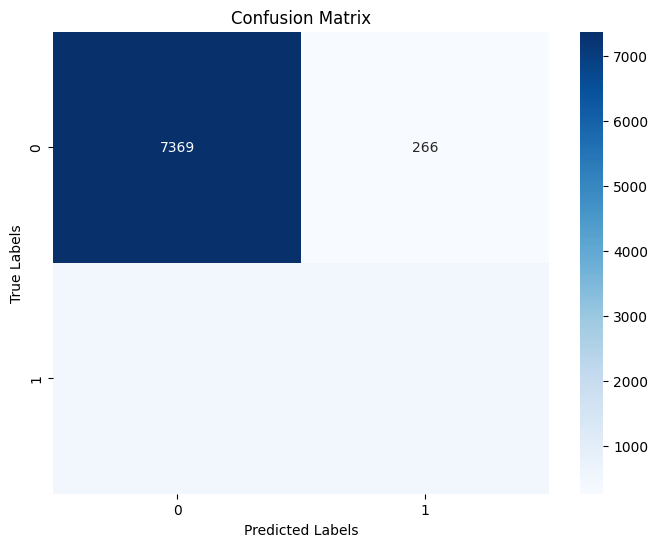

In [25]:
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix once again highlights that the model excels at predicting non-subscribers (class 0) but faces challenges when it comes to accurately identifying subscribers (class 1).

### ROC curve:

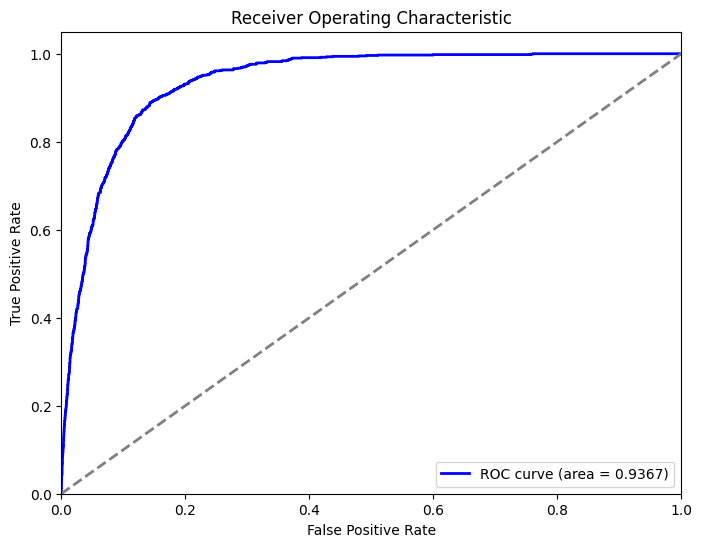

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

# plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve shows the model performs well overall, with an AUC score of 0.9367, outperforming previous models even before hyperparameter tuning and feature selection, including for subscribers (the smaller class). However, it still struggles to fully capture subscribers due to the imbalance, favoring non-subscribers. Balancing the data or adjusting the learning process could further improve its performance.

## Hyperparameter tunning

In [40]:
# define the objective function with adjustments
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 800),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.05, log=True),
        "depth": trial.suggest_int("depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 500),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
    }
    
    # Initialize CatBoostClassifier with modified parameters
    model = CatBoostClassifier(**params, eval_metric="F1", verbose=100)
    
    # Fit the model
    model.fit(X_train, y_train, cat_features=category_cols, early_stopping_rounds=50, verbose=100)
    
    # Return the F1 score on the validation dataset
    return model.best_score_["validation"]["F1"]

# Create an Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output the best parameters
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-01-01 20:50:00,603] A new study created in memory with name: no-name-6342257c-19ac-4c35-9b29-fb3216fe683f


0:	learn: 0.6449061	total: 15.1ms	remaining: 14.7s
100:	learn: 0.7641612	total: 933ms	remaining: 8.11s
200:	learn: 0.7812470	total: 1.81s	remaining: 7.01s
300:	learn: 0.7937912	total: 2.72s	remaining: 6.12s
400:	learn: 0.8041187	total: 3.65s	remaining: 5.25s
500:	learn: 0.8136538	total: 4.59s	remaining: 4.38s
600:	learn: 0.8199847	total: 5.52s	remaining: 3.47s
700:	learn: 0.8290343	total: 6.45s	remaining: 2.56s
800:	learn: 0.8360637	total: 7.45s	remaining: 1.65s
900:	learn: 0.8428231	total: 8.36s	remaining: 724ms


[I 2025-01-01 20:50:09,896] Trial 0 finished with value: 0.84744438896316 and parameters: {'iterations': 979, 'learning_rate': 0.04605947516388781, 'depth': 7, 'subsample': 0.2473869844723251, 'colsample_bylevel': 0.5651149349871035, 'min_data_in_leaf': 310, 'scale_pos_weight': 2.6682891661394983}. Best is trial 0 with value: 0.84744438896316.


978:	learn: 0.8474444	total: 9.09s	remaining: 0us
0:	learn: 0.7458052	total: 7.28ms	remaining: 6.97s
100:	learn: 0.8379328	total: 587ms	remaining: 4.99s
200:	learn: 0.8467999	total: 1.18s	remaining: 4.43s
300:	learn: 0.8492083	total: 1.78s	remaining: 3.89s
400:	learn: 0.8505795	total: 2.38s	remaining: 3.31s
500:	learn: 0.8528964	total: 2.98s	remaining: 2.73s
600:	learn: 0.8548937	total: 3.57s	remaining: 2.13s
700:	learn: 0.8555071	total: 4.2s	remaining: 1.54s
800:	learn: 0.8567762	total: 4.86s	remaining: 959ms
900:	learn: 0.8582302	total: 5.48s	remaining: 353ms


[I 2025-01-01 20:50:15,811] Trial 1 finished with value: 0.8594122548342371 and parameters: {'iterations': 959, 'learning_rate': 0.012472914015936878, 'depth': 4, 'subsample': 0.34418028257645367, 'colsample_bylevel': 0.6607538984974978, 'min_data_in_leaf': 312, 'scale_pos_weight': 6.401307303001361}. Best is trial 1 with value: 0.8594122548342371.


958:	learn: 0.8594123	total: 5.84s	remaining: 0us
0:	learn: 0.8555479	total: 13.1ms	remaining: 13.6s
100:	learn: 0.9032574	total: 1.08s	remaining: 10s
200:	learn: 0.9125129	total: 2.21s	remaining: 9.21s
300:	learn: 0.9199195	total: 3.37s	remaining: 8.25s
400:	learn: 0.9264796	total: 4.56s	remaining: 7.23s
500:	learn: 0.9313333	total: 5.74s	remaining: 6.14s
600:	learn: 0.9355312	total: 6.9s	remaining: 5s
700:	learn: 0.9416660	total: 8.1s	remaining: 3.88s
800:	learn: 0.9455587	total: 9.26s	remaining: 2.73s
900:	learn: 0.9496084	total: 10.4s	remaining: 1.58s
1000:	learn: 0.9540140	total: 11.6s	remaining: 418ms


[I 2025-01-01 20:50:27,990] Trial 2 finished with value: 0.9554858347128373 and parameters: {'iterations': 1037, 'learning_rate': 0.09067553508664124, 'depth': 8, 'subsample': 0.11909291904081973, 'colsample_bylevel': 0.6520131221271147, 'min_data_in_leaf': 443, 'scale_pos_weight': 9.41164117712672}. Best is trial 2 with value: 0.9554858347128373.


1036:	learn: 0.9554858	total: 12s	remaining: 0us
0:	learn: 0.8311327	total: 5.44ms	remaining: 5.83s
100:	learn: 0.8742115	total: 428ms	remaining: 4.12s
200:	learn: 0.8800487	total: 871ms	remaining: 3.78s
300:	learn: 0.8839006	total: 1.33s	remaining: 3.4s
400:	learn: 0.8856953	total: 1.77s	remaining: 2.96s
500:	learn: 0.8880430	total: 2.22s	remaining: 2.53s
600:	learn: 0.8898674	total: 2.68s	remaining: 2.1s
700:	learn: 0.8910267	total: 3.17s	remaining: 1.68s
800:	learn: 0.8918075	total: 3.62s	remaining: 1.23s
900:	learn: 0.8922086	total: 4.08s	remaining: 779ms
1000:	learn: 0.8931688	total: 4.54s	remaining: 326ms


[I 2025-01-01 20:50:32,914] Trial 3 finished with value: 0.8934853526257382 and parameters: {'iterations': 1073, 'learning_rate': 0.08843172375345724, 'depth': 3, 'subsample': 0.07459783673756427, 'colsample_bylevel': 0.21297046784281243, 'min_data_in_leaf': 1034, 'scale_pos_weight': 9.00509577366528}. Best is trial 2 with value: 0.9554858347128373.


1072:	learn: 0.8932049	total: 4.85s	remaining: 0us
0:	learn: 0.3053523	total: 4.77ms	remaining: 5.21s
100:	learn: 0.8595258	total: 539ms	remaining: 5.29s
200:	learn: 0.8601987	total: 1.08s	remaining: 4.79s
300:	learn: 0.8616434	total: 1.61s	remaining: 4.24s
400:	learn: 0.8620546	total: 2.15s	remaining: 3.7s
500:	learn: 0.8634728	total: 2.69s	remaining: 3.18s
600:	learn: 0.8635684	total: 3.24s	remaining: 2.65s
700:	learn: 0.8638776	total: 3.79s	remaining: 2.12s
800:	learn: 0.8644033	total: 4.32s	remaining: 1.57s
900:	learn: 0.8647734	total: 4.88s	remaining: 1.04s
1000:	learn: 0.8651236	total: 5.4s	remaining: 496ms


[I 2025-01-01 20:50:38,859] Trial 4 finished with value: 0.8656590182123493 and parameters: {'iterations': 1093, 'learning_rate': 0.0024357188698497043, 'depth': 5, 'subsample': 0.5280549228465284, 'colsample_bylevel': 0.16032894574451062, 'min_data_in_leaf': 603, 'scale_pos_weight': 8.057068696072783}. Best is trial 2 with value: 0.9554858347128373.


1092:	learn: 0.8654819	total: 5.87s	remaining: 0us
0:	learn: 0.3047851	total: 5.89ms	remaining: 5.91s
100:	learn: 0.8424374	total: 742ms	remaining: 6.64s
200:	learn: 0.8453803	total: 1.48s	remaining: 5.94s
300:	learn: 0.8466847	total: 2.2s	remaining: 5.14s
400:	learn: 0.8476926	total: 2.88s	remaining: 4.33s
500:	learn: 0.8498047	total: 3.54s	remaining: 3.56s
600:	learn: 0.8508937	total: 4.32s	remaining: 2.9s
700:	learn: 0.8517224	total: 5.06s	remaining: 2.19s
800:	learn: 0.8520088	total: 5.7s	remaining: 1.45s
900:	learn: 0.8522085	total: 6.4s	remaining: 739ms


[I 2025-01-01 20:50:46,151] Trial 5 finished with value: 0.8527318606717604 and parameters: {'iterations': 1005, 'learning_rate': 0.001141554358061976, 'depth': 8, 'subsample': 0.5366965690039777, 'colsample_bylevel': 0.12034390560940345, 'min_data_in_leaf': 149, 'scale_pos_weight': 6.856169575718536}. Best is trial 2 with value: 0.9554858347128373.


1000:	learn: 0.8525926	total: 7.16s	remaining: 28.6ms
1004:	learn: 0.8525776	total: 7.19s	remaining: 0us
0:	learn: 0.7740701	total: 8.02ms	remaining: 8.3s
100:	learn: 0.8666532	total: 757ms	remaining: 7.01s
200:	learn: 0.8682086	total: 1.5s	remaining: 6.23s
300:	learn: 0.8704410	total: 2.23s	remaining: 5.46s
400:	learn: 0.8715807	total: 3.04s	remaining: 4.81s
500:	learn: 0.8732190	total: 3.77s	remaining: 4.03s
600:	learn: 0.8743667	total: 4.49s	remaining: 3.25s
700:	learn: 0.8748420	total: 5.21s	remaining: 2.49s
800:	learn: 0.8746714	total: 5.95s	remaining: 1.74s
900:	learn: 0.8758449	total: 6.67s	remaining: 999ms
1000:	learn: 0.8762724	total: 7.39s	remaining: 258ms


[I 2025-01-01 20:50:53,893] Trial 6 finished with value: 0.8769901009878013 and parameters: {'iterations': 1036, 'learning_rate': 0.002264423704879161, 'depth': 5, 'subsample': 0.7015274824500891, 'colsample_bylevel': 0.5562152999190494, 'min_data_in_leaf': 745, 'scale_pos_weight': 8.76281637768193}. Best is trial 2 with value: 0.9554858347128373.


1035:	learn: 0.8769537	total: 7.65s	remaining: 0us
0:	learn: 0.6547291	total: 9.59ms	remaining: 10.1s
100:	learn: 0.7345523	total: 799ms	remaining: 7.51s
200:	learn: 0.7406439	total: 1.62s	remaining: 6.84s
300:	learn: 0.7479505	total: 2.49s	remaining: 6.2s
400:	learn: 0.7534776	total: 3.29s	remaining: 5.33s
500:	learn: 0.7568792	total: 4.1s	remaining: 4.49s
600:	learn: 0.7610495	total: 4.89s	remaining: 3.66s
700:	learn: 0.7632907	total: 5.71s	remaining: 2.84s
800:	learn: 0.7644701	total: 6.54s	remaining: 2.03s
900:	learn: 0.7667994	total: 7.37s	remaining: 1.22s
1000:	learn: 0.7685798	total: 8.19s	remaining: 401ms


[I 2025-01-01 20:51:02,593] Trial 7 finished with value: 0.7690167421625228 and parameters: {'iterations': 1050, 'learning_rate': 0.0035888799947826687, 'depth': 6, 'subsample': 0.43257920240287134, 'colsample_bylevel': 0.5398148551448464, 'min_data_in_leaf': 28, 'scale_pos_weight': 2.9522691055802355}. Best is trial 2 with value: 0.9554858347128373.


1049:	learn: 0.7690167	total: 8.6s	remaining: 0us
0:	learn: 0.8115542	total: 8.8ms	remaining: 9.63s
100:	learn: 0.8487336	total: 806ms	remaining: 7.94s
200:	learn: 0.8548565	total: 1.66s	remaining: 7.38s
300:	learn: 0.8626382	total: 2.63s	remaining: 6.95s
400:	learn: 0.8688069	total: 3.49s	remaining: 6.04s
500:	learn: 0.8718041	total: 4.37s	remaining: 5.18s
600:	learn: 0.8746941	total: 5.22s	remaining: 4.29s
700:	learn: 0.8763386	total: 6.04s	remaining: 3.4s
800:	learn: 0.8785677	total: 6.9s	remaining: 2.53s
900:	learn: 0.8797444	total: 7.8s	remaining: 1.68s
1000:	learn: 0.8820901	total: 8.61s	remaining: 809ms


[I 2025-01-01 20:51:12,147] Trial 8 finished with value: 0.8840725031715794 and parameters: {'iterations': 1095, 'learning_rate': 0.043135084475390766, 'depth': 5, 'subsample': 0.6627969843210948, 'colsample_bylevel': 0.7828702625846733, 'min_data_in_leaf': 399, 'scale_pos_weight': 6.041151358307566}. Best is trial 2 with value: 0.9554858347128373.


1094:	learn: 0.8839559	total: 9.44s	remaining: 0us
0:	learn: 0.7438260	total: 12.1ms	remaining: 12s
100:	learn: 0.8666542	total: 821ms	remaining: 7.25s
200:	learn: 0.8774346	total: 1.6s	remaining: 6.33s
300:	learn: 0.8862468	total: 2.42s	remaining: 5.58s
400:	learn: 0.8925472	total: 3.24s	remaining: 4.78s
500:	learn: 0.8980712	total: 4.06s	remaining: 3.98s
600:	learn: 0.9020685	total: 4.89s	remaining: 3.19s
700:	learn: 0.9062921	total: 5.86s	remaining: 2.44s
800:	learn: 0.9096631	total: 6.78s	remaining: 1.63s
900:	learn: 0.9129842	total: 7.63s	remaining: 780ms


[I 2025-01-01 20:51:20,714] Trial 9 finished with value: 0.9170770933982239 and parameters: {'iterations': 993, 'learning_rate': 0.06988886676997548, 'depth': 6, 'subsample': 0.4117308023956707, 'colsample_bylevel': 0.49041740755075464, 'min_data_in_leaf': 312, 'scale_pos_weight': 6.895573705900402}. Best is trial 2 with value: 0.9554858347128373.


992:	learn: 0.9170771	total: 8.43s	remaining: 0us
0:	learn: 0.7541061	total: 16.6ms	remaining: 15s
100:	learn: 0.8168186	total: 3.04s	remaining: 24.2s
200:	learn: 0.8326261	total: 6.36s	remaining: 22.2s
300:	learn: 0.8448804	total: 9.6s	remaining: 19.2s
400:	learn: 0.8551728	total: 12.7s	remaining: 15.8s
500:	learn: 0.8633799	total: 15.6s	remaining: 12.5s
600:	learn: 0.8704773	total: 18.8s	remaining: 9.4s
700:	learn: 0.8802405	total: 22.3s	remaining: 6.39s
800:	learn: 0.8900350	total: 25.9s	remaining: 3.27s


[I 2025-01-01 20:51:50,386] Trial 10 finished with value: 0.9002550015722898 and parameters: {'iterations': 902, 'learning_rate': 0.016201991328895726, 'depth': 10, 'subsample': 0.9929195643209154, 'colsample_bylevel': 0.9947566274553193, 'min_data_in_leaf': 829, 'scale_pos_weight': 4.217930696257068}. Best is trial 2 with value: 0.9554858347128373.


900:	learn: 0.9002032	total: 29.4s	remaining: 32.6ms
901:	learn: 0.9002550	total: 29.5s	remaining: 0us
0:	learn: 0.6080426	total: 4.53ms	remaining: 4.57s
100:	learn: 0.8732941	total: 345ms	remaining: 3.1s
200:	learn: 0.8750510	total: 683ms	remaining: 2.75s
300:	learn: 0.8764298	total: 1s	remaining: 2.37s
400:	learn: 0.8777023	total: 1.33s	remaining: 2.03s
500:	learn: 0.8786817	total: 1.68s	remaining: 1.71s
600:	learn: 0.8790032	total: 2s	remaining: 1.36s
700:	learn: 0.8800736	total: 2.32s	remaining: 1.03s
800:	learn: 0.8794057	total: 2.64s	remaining: 692ms
900:	learn: 0.8797165	total: 2.96s	remaining: 361ms


[I 2025-01-01 20:51:53,772] Trial 11 finished with value: 0.8801766942418668 and parameters: {'iterations': 1011, 'learning_rate': 0.08723635247110234, 'depth': 1, 'subsample': 0.08664989829939201, 'colsample_bylevel': 0.33834790709488693, 'min_data_in_leaf': 461, 'scale_pos_weight': 9.474251750204806}. Best is trial 2 with value: 0.9554858347128373.


1000:	learn: 0.8794392	total: 3.29s	remaining: 32.8ms
1010:	learn: 0.8797501	total: 3.32s	remaining: 0us
0:	learn: 0.8365276	total: 9.41ms	remaining: 8.9s
100:	learn: 0.8802958	total: 2.23s	remaining: 18.7s
200:	learn: 0.8934414	total: 4.29s	remaining: 15.9s
300:	learn: 0.9026650	total: 6.24s	remaining: 13.4s
400:	learn: 0.9138639	total: 8.64s	remaining: 11.8s
500:	learn: 0.9223799	total: 11.2s	remaining: 10s
600:	learn: 0.9308234	total: 13.9s	remaining: 8s
700:	learn: 0.9384704	total: 16.5s	remaining: 5.78s
800:	learn: 0.9447779	total: 19.2s	remaining: 3.49s
900:	learn: 0.9493527	total: 22s	remaining: 1.12s


[I 2025-01-01 20:52:17,162] Trial 12 finished with value: 0.9519857751807493 and parameters: {'iterations': 947, 'learning_rate': 0.03137095895565932, 'depth': 10, 'subsample': 0.2556693870919864, 'colsample_bylevel': 0.357081943434602, 'min_data_in_leaf': 639, 'scale_pos_weight': 7.572039264839718}. Best is trial 2 with value: 0.9554858347128373.


946:	learn: 0.9518539	total: 23.2s	remaining: 0us
0:	learn: 0.8430518	total: 17.9ms	remaining: 16.8s
100:	learn: 0.8802566	total: 2.23s	remaining: 18.4s
200:	learn: 0.8902698	total: 4.33s	remaining: 15.9s
300:	learn: 0.8972956	total: 6.3s	remaining: 13.3s
400:	learn: 0.9063365	total: 8.44s	remaining: 11.3s
500:	learn: 0.9150803	total: 11s	remaining: 9.58s
600:	learn: 0.9231096	total: 13.6s	remaining: 7.59s
700:	learn: 0.9291559	total: 16.2s	remaining: 5.46s
800:	learn: 0.9340652	total: 18.8s	remaining: 3.19s
900:	learn: 0.9383133	total: 21.4s	remaining: 853ms


[I 2025-01-01 20:52:39,575] Trial 13 finished with value: 0.9396921798820782 and parameters: {'iterations': 937, 'learning_rate': 0.024960684878046622, 'depth': 10, 'subsample': 0.22344770831418492, 'colsample_bylevel': 0.3544508768912851, 'min_data_in_leaf': 608, 'scale_pos_weight': 7.796279575333729}. Best is trial 2 with value: 0.9554858347128373.


936:	learn: 0.9396485	total: 22.2s	remaining: 0us
0:	learn: 0.8505934	total: 9.86ms	remaining: 9.12s
100:	learn: 0.8950135	total: 1.16s	remaining: 9.46s
200:	learn: 0.8998233	total: 2.29s	remaining: 8.28s
300:	learn: 0.9040654	total: 3.32s	remaining: 6.9s
400:	learn: 0.9072786	total: 4.42s	remaining: 5.79s
500:	learn: 0.9123049	total: 5.6s	remaining: 4.75s
600:	learn: 0.9160873	total: 6.82s	remaining: 3.69s
700:	learn: 0.9193037	total: 8.04s	remaining: 2.58s
800:	learn: 0.9218984	total: 9.32s	remaining: 1.45s
900:	learn: 0.9243283	total: 10.6s	remaining: 293ms


[I 2025-01-01 20:52:50,572] Trial 14 finished with value: 0.9245707418814617 and parameters: {'iterations': 926, 'learning_rate': 0.02578136971024881, 'depth': 8, 'subsample': 0.20500044067495207, 'colsample_bylevel': 0.7884713778600548, 'min_data_in_leaf': 775, 'scale_pos_weight': 9.824906558515314}. Best is trial 2 with value: 0.9554858347128373.


925:	learn: 0.9244980	total: 10.9s	remaining: 0us
0:	learn: 0.7271441	total: 17.4ms	remaining: 17.9s
100:	learn: 0.8220094	total: 1.5s	remaining: 13.8s
200:	learn: 0.8260456	total: 2.99s	remaining: 12.3s
300:	learn: 0.8293222	total: 4.47s	remaining: 10.8s
400:	learn: 0.8335374	total: 5.89s	remaining: 9.25s
500:	learn: 0.8375034	total: 7.4s	remaining: 7.83s
600:	learn: 0.8414030	total: 8.88s	remaining: 6.36s
700:	learn: 0.8428629	total: 10.3s	remaining: 4.87s
800:	learn: 0.8443654	total: 11.9s	remaining: 3.43s
900:	learn: 0.8461908	total: 13.6s	remaining: 1.96s
1000:	learn: 0.8484886	total: 15.1s	remaining: 454ms


[I 2025-01-01 20:53:06,323] Trial 15 finished with value: 0.8487567597874476 and parameters: {'iterations': 1031, 'learning_rate': 0.005269642442098032, 'depth': 9, 'subsample': 0.06202664871438546, 'colsample_bylevel': 0.3610542250830885, 'min_data_in_leaf': 975, 'scale_pos_weight': 4.8010603013149105}. Best is trial 2 with value: 0.9554858347128373.


1030:	learn: 0.8487139	total: 15.6s	remaining: 0us
0:	learn: 0.4383158	total: 12.6ms	remaining: 12.1s
100:	learn: 0.6158477	total: 1.21s	remaining: 10.4s
200:	learn: 0.6502379	total: 2.38s	remaining: 9.03s
300:	learn: 0.6812667	total: 3.54s	remaining: 7.81s
400:	learn: 0.7070217	total: 4.75s	remaining: 6.67s
500:	learn: 0.7291836	total: 5.97s	remaining: 5.51s
600:	learn: 0.7499297	total: 7.19s	remaining: 4.34s
700:	learn: 0.7666782	total: 8.43s	remaining: 3.16s
800:	learn: 0.7823862	total: 9.65s	remaining: 1.96s
900:	learn: 0.7958026	total: 10.9s	remaining: 764ms


[I 2025-01-01 20:53:18,233] Trial 16 finished with value: 0.8038940155174454 and parameters: {'iterations': 964, 'learning_rate': 0.04417539249099925, 'depth': 8, 'subsample': 0.28701054042747476, 'colsample_bylevel': 0.7327998791075522, 'min_data_in_leaf': 527, 'scale_pos_weight': 1.0816489659230708}. Best is trial 2 with value: 0.9554858347128373.


963:	learn: 0.8035249	total: 11.8s	remaining: 0us
0:	learn: 0.8474410	total: 21.5ms	remaining: 22.7s
100:	learn: 0.8615072	total: 1.8s	remaining: 17s
200:	learn: 0.8715982	total: 3.56s	remaining: 15.2s
300:	learn: 0.8786259	total: 5.39s	remaining: 13.6s
400:	learn: 0.8828241	total: 7.19s	remaining: 11.8s
500:	learn: 0.8856130	total: 8.9s	remaining: 9.92s
600:	learn: 0.8873152	total: 10.6s	remaining: 8.1s
700:	learn: 0.8888128	total: 12.3s	remaining: 6.3s
800:	learn: 0.8917856	total: 14.2s	remaining: 4.57s
900:	learn: 0.8941363	total: 15.8s	remaining: 2.77s
1000:	learn: 0.8955816	total: 17.5s	remaining: 1.01s


[I 2025-01-01 20:53:36,902] Trial 17 finished with value: 0.8965656096442104 and parameters: {'iterations': 1059, 'learning_rate': 0.007549645911951112, 'depth': 9, 'subsample': 0.18073071819573938, 'colsample_bylevel': 0.9235799359349537, 'min_data_in_leaf': 704, 'scale_pos_weight': 7.86746684533319}. Best is trial 2 with value: 0.9554858347128373.


1058:	learn: 0.8965656	total: 18.5s	remaining: 0us
0:	learn: 0.8411654	total: 17.9ms	remaining: 16.8s
100:	learn: 0.8958861	total: 2.06s	remaining: 17.1s
200:	learn: 0.9059090	total: 4.35s	remaining: 15.9s
300:	learn: 0.9117682	total: 6.4s	remaining: 13.5s
400:	learn: 0.9168396	total: 8.48s	remaining: 11.3s
500:	learn: 0.9268571	total: 11.3s	remaining: 9.84s
600:	learn: 0.9375043	total: 14.2s	remaining: 7.97s
700:	learn: 0.9438211	total: 17.2s	remaining: 5.8s
800:	learn: 0.9490683	total: 20.1s	remaining: 3.42s
900:	learn: 0.9539469	total: 23.1s	remaining: 925ms


[I 2025-01-01 20:54:01,349] Trial 18 finished with value: 0.9554925803047397 and parameters: {'iterations': 937, 'learning_rate': 0.025311361416114436, 'depth': 10, 'subsample': 0.9491812284730312, 'colsample_bylevel': 0.4155370206456716, 'min_data_in_leaf': 918, 'scale_pos_weight': 9.951321780610213}. Best is trial 18 with value: 0.9554925803047397.


936:	learn: 0.9554926	total: 24.3s	remaining: 0us
0:	learn: 0.8211157	total: 11.9ms	remaining: 10.7s
100:	learn: 0.8876513	total: 971ms	remaining: 7.69s
200:	learn: 0.8935149	total: 2.09s	remaining: 7.29s
300:	learn: 0.8968242	total: 3.14s	remaining: 6.26s
400:	learn: 0.8990598	total: 4.2s	remaining: 5.23s
500:	learn: 0.9017456	total: 5.16s	remaining: 4.12s
600:	learn: 0.9043739	total: 6.09s	remaining: 3.04s
700:	learn: 0.9065673	total: 7.16s	remaining: 2.04s
800:	learn: 0.9087048	total: 8.16s	remaining: 1.02s


[I 2025-01-01 20:54:10,638] Trial 19 finished with value: 0.9115421912604293 and parameters: {'iterations': 901, 'learning_rate': 0.0151259653123027, 'depth': 7, 'subsample': 0.9088507045946445, 'colsample_bylevel': 0.44175740067011154, 'min_data_in_leaf': 914, 'scale_pos_weight': 9.995617492875475}. Best is trial 18 with value: 0.9554925803047397.


900:	learn: 0.9115422	total: 9.16s	remaining: 0us
0:	learn: 0.8149488	total: 21ms	remaining: 21.4s
100:	learn: 0.8976004	total: 1.77s	remaining: 16.1s
200:	learn: 0.9122749	total: 3.56s	remaining: 14.5s
300:	learn: 0.9270257	total: 5.59s	remaining: 13.3s
400:	learn: 0.9374582	total: 7.57s	remaining: 11.7s
500:	learn: 0.9456972	total: 9.58s	remaining: 9.9s
600:	learn: 0.9526390	total: 11.7s	remaining: 8.12s
700:	learn: 0.9587279	total: 13.8s	remaining: 6.25s
800:	learn: 0.9629885	total: 15.8s	remaining: 4.31s
900:	learn: 0.9676210	total: 17.9s	remaining: 2.34s
1000:	learn: 0.9725408	total: 19.9s	remaining: 358ms


[I 2025-01-01 20:54:31,128] Trial 20 finished with value: 0.9732393071240253 and parameters: {'iterations': 1019, 'learning_rate': 0.05776549116828566, 'depth': 9, 'subsample': 0.7757034432732098, 'colsample_bylevel': 0.6664127636909181, 'min_data_in_leaf': 1070, 'scale_pos_weight': 8.810543789472558}. Best is trial 20 with value: 0.9732393071240253.


1018:	learn: 0.9732393	total: 20.3s	remaining: 0us
0:	learn: 0.8553903	total: 17.2ms	remaining: 16.9s
100:	learn: 0.8943337	total: 1.72s	remaining: 15s
200:	learn: 0.9109736	total: 3.44s	remaining: 13.4s
300:	learn: 0.9267322	total: 5.45s	remaining: 12.4s
400:	learn: 0.9386703	total: 7.61s	remaining: 11.1s
500:	learn: 0.9464237	total: 9.93s	remaining: 9.59s
600:	learn: 0.9546294	total: 12.2s	remaining: 7.82s
700:	learn: 0.9621475	total: 14.4s	remaining: 5.85s
800:	learn: 0.9679237	total: 16.5s	remaining: 3.79s
900:	learn: 0.9724997	total: 18.5s	remaining: 1.73s


[I 2025-01-01 20:54:51,843] Trial 21 finished with value: 0.9759162291210444 and parameters: {'iterations': 985, 'learning_rate': 0.06200843231851065, 'depth': 9, 'subsample': 0.8308515350467673, 'colsample_bylevel': 0.6460681984227371, 'min_data_in_leaf': 1056, 'scale_pos_weight': 8.696124305513912}. Best is trial 21 with value: 0.9759162291210444.


984:	learn: 0.9759162	total: 20.5s	remaining: 0us
0:	learn: 0.8561710	total: 20.8ms	remaining: 20.4s
100:	learn: 0.8970716	total: 1.86s	remaining: 16.2s
200:	learn: 0.9105939	total: 3.73s	remaining: 14.5s
300:	learn: 0.9261964	total: 6.08s	remaining: 13.7s
400:	learn: 0.9383358	total: 8.13s	remaining: 11.8s
500:	learn: 0.9464103	total: 10.2s	remaining: 9.75s
600:	learn: 0.9542159	total: 12.2s	remaining: 7.7s
700:	learn: 0.9594791	total: 14.3s	remaining: 5.69s
800:	learn: 0.9644639	total: 16.3s	remaining: 3.66s
900:	learn: 0.9699728	total: 18.3s	remaining: 1.63s


[I 2025-01-01 20:55:12,040] Trial 22 finished with value: 0.9733495204312546 and parameters: {'iterations': 981, 'learning_rate': 0.059309783235653356, 'depth': 9, 'subsample': 0.8146791568647469, 'colsample_bylevel': 0.6524306107314126, 'min_data_in_leaf': 1069, 'scale_pos_weight': 8.776423753000216}. Best is trial 21 with value: 0.9759162291210444.


980:	learn: 0.9733495	total: 20s	remaining: 0us
0:	learn: 0.8515468	total: 18.7ms	remaining: 18.4s
100:	learn: 0.8951410	total: 1.74s	remaining: 15.2s
200:	learn: 0.9087333	total: 3.38s	remaining: 13.2s
300:	learn: 0.9236622	total: 5.37s	remaining: 12.2s
400:	learn: 0.9336241	total: 7.36s	remaining: 10.7s
500:	learn: 0.9413681	total: 9.43s	remaining: 9.09s
600:	learn: 0.9473587	total: 11.5s	remaining: 7.32s
700:	learn: 0.9564629	total: 13.5s	remaining: 5.46s
800:	learn: 0.9627685	total: 15.7s	remaining: 3.58s
900:	learn: 0.9678681	total: 18.6s	remaining: 1.72s


[I 2025-01-01 20:55:32,883] Trial 23 finished with value: 0.970858797835659 and parameters: {'iterations': 984, 'learning_rate': 0.057282884226237465, 'depth': 9, 'subsample': 0.8139955960938969, 'colsample_bylevel': 0.6499467569292042, 'min_data_in_leaf': 1082, 'scale_pos_weight': 8.319357566151032}. Best is trial 21 with value: 0.9759162291210444.


983:	learn: 0.9708588	total: 20.6s	remaining: 0us
0:	learn: 0.8152852	total: 16.2ms	remaining: 16.5s
100:	learn: 0.8861466	total: 1.14s	remaining: 10.4s
200:	learn: 0.8921933	total: 2.24s	remaining: 9.13s
300:	learn: 0.8971572	total: 3.42s	remaining: 8.17s
400:	learn: 0.9036621	total: 4.7s	remaining: 7.24s
500:	learn: 0.9089748	total: 5.85s	remaining: 6.05s
600:	learn: 0.9123668	total: 7.01s	remaining: 4.88s
700:	learn: 0.9171378	total: 8.23s	remaining: 3.73s
800:	learn: 0.9206191	total: 9.59s	remaining: 2.61s
900:	learn: 0.9234600	total: 11s	remaining: 1.44s
1000:	learn: 0.9263233	total: 12.3s	remaining: 221ms


[I 2025-01-01 20:55:45,542] Trial 24 finished with value: 0.9265991684597028 and parameters: {'iterations': 1019, 'learning_rate': 0.03549655012560088, 'depth': 7, 'subsample': 0.8038145515492426, 'colsample_bylevel': 0.8457400926450678, 'min_data_in_leaf': 1049, 'scale_pos_weight': 8.874516867272238}. Best is trial 21 with value: 0.9759162291210444.


1018:	learn: 0.9265992	total: 12.5s	remaining: 0us
0:	learn: 0.7631174	total: 23ms	remaining: 22.4s
100:	learn: 0.8545792	total: 2.04s	remaining: 17.7s
200:	learn: 0.8786923	total: 3.83s	remaining: 14.8s
300:	learn: 0.9007021	total: 6.2s	remaining: 13.9s
400:	learn: 0.9160979	total: 8.31s	remaining: 11.9s
500:	learn: 0.9287071	total: 10.3s	remaining: 9.83s
600:	learn: 0.9388590	total: 12.4s	remaining: 7.75s
700:	learn: 0.9479605	total: 14.5s	remaining: 5.73s
800:	learn: 0.9553434	total: 16.6s	remaining: 3.66s
900:	learn: 0.9624634	total: 18.8s	remaining: 1.58s


[I 2025-01-01 20:56:06,059] Trial 25 finished with value: 0.9671463698591323 and parameters: {'iterations': 977, 'learning_rate': 0.06014509899349429, 'depth': 9, 'subsample': 0.6696254977983057, 'colsample_bylevel': 0.7007933223234866, 'min_data_in_leaf': 867, 'scale_pos_weight': 5.032035960594684}. Best is trial 21 with value: 0.9759162291210444.


976:	learn: 0.9671464	total: 20.3s	remaining: 0us
0:	learn: 0.7565689	total: 7.7ms	remaining: 7.71s
100:	learn: 0.8660441	total: 1.79s	remaining: 16s
200:	learn: 0.8774884	total: 3.89s	remaining: 15.5s
300:	learn: 0.8834316	total: 5.64s	remaining: 13.2s
400:	learn: 0.8872192	total: 8.23s	remaining: 12.4s
500:	learn: 0.8928932	total: 10.1s	remaining: 10.1s
600:	learn: 0.8990674	total: 13.2s	remaining: 8.82s
700:	learn: 0.9059478	total: 16.1s	remaining: 6.92s
800:	learn: 0.9133184	total: 19.2s	remaining: 4.83s
900:	learn: 0.9178383	total: 22.2s	remaining: 2.51s


[I 2025-01-01 20:56:31,575] Trial 26 finished with value: 0.922688842935416 and parameters: {'iterations': 1003, 'learning_rate': 0.019301467855304424, 'depth': 9, 'subsample': 0.8350495713706757, 'colsample_bylevel': 0.6069836357887751, 'min_data_in_leaf': 985, 'scale_pos_weight': 7.150387854802287}. Best is trial 21 with value: 0.9759162291210444.


1000:	learn: 0.9222075	total: 25.2s	remaining: 50.4ms
1002:	learn: 0.9226888	total: 25.3s	remaining: 0us
0:	learn: 0.7626938	total: 5.62ms	remaining: 5.72s
100:	learn: 0.8040372	total: 751ms	remaining: 6.82s
200:	learn: 0.8420605	total: 1.25s	remaining: 5.1s
300:	learn: 0.8478175	total: 1.92s	remaining: 4.57s
400:	learn: 0.8544446	total: 2.6s	remaining: 4.01s
500:	learn: 0.8581537	total: 3.09s	remaining: 3.2s
600:	learn: 0.8593035	total: 3.76s	remaining: 2.61s
700:	learn: 0.8598086	total: 4.24s	remaining: 1.92s
800:	learn: 0.8595627	total: 4.88s	remaining: 1.33s
900:	learn: 0.8610628	total: 5.54s	remaining: 726ms
1000:	learn: 0.8625009	total: 6.08s	remaining: 109ms


[I 2025-01-01 20:56:38,019] Trial 27 finished with value: 0.8626381680387893 and parameters: {'iterations': 1019, 'learning_rate': 0.009263727242063468, 'depth': 1, 'subsample': 0.7419776011133254, 'colsample_bylevel': 0.8580459525475654, 'min_data_in_leaf': 1074, 'scale_pos_weight': 8.52930863155175}. Best is trial 21 with value: 0.9759162291210444.


1018:	learn: 0.8626382	total: 6.31s	remaining: 0us
0:	learn: 0.7628536	total: 16.3ms	remaining: 15.7s
100:	learn: 0.8536067	total: 1.6s	remaining: 13.7s
200:	learn: 0.8658295	total: 3.27s	remaining: 12.4s
300:	learn: 0.8797940	total: 5.11s	remaining: 11.3s
400:	learn: 0.8880230	total: 6.74s	remaining: 9.47s
500:	learn: 0.8948668	total: 8.6s	remaining: 7.96s
600:	learn: 0.9028610	total: 10.5s	remaining: 6.35s
700:	learn: 0.9084462	total: 12.2s	remaining: 4.6s
800:	learn: 0.9131187	total: 13.4s	remaining: 2.75s
900:	learn: 0.9181361	total: 14.6s	remaining: 1.04s


[I 2025-01-01 20:56:53,673] Trial 28 finished with value: 0.9208351720181793 and parameters: {'iterations': 965, 'learning_rate': 0.05616961128308391, 'depth': 7, 'subsample': 0.8921118172646993, 'colsample_bylevel': 0.7424888002737712, 'min_data_in_leaf': 963, 'scale_pos_weight': 5.793163251476351}. Best is trial 21 with value: 0.9759162291210444.


964:	learn: 0.9208160	total: 15.4s	remaining: 0us
0:	learn: 0.7923924	total: 13.9ms	remaining: 13.7s
100:	learn: 0.8720819	total: 1.26s	remaining: 11.1s
200:	learn: 0.8823539	total: 2.4s	remaining: 9.39s
300:	learn: 0.8926019	total: 3.69s	remaining: 8.41s
400:	learn: 0.9019886	total: 5.01s	remaining: 7.34s
500:	learn: 0.9091795	total: 6.34s	remaining: 6.17s
600:	learn: 0.9158370	total: 7.61s	remaining: 4.9s
700:	learn: 0.9204234	total: 8.88s	remaining: 3.64s
800:	learn: 0.9261879	total: 10.2s	remaining: 2.37s
900:	learn: 0.9303972	total: 11.6s	remaining: 1.12s


[I 2025-01-01 20:57:06,726] Trial 29 finished with value: 0.9345963535452801 and parameters: {'iterations': 988, 'learning_rate': 0.038772028610152755, 'depth': 8, 'subsample': 0.62417636563094, 'colsample_bylevel': 0.5899149228016018, 'min_data_in_leaf': 843, 'scale_pos_weight': 7.304617905649573}. Best is trial 21 with value: 0.9759162291210444.


987:	learn: 0.9345656	total: 12.9s	remaining: 0us
0:	learn: 0.6724256	total: 6.42ms	remaining: 6.25s
100:	learn: 0.7939828	total: 824ms	remaining: 7.13s
200:	learn: 0.8089353	total: 1.65s	remaining: 6.37s
300:	learn: 0.8216357	total: 2.5s	remaining: 5.59s
400:	learn: 0.8301020	total: 3.42s	remaining: 4.89s
500:	learn: 0.8383047	total: 4.5s	remaining: 4.25s
600:	learn: 0.8468145	total: 5.51s	remaining: 3.43s
700:	learn: 0.8551070	total: 6.62s	remaining: 2.59s
800:	learn: 0.8617550	total: 7.49s	remaining: 1.63s
900:	learn: 0.8666581	total: 8.35s	remaining: 686ms


[I 2025-01-01 20:57:15,853] Trial 30 finished with value: 0.8707206215202646 and parameters: {'iterations': 975, 'learning_rate': 0.07302418833503829, 'depth': 6, 'subsample': 0.5949634605687847, 'colsample_bylevel': 0.4639599045192616, 'min_data_in_leaf': 1086, 'scale_pos_weight': 3.365593309874381}. Best is trial 21 with value: 0.9759162291210444.


974:	learn: 0.8707206	total: 8.99s	remaining: 0us
0:	learn: 0.8358935	total: 21.1ms	remaining: 20.7s
100:	learn: 0.8904479	total: 1.85s	remaining: 16.1s
200:	learn: 0.9022430	total: 3.63s	remaining: 14.1s
300:	learn: 0.9201350	total: 5.71s	remaining: 12.9s
400:	learn: 0.9309652	total: 7.83s	remaining: 11.3s
500:	learn: 0.9405129	total: 9.82s	remaining: 9.42s
600:	learn: 0.9481382	total: 11.8s	remaining: 7.5s
700:	learn: 0.9542485	total: 14s	remaining: 5.6s
800:	learn: 0.9600027	total: 16.3s	remaining: 3.68s
900:	learn: 0.9646383	total: 18.6s	remaining: 1.67s


[I 2025-01-01 20:57:36,638] Trial 31 finished with value: 0.9678773689375142 and parameters: {'iterations': 982, 'learning_rate': 0.05206390354884131, 'depth': 9, 'subsample': 0.7727236862360164, 'colsample_bylevel': 0.6281152756284438, 'min_data_in_leaf': 1095, 'scale_pos_weight': 8.28406182098247}. Best is trial 21 with value: 0.9759162291210444.


981:	learn: 0.9678490	total: 20.6s	remaining: 0us
0:	learn: 0.8478268	total: 20.4ms	remaining: 20.3s
100:	learn: 0.9004102	total: 1.9s	remaining: 16.9s
200:	learn: 0.9167235	total: 3.74s	remaining: 14.8s
300:	learn: 0.9324582	total: 5.97s	remaining: 13.8s
400:	learn: 0.9429253	total: 8.07s	remaining: 12s
500:	learn: 0.9505182	total: 10.5s	remaining: 10.3s
600:	learn: 0.9569530	total: 12.6s	remaining: 8.28s
700:	learn: 0.9639738	total: 14.8s	remaining: 6.19s
800:	learn: 0.9681472	total: 17.2s	remaining: 4.16s
900:	learn: 0.9713093	total: 20.5s	remaining: 2.13s


[I 2025-01-01 20:57:59,688] Trial 32 finished with value: 0.9743461743670485 and parameters: {'iterations': 995, 'learning_rate': 0.06090873623810705, 'depth': 9, 'subsample': 0.8693538296081262, 'colsample_bylevel': 0.6800215929029411, 'min_data_in_leaf': 992, 'scale_pos_weight': 9.175698834397698}. Best is trial 21 with value: 0.9759162291210444.


994:	learn: 0.9743204	total: 22.8s	remaining: 0us
0:	learn: 0.8615128	total: 34.3ms	remaining: 34.1s
100:	learn: 0.9149535	total: 2.94s	remaining: 26s
200:	learn: 0.9459883	total: 6.21s	remaining: 24.5s
300:	learn: 0.9638391	total: 9.83s	remaining: 22.7s
400:	learn: 0.9730391	total: 13.2s	remaining: 19.6s
500:	learn: 0.9808322	total: 16.8s	remaining: 16.6s
600:	learn: 0.9862891	total: 20.7s	remaining: 13.6s
700:	learn: 0.9902315	total: 24s	remaining: 10.1s
800:	learn: 0.9926885	total: 27.3s	remaining: 6.62s
900:	learn: 0.9946312	total: 30.4s	remaining: 3.18s


[I 2025-01-01 20:58:34,447] Trial 33 finished with value: 0.9961592731583533 and parameters: {'iterations': 995, 'learning_rate': 0.09649165745828965, 'depth': 10, 'subsample': 0.8499823652512103, 'colsample_bylevel': 0.6899418365907177, 'min_data_in_leaf': 967, 'scale_pos_weight': 9.36227798676794}. Best is trial 33 with value: 0.9961592731583533.


994:	learn: 0.9961593	total: 34.5s	remaining: 0us
0:	learn: 0.8506736	total: 21ms	remaining: 21s
100:	learn: 0.9136631	total: 3.27s	remaining: 29.1s
200:	learn: 0.9478133	total: 6.56s	remaining: 26.1s
300:	learn: 0.9631658	total: 9.89s	remaining: 22.9s
400:	learn: 0.9749397	total: 13.2s	remaining: 19.7s
500:	learn: 0.9814963	total: 16.5s	remaining: 16.4s
600:	learn: 0.9868999	total: 19.9s	remaining: 13.2s
700:	learn: 0.9906245	total: 23.5s	remaining: 10s
800:	learn: 0.9933474	total: 27s	remaining: 6.68s
900:	learn: 0.9954624	total: 30.5s	remaining: 3.31s


[I 2025-01-01 20:59:08,359] Trial 34 finished with value: 0.9968684690235506 and parameters: {'iterations': 999, 'learning_rate': 0.09926909248438512, 'depth': 10, 'subsample': 0.8748582592492055, 'colsample_bylevel': 0.8222321060804392, 'min_data_in_leaf': 1006, 'scale_pos_weight': 9.311447145725271}. Best is trial 34 with value: 0.9968684690235506.


998:	learn: 0.9968552	total: 33.7s	remaining: 0us
0:	learn: 0.8368936	total: 10.5ms	remaining: 10.4s
100:	learn: 0.9115067	total: 2.56s	remaining: 22.8s
200:	learn: 0.9379084	total: 5.88s	remaining: 23.3s
300:	learn: 0.9581084	total: 9.23s	remaining: 21.4s
400:	learn: 0.9695520	total: 12.7s	remaining: 18.9s
500:	learn: 0.9771912	total: 16s	remaining: 15.8s
600:	learn: 0.9832231	total: 19.5s	remaining: 12.8s
700:	learn: 0.9865412	total: 22.9s	remaining: 9.67s
800:	learn: 0.9898983	total: 26.3s	remaining: 6.43s
900:	learn: 0.9925132	total: 29.7s	remaining: 3.17s


[I 2025-01-01 20:59:41,562] Trial 35 finished with value: 0.9944868625823501 and parameters: {'iterations': 997, 'learning_rate': 0.08760454774917498, 'depth': 10, 'subsample': 0.869521924693899, 'colsample_bylevel': 0.8354902462737457, 'min_data_in_leaf': 905, 'scale_pos_weight': 9.025981866624228}. Best is trial 34 with value: 0.9968684690235506.


996:	learn: 0.9944869	total: 33s	remaining: 0us
0:	learn: 0.8191868	total: 10ms	remaining: 9.55s
100:	learn: 0.9128208	total: 2.8s	remaining: 23.7s
200:	learn: 0.9419190	total: 6.33s	remaining: 23.8s
300:	learn: 0.9570247	total: 9.74s	remaining: 21.2s
400:	learn: 0.9685590	total: 13.4s	remaining: 18.5s
500:	learn: 0.9763857	total: 17.2s	remaining: 15.6s
600:	learn: 0.9831348	total: 21s	remaining: 12.4s
700:	learn: 0.9878544	total: 24.9s	remaining: 9.01s
800:	learn: 0.9903038	total: 28.4s	remaining: 5.46s
900:	learn: 0.9922721	total: 32.1s	remaining: 1.92s


[I 2025-01-01 21:00:15,820] Trial 36 finished with value: 0.9933501864528973 and parameters: {'iterations': 955, 'learning_rate': 0.09107283942769849, 'depth': 10, 'subsample': 0.9798582345097145, 'colsample_bylevel': 0.8732032841217756, 'min_data_in_leaf': 903, 'scale_pos_weight': 9.445496155530773}. Best is trial 34 with value: 0.9968684690235506.


954:	learn: 0.9933372	total: 34s	remaining: 0us
0:	learn: 0.8497546	total: 16.5ms	remaining: 15.7s
100:	learn: 0.9133370	total: 2.96s	remaining: 25s
200:	learn: 0.9429502	total: 6.7s	remaining: 25.1s
300:	learn: 0.9583893	total: 11.9s	remaining: 25.8s
400:	learn: 0.9694699	total: 16.3s	remaining: 22.4s
500:	learn: 0.9781681	total: 21.4s	remaining: 19.4s
600:	learn: 0.9834072	total: 26.5s	remaining: 15.6s
700:	learn: 0.9870402	total: 31.6s	remaining: 11.4s
800:	learn: 0.9900545	total: 36.9s	remaining: 7.04s
900:	learn: 0.9924231	total: 41.4s	remaining: 2.43s


[I 2025-01-01 21:00:59,283] Trial 37 finished with value: 0.9932056513405585 and parameters: {'iterations': 954, 'learning_rate': 0.09194757935424124, 'depth': 10, 'subsample': 0.9962239933116837, 'colsample_bylevel': 0.9121907183168607, 'min_data_in_leaf': 901, 'scale_pos_weight': 9.406976729884793}. Best is trial 34 with value: 0.9968684690235506.


953:	learn: 0.9932057	total: 43.2s	remaining: 0us
0:	learn: 0.7572701	total: 8.08ms	remaining: 7.42s
100:	learn: 0.8861801	total: 636ms	remaining: 5.16s
200:	learn: 0.8918447	total: 1.28s	remaining: 4.58s
300:	learn: 0.8947986	total: 1.94s	remaining: 3.98s
400:	learn: 0.8976657	total: 2.56s	remaining: 3.31s
500:	learn: 0.8992781	total: 3.22s	remaining: 2.69s
600:	learn: 0.9008037	total: 3.89s	remaining: 2.06s
700:	learn: 0.9020467	total: 4.62s	remaining: 1.44s
800:	learn: 0.9027706	total: 5.39s	remaining: 801ms


[I 2025-01-01 21:01:05,550] Trial 38 finished with value: 0.9049867204472624 and parameters: {'iterations': 920, 'learning_rate': 0.0987278225085797, 'depth': 3, 'subsample': 0.9418113072115573, 'colsample_bylevel': 0.8488139110687438, 'min_data_in_leaf': 770, 'scale_pos_weight': 9.276594594283829}. Best is trial 34 with value: 0.9968684690235506.


900:	learn: 0.9043751	total: 6.06s	remaining: 128ms
919:	learn: 0.9047693	total: 6.17s	remaining: 0us
0:	learn: 0.8233484	total: 13.4ms	remaining: 13s
100:	learn: 0.8905790	total: 2.81s	remaining: 24.1s
200:	learn: 0.9240295	total: 6.07s	remaining: 23.2s
300:	learn: 0.9460946	total: 9.45s	remaining: 21s
400:	learn: 0.9607162	total: 13s	remaining: 18.4s
500:	learn: 0.9706198	total: 16.9s	remaining: 15.8s
600:	learn: 0.9812071	total: 20.3s	remaining: 12.4s
700:	learn: 0.9865572	total: 23.7s	remaining: 9.07s
800:	learn: 0.9905235	total: 28.6s	remaining: 6s
900:	learn: 0.9937427	total: 33.6s	remaining: 2.53s


[I 2025-01-01 21:01:42,662] Trial 39 finished with value: 0.9951644122271288 and parameters: {'iterations': 969, 'learning_rate': 0.0798383719815302, 'depth': 10, 'subsample': 0.7258593633340109, 'colsample_bylevel': 0.9946211876624186, 'min_data_in_leaf': 689, 'scale_pos_weight': 6.495185971772668}. Best is trial 34 with value: 0.9968684690235506.


968:	learn: 0.9951644	total: 36.9s	remaining: 0us
0:	learn: 0.8294075	total: 39.9ms	remaining: 38.6s
100:	learn: 0.8875162	total: 4.03s	remaining: 34.7s
200:	learn: 0.9218614	total: 8.39s	remaining: 32.1s
300:	learn: 0.9442750	total: 13.6s	remaining: 30.2s
400:	learn: 0.9596895	total: 19.1s	remaining: 27.1s
500:	learn: 0.9696313	total: 22.8s	remaining: 21.3s
600:	learn: 0.9762270	total: 26.4s	remaining: 16.2s
700:	learn: 0.9829200	total: 29.7s	remaining: 11.4s
800:	learn: 0.9878418	total: 33.1s	remaining: 6.95s
900:	learn: 0.9909421	total: 37.9s	remaining: 2.86s


[I 2025-01-01 21:02:23,641] Trial 40 finished with value: 0.9928521494845287 and parameters: {'iterations': 969, 'learning_rate': 0.07441978668307965, 'depth': 10, 'subsample': 0.731203847765312, 'colsample_bylevel': 0.971450607256545, 'min_data_in_leaf': 694, 'scale_pos_weight': 6.669616055004225}. Best is trial 34 with value: 0.9968684690235506.


968:	learn: 0.9928521	total: 40.7s	remaining: 0us
0:	learn: 0.8212231	total: 13.2ms	remaining: 12.6s
100:	learn: 0.8946331	total: 3.33s	remaining: 28s
200:	learn: 0.9293673	total: 8.14s	remaining: 30.4s
300:	learn: 0.9529813	total: 13s	remaining: 28.1s
400:	learn: 0.9685871	total: 17.8s	remaining: 24.4s
500:	learn: 0.9799231	total: 21.7s	remaining: 19.6s
600:	learn: 0.9868776	total: 25.5s	remaining: 14.9s
700:	learn: 0.9920323	total: 29.2s	remaining: 10.4s
800:	learn: 0.9949877	total: 32.8s	remaining: 6.19s
900:	learn: 0.9969021	total: 36.4s	remaining: 2.06s


[I 2025-01-01 21:03:02,150] Trial 41 finished with value: 0.9978194980706964 and parameters: {'iterations': 952, 'learning_rate': 0.0965581640112365, 'depth': 10, 'subsample': 0.9383863162306643, 'colsample_bylevel': 0.9154019651972712, 'min_data_in_leaf': 817, 'scale_pos_weight': 6.2085498224559625}. Best is trial 41 with value: 0.9978194980706964.


951:	learn: 0.9978195	total: 38.2s	remaining: 0us
0:	learn: 0.8165349	total: 34.3ms	remaining: 34.3s
100:	learn: 0.8907818	total: 2.81s	remaining: 25s
200:	learn: 0.9253378	total: 5.8s	remaining: 23.1s
300:	learn: 0.9490197	total: 9.13s	remaining: 21.2s
400:	learn: 0.9638570	total: 12.5s	remaining: 18.7s
500:	learn: 0.9746301	total: 15.9s	remaining: 15.8s
600:	learn: 0.9823280	total: 19.3s	remaining: 12.8s
700:	learn: 0.9875133	total: 22.7s	remaining: 9.69s
800:	learn: 0.9913103	total: 26.2s	remaining: 6.51s
900:	learn: 0.9941555	total: 29.6s	remaining: 3.25s


[I 2025-01-01 21:03:35,300] Trial 42 finished with value: 0.9965172332600993 and parameters: {'iterations': 1000, 'learning_rate': 0.08097500254678476, 'depth': 10, 'subsample': 0.8723906442798305, 'colsample_bylevel': 0.8016032268490267, 'min_data_in_leaf': 815, 'scale_pos_weight': 6.339406476180894}. Best is trial 41 with value: 0.9978194980706964.


999:	learn: 0.9965172	total: 32.9s	remaining: 0us
0:	learn: 0.8141085	total: 15.5ms	remaining: 15.6s
100:	learn: 0.8710110	total: 1.31s	remaining: 11.8s
200:	learn: 0.8909555	total: 2.69s	remaining: 10.8s
300:	learn: 0.9052605	total: 4.13s	remaining: 9.71s
400:	learn: 0.9161438	total: 5.6s	remaining: 8.48s
500:	learn: 0.9262009	total: 7.1s	remaining: 7.18s
600:	learn: 0.9350209	total: 8.65s	remaining: 5.86s
700:	learn: 0.9430338	total: 10.2s	remaining: 4.45s
800:	learn: 0.9483535	total: 11.7s	remaining: 3.02s
900:	learn: 0.9533481	total: 13.3s	remaining: 1.57s


[I 2025-01-01 21:03:50,458] Trial 43 finished with value: 0.9590938877874701 and parameters: {'iterations': 1008, 'learning_rate': 0.07404942343031226, 'depth': 8, 'subsample': 0.9294869993637283, 'colsample_bylevel': 0.946146729731868, 'min_data_in_leaf': 809, 'scale_pos_weight': 6.306800611215014}. Best is trial 41 with value: 0.9978194980706964.


1000:	learn: 0.9589648	total: 14.9s	remaining: 104ms
1007:	learn: 0.9590173	total: 15s	remaining: 0us
0:	learn: 0.8090411	total: 32.7ms	remaining: 33.6s
100:	learn: 0.8880624	total: 3.02s	remaining: 27.8s
200:	learn: 0.9281041	total: 6.3s	remaining: 25.9s
300:	learn: 0.9547504	total: 9.79s	remaining: 23.7s
400:	learn: 0.9714105	total: 13.6s	remaining: 21.4s
500:	learn: 0.9830924	total: 17s	remaining: 17.9s
600:	learn: 0.9889845	total: 20.4s	remaining: 14.5s
700:	learn: 0.9939224	total: 23.8s	remaining: 11.1s
800:	learn: 0.9965881	total: 27.7s	remaining: 7.88s
900:	learn: 0.9985217	total: 31.1s	remaining: 4.41s
1000:	learn: 0.9993065	total: 35.1s	remaining: 981ms


[I 2025-01-01 21:04:26,746] Trial 44 finished with value: 0.9993989290260216 and parameters: {'iterations': 1029, 'learning_rate': 0.09950799585447971, 'depth': 10, 'subsample': 0.8774931888951394, 'colsample_bylevel': 0.7919072766207891, 'min_data_in_leaf': 689, 'scale_pos_weight': 5.380896663515153}. Best is trial 44 with value: 0.9993989290260216.


1028:	learn: 0.9993758	total: 36s	remaining: 0us
0:	learn: 0.7441797	total: 8.3ms	remaining: 8.72s
100:	learn: 0.8315148	total: 743ms	remaining: 7s
200:	learn: 0.8386327	total: 1.49s	remaining: 6.3s
300:	learn: 0.8449191	total: 2.23s	remaining: 5.55s
400:	learn: 0.8502538	total: 2.96s	remaining: 4.8s
500:	learn: 0.8538457	total: 3.7s	remaining: 4.07s
600:	learn: 0.8564459	total: 4.45s	remaining: 3.34s
700:	learn: 0.8574680	total: 5.29s	remaining: 2.65s
800:	learn: 0.8600413	total: 6.07s	remaining: 1.9s
900:	learn: 0.8616106	total: 6.84s	remaining: 1.15s
1000:	learn: 0.8642377	total: 7.61s	remaining: 388ms


[I 2025-01-01 21:04:34,850] Trial 45 finished with value: 0.8648254588620446 and parameters: {'iterations': 1052, 'learning_rate': 0.04631714535109355, 'depth': 4, 'subsample': 0.8638283655894202, 'colsample_bylevel': 0.7874640776000505, 'min_data_in_leaf': 547, 'scale_pos_weight': 5.321652714302129}. Best is trial 44 with value: 0.9993989290260216.


1051:	learn: 0.8645514	total: 8s	remaining: 0us
0:	learn: 0.7802943	total: 31.7ms	remaining: 32.6s
100:	learn: 0.8613019	total: 2.46s	remaining: 22.6s
200:	learn: 0.9169089	total: 5.86s	remaining: 24.2s
300:	learn: 0.9487044	total: 9.34s	remaining: 22.6s
400:	learn: 0.9650518	total: 12.8s	remaining: 20.1s
500:	learn: 0.9779412	total: 16.1s	remaining: 17s
600:	learn: 0.9885748	total: 19.2s	remaining: 13.7s
700:	learn: 0.9942431	total: 23.4s	remaining: 11s
800:	learn: 0.9969519	total: 26.7s	remaining: 7.63s
900:	learn: 0.9985945	total: 29.9s	remaining: 4.28s
1000:	learn: 0.9993553	total: 33.3s	remaining: 965ms


[I 2025-01-01 21:05:09,339] Trial 46 finished with value: 0.9994724783078085 and parameters: {'iterations': 1030, 'learning_rate': 0.09665323375455996, 'depth': 10, 'subsample': 0.4551315826813087, 'colsample_bylevel': 0.7394221906572205, 'min_data_in_leaf': 642, 'scale_pos_weight': 4.244936427222929}. Best is trial 46 with value: 0.9994724783078085.


1029:	learn: 0.9994725	total: 34.2s	remaining: 0us
0:	learn: 0.0000000	total: 3.8ms	remaining: 4.11s
100:	learn: 0.0347230	total: 401ms	remaining: 3.9s
200:	learn: 0.0805125	total: 797ms	remaining: 3.5s
300:	learn: 0.1797841	total: 1.2s	remaining: 3.12s
400:	learn: 0.1962370	total: 1.64s	remaining: 2.78s
500:	learn: 0.2261318	total: 2.11s	remaining: 2.45s
600:	learn: 0.2512633	total: 2.55s	remaining: 2.05s
700:	learn: 0.2784122	total: 3.07s	remaining: 1.67s
800:	learn: 0.3028085	total: 3.51s	remaining: 1.24s
900:	learn: 0.3319419	total: 3.92s	remaining: 792ms
1000:	learn: 0.3529786	total: 4.32s	remaining: 354ms


[I 2025-01-01 21:05:14,145] Trial 47 finished with value: 0.3691017033962072 and parameters: {'iterations': 1083, 'learning_rate': 0.0014814021468569998, 'depth': 8, 'subsample': 0.46715878905612823, 'colsample_bylevel': 0.05531703153924472, 'min_data_in_leaf': 733, 'scale_pos_weight': 3.9655524882568978}. Best is trial 46 with value: 0.9994724783078085.


1082:	learn: 0.3681181	total: 4.66s	remaining: 0us
0:	learn: 0.7812852	total: 45ms	remaining: 46.2s
100:	learn: 0.8349997	total: 3.46s	remaining: 31.8s
200:	learn: 0.8555311	total: 6.64s	remaining: 27.3s
300:	learn: 0.8691124	total: 9.36s	remaining: 22.6s
400:	learn: 0.8884585	total: 12.6s	remaining: 19.7s
500:	learn: 0.9070622	total: 15.6s	remaining: 16.4s
600:	learn: 0.9197719	total: 18.9s	remaining: 13.4s
700:	learn: 0.9318100	total: 22.8s	remaining: 10.7s
800:	learn: 0.9410848	total: 26.9s	remaining: 7.66s
900:	learn: 0.9488591	total: 30.2s	remaining: 4.28s
1000:	learn: 0.9572407	total: 33.8s	remaining: 945ms


[I 2025-01-01 21:05:49,136] Trial 48 finished with value: 0.9584456408595718 and parameters: {'iterations': 1029, 'learning_rate': 0.0318329163622622, 'depth': 10, 'subsample': 0.5629485254166159, 'colsample_bylevel': 0.8020081669841024, 'min_data_in_leaf': 639, 'scale_pos_weight': 4.393356622578946}. Best is trial 46 with value: 0.9994724783078085.


1028:	learn: 0.9584456	total: 34.7s	remaining: 0us
0:	learn: 0.6148857	total: 31.8ms	remaining: 33.3s
100:	learn: 0.7739310	total: 3.12s	remaining: 29.2s
200:	learn: 0.8072129	total: 5.89s	remaining: 24.8s
300:	learn: 0.8486823	total: 9.15s	remaining: 22.7s
400:	learn: 0.8774990	total: 12.3s	remaining: 19.9s
500:	learn: 0.9009511	total: 15.8s	remaining: 17.2s
600:	learn: 0.9243195	total: 19s	remaining: 14.1s
700:	learn: 0.9390699	total: 22.3s	remaining: 11s
800:	learn: 0.9491854	total: 25.5s	remaining: 7.86s
900:	learn: 0.9590958	total: 28.8s	remaining: 4.69s
1000:	learn: 0.9675638	total: 32.1s	remaining: 1.51s


[I 2025-01-01 21:06:23,006] Trial 49 finished with value: 0.9703619216755797 and parameters: {'iterations': 1048, 'learning_rate': 0.0454625060325663, 'depth': 10, 'subsample': 0.4522186701827926, 'colsample_bylevel': 0.8967208815866725, 'min_data_in_leaf': 434, 'scale_pos_weight': 2.204923683647113}. Best is trial 46 with value: 0.9994724783078085.


1047:	learn: 0.9703619	total: 33.6s	remaining: 0us
0:	learn: 0.8088920	total: 13.3ms	remaining: 13.8s
100:	learn: 0.8591933	total: 1.28s	remaining: 11.9s
200:	learn: 0.8769866	total: 2.6s	remaining: 10.8s
300:	learn: 0.8919479	total: 4.79s	remaining: 11.7s
400:	learn: 0.9051635	total: 6.19s	remaining: 9.85s
500:	learn: 0.9167300	total: 7.52s	remaining: 8.08s
600:	learn: 0.9248776	total: 8.96s	remaining: 6.53s
700:	learn: 0.9329613	total: 10.4s	remaining: 5s
800:	learn: 0.9417446	total: 11.7s	remaining: 3.48s
900:	learn: 0.9479022	total: 13.1s	remaining: 2.01s
1000:	learn: 0.9539917	total: 14.7s	remaining: 559ms


[I 2025-01-01 21:06:38,587] Trial 50 finished with value: 0.9568735904900014 and parameters: {'iterations': 1039, 'learning_rate': 0.06967192851974079, 'depth': 8, 'subsample': 0.5019030820557816, 'colsample_bylevel': 0.7458922046587239, 'min_data_in_leaf': 507, 'scale_pos_weight': 5.55510801315213}. Best is trial 46 with value: 0.9994724783078085.


1038:	learn: 0.9568736	total: 15.3s	remaining: 0us
0:	learn: 0.8113084	total: 38.3ms	remaining: 40.8s
100:	learn: 0.8939250	total: 2.92s	remaining: 27.9s
200:	learn: 0.9307007	total: 6.05s	remaining: 26s
300:	learn: 0.9530870	total: 9.12s	remaining: 23.2s
400:	learn: 0.9686013	total: 12.2s	remaining: 20.3s
500:	learn: 0.9786504	total: 15.4s	remaining: 17.4s
600:	learn: 0.9865326	total: 19.1s	remaining: 14.8s
700:	learn: 0.9921489	total: 22.2s	remaining: 11.6s
800:	learn: 0.9949070	total: 25.7s	remaining: 8.5s
900:	learn: 0.9967069	total: 29s	remaining: 5.32s
1000:	learn: 0.9982694	total: 32.1s	remaining: 2.08s


[I 2025-01-01 21:07:13,037] Trial 51 finished with value: 0.9988184948269263 and parameters: {'iterations': 1066, 'learning_rate': 0.09989098755866396, 'depth': 10, 'subsample': 0.39063878016902615, 'colsample_bylevel': 0.8212895899657117, 'min_data_in_leaf': 800, 'scale_pos_weight': 6.103052412214961}. Best is trial 46 with value: 0.9994724783078085.


1065:	learn: 0.9988185	total: 34.2s	remaining: 0us
0:	learn: 0.8093493	total: 31.4ms	remaining: 33.5s
100:	learn: 0.8939441	total: 2.56s	remaining: 24.5s
200:	learn: 0.9290843	total: 5.82s	remaining: 25s
300:	learn: 0.9521405	total: 9.37s	remaining: 23.8s
400:	learn: 0.9677763	total: 12.8s	remaining: 21.2s
500:	learn: 0.9795789	total: 16.5s	remaining: 18.6s
600:	learn: 0.9870510	total: 19.7s	remaining: 15.2s
700:	learn: 0.9915282	total: 23s	remaining: 12s
800:	learn: 0.9946579	total: 26.4s	remaining: 8.73s
900:	learn: 0.9967426	total: 29.4s	remaining: 5.39s
1000:	learn: 0.9979466	total: 32.5s	remaining: 2.11s


[I 2025-01-01 21:07:47,779] Trial 52 finished with value: 0.9985094355733665 and parameters: {'iterations': 1066, 'learning_rate': 0.09829880289466675, 'depth': 10, 'subsample': 0.37810242447245473, 'colsample_bylevel': 0.8127944845512831, 'min_data_in_leaf': 605, 'scale_pos_weight': 6.170229466810133}. Best is trial 46 with value: 0.9994724783078085.


1065:	learn: 0.9985094	total: 34.5s	remaining: 0us
0:	learn: 0.8170186	total: 31.9ms	remaining: 34.2s
100:	learn: 0.8941258	total: 2.83s	remaining: 27.3s
200:	learn: 0.9303699	total: 5.83s	remaining: 25.3s
300:	learn: 0.9499504	total: 8.89s	remaining: 22.8s
400:	learn: 0.9684178	total: 11.9s	remaining: 19.9s
500:	learn: 0.9794603	total: 14.9s	remaining: 17s
600:	learn: 0.9864884	total: 17.9s	remaining: 14.1s
700:	learn: 0.9919215	total: 21s	remaining: 11.1s
800:	learn: 0.9944468	total: 24s	remaining: 8.14s
900:	learn: 0.9966895	total: 26.9s	remaining: 5.14s
1000:	learn: 0.9981628	total: 29.9s	remaining: 2.15s


[I 2025-01-01 21:08:20,190] Trial 53 finished with value: 0.9988377554747887 and parameters: {'iterations': 1073, 'learning_rate': 0.09954855423744019, 'depth': 10, 'subsample': 0.36501855977483827, 'colsample_bylevel': 0.7450705068714988, 'min_data_in_leaf': 599, 'scale_pos_weight': 5.883398976587074}. Best is trial 46 with value: 0.9994724783078085.


1072:	learn: 0.9987955	total: 32.1s	remaining: 0us
0:	learn: 0.8131805	total: 21ms	remaining: 22.4s
100:	learn: 0.8743888	total: 1.81s	remaining: 17.4s
200:	learn: 0.8981763	total: 3.73s	remaining: 16.1s
300:	learn: 0.9158106	total: 5.66s	remaining: 14.4s
400:	learn: 0.9293526	total: 7.91s	remaining: 13.2s
500:	learn: 0.9405880	total: 10.1s	remaining: 11.5s
600:	learn: 0.9486602	total: 12.6s	remaining: 9.77s
700:	learn: 0.9576677	total: 14.7s	remaining: 7.69s
800:	learn: 0.9648034	total: 16.7s	remaining: 5.56s
900:	learn: 0.9705715	total: 18.7s	remaining: 3.46s
1000:	learn: 0.9762706	total: 20.6s	remaining: 1.38s


[I 2025-01-01 21:08:42,321] Trial 54 finished with value: 0.9791069652285134 and parameters: {'iterations': 1068, 'learning_rate': 0.07008406643386847, 'depth': 9, 'subsample': 0.3632191163891586, 'colsample_bylevel': 0.755775723179898, 'min_data_in_leaf': 585, 'scale_pos_weight': 5.9436585571059615}. Best is trial 46 with value: 0.9994724783078085.


1067:	learn: 0.9791070	total: 21.9s	remaining: 0us
0:	learn: 0.7932105	total: 19.9ms	remaining: 21.6s
100:	learn: 0.8477402	total: 1.9s	remaining: 18.6s
200:	learn: 0.8664362	total: 3.85s	remaining: 17s
300:	learn: 0.8849844	total: 6.38s	remaining: 16.6s
400:	learn: 0.8996577	total: 8.79s	remaining: 15s
500:	learn: 0.9118247	total: 11.3s	remaining: 13.2s
600:	learn: 0.9249413	total: 13.6s	remaining: 11s
700:	learn: 0.9344923	total: 15.8s	remaining: 8.68s
800:	learn: 0.9431536	total: 18s	remaining: 6.4s
900:	learn: 0.9504187	total: 20.1s	remaining: 4.12s
1000:	learn: 0.9562930	total: 22.3s	remaining: 1.89s


[I 2025-01-01 21:09:06,601] Trial 55 finished with value: 0.9619163828161651 and parameters: {'iterations': 1086, 'learning_rate': 0.049382618289372786, 'depth': 9, 'subsample': 0.37433448256743906, 'colsample_bylevel': 0.8880014913546382, 'min_data_in_leaf': 660, 'scale_pos_weight': 4.753195216498786}. Best is trial 46 with value: 0.9994724783078085.


1085:	learn: 0.9619164	total: 24s	remaining: 0us
0:	learn: 0.8133569	total: 30.3ms	remaining: 32.4s
100:	learn: 0.8204055	total: 2.17s	remaining: 20.9s
200:	learn: 0.8269035	total: 4.53s	remaining: 19.6s
300:	learn: 0.8358226	total: 7.43s	remaining: 19s
400:	learn: 0.8370381	total: 10.2s	remaining: 17.1s
500:	learn: 0.8407444	total: 13.1s	remaining: 14.9s
600:	learn: 0.8432195	total: 15.9s	remaining: 12.4s
700:	learn: 0.8452339	total: 18.7s	remaining: 9.85s
800:	learn: 0.8486961	total: 21.6s	remaining: 7.3s
900:	learn: 0.8509046	total: 24.6s	remaining: 4.65s
1000:	learn: 0.8528978	total: 27.2s	remaining: 1.9s


[I 2025-01-01 21:09:36,148] Trial 56 finished with value: 0.8538932732380031 and parameters: {'iterations': 1071, 'learning_rate': 0.0026374472820952593, 'depth': 10, 'subsample': 0.3098700390572352, 'colsample_bylevel': 0.7125476509138177, 'min_data_in_leaf': 575, 'scale_pos_weight': 5.393080992904211}. Best is trial 46 with value: 0.9994724783078085.


1070:	learn: 0.8538887	total: 29.3s	remaining: 0us
0:	learn: 0.8247440	total: 23.1ms	remaining: 24.5s
100:	learn: 0.8308786	total: 2.54s	remaining: 24.1s
200:	learn: 0.8413990	total: 5.35s	remaining: 22.9s
300:	learn: 0.8470307	total: 8.41s	remaining: 21.3s
400:	learn: 0.8514854	total: 11.2s	remaining: 18.5s
500:	learn: 0.8575386	total: 14.2s	remaining: 15.9s
600:	learn: 0.8614246	total: 17.1s	remaining: 13.1s
700:	learn: 0.8648813	total: 19.7s	remaining: 10.2s
800:	learn: 0.8680923	total: 22.4s	remaining: 7.29s
900:	learn: 0.8703735	total: 25.1s	remaining: 4.48s
1000:	learn: 0.8724805	total: 27.6s	remaining: 1.68s


[I 2025-01-01 21:10:05,359] Trial 57 finished with value: 0.8734173800335933 and parameters: {'iterations': 1062, 'learning_rate': 0.005031479701717062, 'depth': 10, 'subsample': 0.40485984509788403, 'colsample_bylevel': 0.9466858282811986, 'min_data_in_leaf': 737, 'scale_pos_weight': 5.758067977606623}. Best is trial 46 with value: 0.9994724783078085.


1061:	learn: 0.8734174	total: 29s	remaining: 0us
0:	learn: 0.8128267	total: 11.4ms	remaining: 12.3s
100:	learn: 0.8748718	total: 1.69s	remaining: 16.4s
200:	learn: 0.9030297	total: 3.74s	remaining: 16.4s
300:	learn: 0.9205581	total: 5.67s	remaining: 14.7s
400:	learn: 0.9345578	total: 7.74s	remaining: 13.1s
500:	learn: 0.9456991	total: 9.83s	remaining: 11.4s
600:	learn: 0.9538828	total: 11.9s	remaining: 9.52s
700:	learn: 0.9622134	total: 14s	remaining: 7.61s
800:	learn: 0.9705537	total: 16.2s	remaining: 5.65s
900:	learn: 0.9755950	total: 18.2s	remaining: 3.64s
1000:	learn: 0.9801643	total: 20.3s	remaining: 1.62s


[I 2025-01-01 21:10:27,571] Trial 58 finished with value: 0.9829056823388399 and parameters: {'iterations': 1081, 'learning_rate': 0.08095754854649254, 'depth': 9, 'subsample': 0.3245086835533506, 'colsample_bylevel': 0.7723459709768403, 'min_data_in_leaf': 263, 'scale_pos_weight': 6.131796875613493}. Best is trial 46 with value: 0.9994724783078085.


1080:	learn: 0.9828664	total: 22s	remaining: 0us
0:	learn: 0.7023951	total: 12.3ms	remaining: 13.4s
100:	learn: 0.8253444	total: 1.25s	remaining: 12.3s
200:	learn: 0.8465282	total: 2.49s	remaining: 11.1s
300:	learn: 0.8619604	total: 3.78s	remaining: 9.96s
400:	learn: 0.8753119	total: 4.98s	remaining: 8.6s
500:	learn: 0.8887869	total: 6.2s	remaining: 7.34s
600:	learn: 0.8990967	total: 7.49s	remaining: 6.14s
700:	learn: 0.9075555	total: 8.78s	remaining: 4.92s
800:	learn: 0.9168093	total: 10.2s	remaining: 3.73s
900:	learn: 0.9220435	total: 11.6s	remaining: 2.49s
1000:	learn: 0.9317227	total: 13.1s	remaining: 1.22s


[I 2025-01-01 21:10:42,168] Trial 59 finished with value: 0.9376564270031389 and parameters: {'iterations': 1094, 'learning_rate': 0.06719660276765743, 'depth': 8, 'subsample': 0.271974654850604, 'colsample_bylevel': 0.713870564081931, 'min_data_in_leaf': 512, 'scale_pos_weight': 3.8439987603795407}. Best is trial 46 with value: 0.9994724783078085.


1093:	learn: 0.9376564	total: 14.4s	remaining: 0us
0:	learn: 0.8041458	total: 30.4ms	remaining: 31.7s
100:	learn: 0.8758322	total: 2.41s	remaining: 22.5s
200:	learn: 0.9196919	total: 5.3s	remaining: 22.2s
300:	learn: 0.9511697	total: 8.3s	remaining: 20.5s
400:	learn: 0.9706197	total: 11.3s	remaining: 18.2s
500:	learn: 0.9829048	total: 14.3s	remaining: 15.5s
600:	learn: 0.9900631	total: 17.3s	remaining: 12.8s
700:	learn: 0.9944051	total: 20.4s	remaining: 9.97s
800:	learn: 0.9970720	total: 23.3s	remaining: 7.07s
900:	learn: 0.9984866	total: 26.1s	remaining: 4.14s
1000:	learn: 0.9991207	total: 29s	remaining: 1.24s


[I 2025-01-01 21:11:12,687] Trial 60 finished with value: 0.9993647882383941 and parameters: {'iterations': 1044, 'learning_rate': 0.09939016884464752, 'depth': 10, 'subsample': 0.49343548017386196, 'colsample_bylevel': 0.5320808418976103, 'min_data_in_leaf': 618, 'scale_pos_weight': 5.091515260720343}. Best is trial 46 with value: 0.9994724783078085.


1043:	learn: 0.9993648	total: 30.3s	remaining: 0us
0:	learn: 0.7126259	total: 5.24ms	remaining: 5.47s
100:	learn: 0.8157892	total: 410ms	remaining: 3.83s
200:	learn: 0.8264959	total: 823ms	remaining: 3.46s
300:	learn: 0.8293303	total: 1.25s	remaining: 3.08s
400:	learn: 0.8313747	total: 1.66s	remaining: 2.67s
500:	learn: 0.8325503	total: 2.08s	remaining: 2.26s
600:	learn: 0.8343429	total: 2.51s	remaining: 1.85s
700:	learn: 0.8353264	total: 2.94s	remaining: 1.44s
800:	learn: 0.8375739	total: 3.37s	remaining: 1.02s
900:	learn: 0.8395537	total: 3.78s	remaining: 604ms
1000:	learn: 0.8401804	total: 4.22s	remaining: 186ms
1044:	learn: 0.8413082	total: 4.41s	remaining: 0us


[I 2025-01-01 21:11:17,181] Trial 61 finished with value: 0.8413727811252659 and parameters: {'iterations': 1045, 'learning_rate': 0.09969303970878106, 'depth': 2, 'subsample': 0.5084476861843633, 'colsample_bylevel': 0.5695922486430225, 'min_data_in_leaf': 618, 'scale_pos_weight': 4.767787780501331}. Best is trial 46 with value: 0.9994724783078085.


0:	learn: 0.7098598	total: 8.34ms	remaining: 8.81s
100:	learn: 0.8649338	total: 2.12s	remaining: 20.1s
200:	learn: 0.9017802	total: 4.47s	remaining: 19.1s
300:	learn: 0.9300293	total: 7.04s	remaining: 17.7s
400:	learn: 0.9494655	total: 9.57s	remaining: 15.7s
500:	learn: 0.9622052	total: 12.3s	remaining: 13.7s
600:	learn: 0.9769644	total: 14.8s	remaining: 11.3s
700:	learn: 0.9842487	total: 17.5s	remaining: 8.89s
800:	learn: 0.9892530	total: 20.1s	remaining: 6.44s
900:	learn: 0.9932395	total: 22.9s	remaining: 3.97s
1000:	learn: 0.9959840	total: 25.7s	remaining: 1.44s


[I 2025-01-01 21:11:44,895] Trial 62 finished with value: 0.9968469810227717 and parameters: {'iterations': 1057, 'learning_rate': 0.07856729723007977, 'depth': 10, 'subsample': 0.40850828614578255, 'colsample_bylevel': 0.2738373446440945, 'min_data_in_leaf': 675, 'scale_pos_weight': 5.155150966317846}. Best is trial 46 with value: 0.9994724783078085.


1056:	learn: 0.9968230	total: 27.4s	remaining: 0us
0:	learn: 0.8210508	total: 26.6ms	remaining: 28.6s
100:	learn: 0.8863935	total: 1.83s	remaining: 17.7s
200:	learn: 0.9115055	total: 4.51s	remaining: 19.7s
300:	learn: 0.9322816	total: 7.52s	remaining: 19.4s
400:	learn: 0.9431833	total: 9.91s	remaining: 16.7s
500:	learn: 0.9532019	total: 12.2s	remaining: 14.1s
600:	learn: 0.9623001	total: 14.5s	remaining: 11.5s
700:	learn: 0.9703047	total: 16.8s	remaining: 9.02s
800:	learn: 0.9758559	total: 18.9s	remaining: 6.53s
900:	learn: 0.9815494	total: 21.1s	remaining: 4.13s
1000:	learn: 0.9848581	total: 23.3s	remaining: 1.77s


[I 2025-01-01 21:12:10,096] Trial 63 finished with value: 0.9877535056142204 and parameters: {'iterations': 1077, 'learning_rate': 0.08621523018850265, 'depth': 9, 'subsample': 0.4805862882278092, 'colsample_bylevel': 0.8181105046908854, 'min_data_in_leaf': 779, 'scale_pos_weight': 6.775415627277363}. Best is trial 46 with value: 0.9994724783078085.


1076:	learn: 0.9877535	total: 24.9s	remaining: 0us
0:	learn: 0.7786096	total: 31.8ms	remaining: 32.6s
100:	learn: 0.8398344	total: 2.42s	remaining: 22.2s
200:	learn: 0.8600159	total: 4.88s	remaining: 20.1s
300:	learn: 0.8799629	total: 7.67s	remaining: 18.5s
400:	learn: 0.9039973	total: 10.7s	remaining: 16.7s
500:	learn: 0.9214372	total: 13.9s	remaining: 14.6s
600:	learn: 0.9335088	total: 17s	remaining: 12s
700:	learn: 0.9439602	total: 19.9s	remaining: 9.27s
800:	learn: 0.9533227	total: 23s	remaining: 6.49s
900:	learn: 0.9632756	total: 25.9s	remaining: 3.63s
1000:	learn: 0.9705935	total: 28.9s	remaining: 752ms


[I 2025-01-01 21:12:40,102] Trial 64 finished with value: 0.9718010022029782 and parameters: {'iterations': 1027, 'learning_rate': 0.03966964558853673, 'depth': 10, 'subsample': 0.5555213143858337, 'colsample_bylevel': 0.5281929056902703, 'min_data_in_leaf': 376, 'scale_pos_weight': 4.470454886953283}. Best is trial 46 with value: 0.9994724783078085.


1026:	learn: 0.9717743	total: 29.7s	remaining: 0us
0:	learn: 0.7845859	total: 52ms	remaining: 54.1s
100:	learn: 0.8761265	total: 2.84s	remaining: 26.4s
200:	learn: 0.9005511	total: 6.55s	remaining: 27.3s
300:	learn: 0.9253112	total: 10.2s	remaining: 25.1s
400:	learn: 0.9414269	total: 13.4s	remaining: 21.3s
500:	learn: 0.9515508	total: 16.6s	remaining: 17.8s
600:	learn: 0.9656520	total: 19.7s	remaining: 14.4s
700:	learn: 0.9740318	total: 22.8s	remaining: 11s
800:	learn: 0.9806160	total: 26s	remaining: 7.77s
900:	learn: 0.9850813	total: 29.2s	remaining: 4.5s
1000:	learn: 0.9891399	total: 32.2s	remaining: 1.26s


[I 2025-01-01 21:13:13,825] Trial 65 finished with value: 0.9902721995322352 and parameters: {'iterations': 1040, 'learning_rate': 0.06291750747125872, 'depth': 10, 'subsample': 0.36678299971486183, 'colsample_bylevel': 0.9268827419757171, 'min_data_in_leaf': 632, 'scale_pos_weight': 5.571716224789554}. Best is trial 46 with value: 0.9994724783078085.


1039:	learn: 0.9902722	total: 33.5s	remaining: 0us
0:	learn: 0.8013124	total: 21.5ms	remaining: 22.9s
100:	learn: 0.8802549	total: 1.54s	remaining: 14.7s
200:	learn: 0.8950144	total: 3.04s	remaining: 13.1s
300:	learn: 0.9089993	total: 4.79s	remaining: 12.1s
400:	learn: 0.9177721	total: 6.66s	remaining: 11s
500:	learn: 0.9258456	total: 8.5s	remaining: 9.57s
600:	learn: 0.9322981	total: 10.3s	remaining: 7.93s
700:	learn: 0.9407165	total: 12s	remaining: 6.25s
800:	learn: 0.9456748	total: 13.9s	remaining: 4.58s
900:	learn: 0.9508681	total: 15.7s	remaining: 2.86s
1000:	learn: 0.9558659	total: 17.5s	remaining: 1.12s


[I 2025-01-01 21:13:32,645] Trial 66 finished with value: 0.9590605133442017 and parameters: {'iterations': 1065, 'learning_rate': 0.05326983746123046, 'depth': 9, 'subsample': 0.23308506685094676, 'colsample_bylevel': 0.503138058076408, 'min_data_in_leaf': 724, 'scale_pos_weight': 7.144772444603952}. Best is trial 46 with value: 0.9994724783078085.


1064:	learn: 0.9590605	total: 18.6s	remaining: 0us
0:	learn: 0.7985674	total: 29.5ms	remaining: 31.1s
100:	learn: 0.8789841	total: 3.03s	remaining: 28.6s
200:	learn: 0.9073332	total: 5.91s	remaining: 25.1s
300:	learn: 0.9272165	total: 8.81s	remaining: 22.1s
400:	learn: 0.9426591	total: 11.7s	remaining: 19.1s
500:	learn: 0.9566034	total: 14.6s	remaining: 16.2s
600:	learn: 0.9698278	total: 18.1s	remaining: 13.7s
700:	learn: 0.9774758	total: 22.4s	remaining: 11.3s
800:	learn: 0.9850440	total: 26.6s	remaining: 8.45s
900:	learn: 0.9910324	total: 30.7s	remaining: 5.24s
1000:	learn: 0.9936232	total: 35s	remaining: 1.89s
1054:	learn: 0.9944106	total: 37.4s	remaining: 0us


[I 2025-01-01 21:14:10,460] Trial 67 finished with value: 0.9944595113867474 and parameters: {'iterations': 1055, 'learning_rate': 0.08387293775539437, 'depth': 10, 'subsample': 0.16210214709643025, 'colsample_bylevel': 0.8714009398533448, 'min_data_in_leaf': 465, 'scale_pos_weight': 5.032730539186012}. Best is trial 46 with value: 0.9994724783078085.


0:	learn: 0.8146762	total: 38.2ms	remaining: 42s
100:	learn: 0.8689834	total: 2.53s	remaining: 25s
200:	learn: 0.8921867	total: 5.13s	remaining: 23s
300:	learn: 0.9140123	total: 8.04s	remaining: 21.3s
400:	learn: 0.9288563	total: 11.1s	remaining: 19.3s
500:	learn: 0.9411125	total: 14.4s	remaining: 17.2s
600:	learn: 0.9486432	total: 17.4s	remaining: 14.4s
700:	learn: 0.9574481	total: 19.9s	remaining: 11.3s
800:	learn: 0.9652399	total: 22.4s	remaining: 8.36s
900:	learn: 0.9717573	total: 24.6s	remaining: 5.43s
1000:	learn: 0.9765657	total: 26.9s	remaining: 2.66s


[I 2025-01-01 21:14:40,071] Trial 68 finished with value: 0.9814101579803408 and parameters: {'iterations': 1100, 'learning_rate': 0.06662801793455161, 'depth': 9, 'subsample': 0.4316520088577751, 'colsample_bylevel': 0.7250931870509739, 'min_data_in_leaf': 568, 'scale_pos_weight': 6.0905269490582725}. Best is trial 46 with value: 0.9994724783078085.


1099:	learn: 0.9813904	total: 29.2s	remaining: 0us
0:	learn: 0.7777432	total: 35.7ms	remaining: 38.4s
100:	learn: 0.8742981	total: 1.95s	remaining: 18.8s
200:	learn: 0.9061476	total: 4.02s	remaining: 17.5s
300:	learn: 0.9256486	total: 6.02s	remaining: 15.5s
400:	learn: 0.9427922	total: 7.96s	remaining: 13.4s
500:	learn: 0.9540546	total: 10s	remaining: 11.5s
600:	learn: 0.9627159	total: 11.9s	remaining: 9.4s
700:	learn: 0.9722648	total: 13.9s	remaining: 7.42s
800:	learn: 0.9792531	total: 15.9s	remaining: 5.43s
900:	learn: 0.9848192	total: 17.8s	remaining: 3.44s
1000:	learn: 0.9888833	total: 19.9s	remaining: 1.47s


[I 2025-01-01 21:15:01,834] Trial 69 finished with value: 0.9908336840802616 and parameters: {'iterations': 1075, 'learning_rate': 0.09893501059464367, 'depth': 9, 'subsample': 0.3356087696635368, 'colsample_bylevel': 0.6210838231705063, 'min_data_in_leaf': 778, 'scale_pos_weight': 5.75093504575177}. Best is trial 46 with value: 0.9994724783078085.


1074:	learn: 0.9908337	total: 21.5s	remaining: 0us
0:	learn: 0.7572344	total: 36.9ms	remaining: 38.2s
100:	learn: 0.7747838	total: 2.62s	remaining: 24.2s
200:	learn: 0.7942362	total: 5.4s	remaining: 22.4s
300:	learn: 0.8054812	total: 8.1s	remaining: 19.7s
400:	learn: 0.8154137	total: 10.9s	remaining: 17.2s
500:	learn: 0.8237541	total: 13.6s	remaining: 14.5s
600:	learn: 0.8297139	total: 16.3s	remaining: 11.8s
700:	learn: 0.8361680	total: 18.9s	remaining: 8.99s
800:	learn: 0.8422920	total: 21.4s	remaining: 6.25s
900:	learn: 0.8489694	total: 24.1s	remaining: 3.58s
1000:	learn: 0.8563817	total: 27.3s	remaining: 929ms


[I 2025-01-01 21:15:30,550] Trial 70 finished with value: 0.8588528651354501 and parameters: {'iterations': 1035, 'learning_rate': 0.01100484227621101, 'depth': 10, 'subsample': 0.3935965022149863, 'colsample_bylevel': 0.7711863181828464, 'min_data_in_leaf': 662, 'scale_pos_weight': 3.1519975012601136}. Best is trial 46 with value: 0.9994724783078085.


1034:	learn: 0.8587862	total: 28.5s	remaining: 0us
0:	learn: 0.7097565	total: 21.1ms	remaining: 21.3s
100:	learn: 0.8645293	total: 2.75s	remaining: 24.8s
200:	learn: 0.9159442	total: 5.84s	remaining: 23.6s
300:	learn: 0.9445443	total: 8.96s	remaining: 21.2s
400:	learn: 0.9630939	total: 12s	remaining: 18.3s
500:	learn: 0.9799146	total: 15.2s	remaining: 15.6s
600:	learn: 0.9890970	total: 18.4s	remaining: 12.7s
700:	learn: 0.9941873	total: 21.8s	remaining: 9.73s
800:	learn: 0.9972593	total: 25.1s	remaining: 6.68s
900:	learn: 0.9987712	total: 28.4s	remaining: 3.56s
1000:	learn: 0.9994625	total: 31.6s	remaining: 411ms


[I 2025-01-01 21:16:02,821] Trial 71 finished with value: 0.9995256628954461 and parameters: {'iterations': 1014, 'learning_rate': 0.09797395515751256, 'depth': 10, 'subsample': 0.5327713242138981, 'colsample_bylevel': 0.813390872468894, 'min_data_in_leaf': 859, 'scale_pos_weight': 3.9342891350306544}. Best is trial 71 with value: 0.9995256628954461.


1013:	learn: 0.9994941	total: 32s	remaining: 0us
0:	learn: 0.7665199	total: 14.4ms	remaining: 14.6s
100:	learn: 0.8486813	total: 2.54s	remaining: 23s
200:	learn: 0.8982827	total: 5.54s	remaining: 22.4s
300:	learn: 0.9294072	total: 8.56s	remaining: 20.3s
400:	learn: 0.9525312	total: 11.6s	remaining: 17.7s
500:	learn: 0.9661711	total: 14.7s	remaining: 15s
600:	learn: 0.9800809	total: 17.8s	remaining: 12.2s
700:	learn: 0.9883543	total: 20.8s	remaining: 9.31s
800:	learn: 0.9931987	total: 23.9s	remaining: 6.36s
900:	learn: 0.9963054	total: 27s	remaining: 3.38s
1000:	learn: 0.9981648	total: 30.1s	remaining: 392ms


[I 2025-01-01 21:16:33,659] Trial 72 finished with value: 0.9982596501319434 and parameters: {'iterations': 1014, 'learning_rate': 0.0826649624260379, 'depth': 10, 'subsample': 0.43879267307905795, 'colsample_bylevel': 0.8198530756771767, 'min_data_in_leaf': 850, 'scale_pos_weight': 3.9222139771211157}. Best is trial 71 with value: 0.9995256628954461.


1013:	learn: 0.9982597	total: 30.6s	remaining: 0us
0:	learn: 0.7310683	total: 14.5ms	remaining: 14.8s
100:	learn: 0.8473007	total: 2.71s	remaining: 24.7s
200:	learn: 0.8934833	total: 6.17s	remaining: 25.2s
300:	learn: 0.9263777	total: 9.47s	remaining: 22.6s
400:	learn: 0.9522215	total: 12.7s	remaining: 19.6s
500:	learn: 0.9667880	total: 15.9s	remaining: 16.5s
600:	learn: 0.9802705	total: 19.2s	remaining: 13.4s
700:	learn: 0.9879366	total: 22.4s	remaining: 10.2s
800:	learn: 0.9936814	total: 25.6s	remaining: 7s
900:	learn: 0.9967938	total: 28.8s	remaining: 3.81s
1000:	learn: 0.9982475	total: 32.1s	remaining: 609ms


[I 2025-01-01 21:17:06,613] Trial 73 finished with value: 0.9984380504955891 and parameters: {'iterations': 1020, 'learning_rate': 0.08182639032801191, 'depth': 10, 'subsample': 0.4482710691991524, 'colsample_bylevel': 0.8268472701439207, 'min_data_in_leaf': 607, 'scale_pos_weight': 3.7661051662707874}. Best is trial 71 with value: 0.9995256628954461.


1019:	learn: 0.9984381	total: 32.7s	remaining: 0us
0:	learn: 0.6385042	total: 25ms	remaining: 25.5s
100:	learn: 0.7845546	total: 1.86s	remaining: 17s
200:	learn: 0.8195048	total: 3.73s	remaining: 15.2s
300:	learn: 0.8495440	total: 5.75s	remaining: 13.7s
400:	learn: 0.8725470	total: 7.96s	remaining: 12.3s
500:	learn: 0.8943748	total: 9.96s	remaining: 10.3s
600:	learn: 0.9102203	total: 12s	remaining: 8.36s
700:	learn: 0.9240216	total: 14s	remaining: 6.38s
800:	learn: 0.9355343	total: 16s	remaining: 4.39s
900:	learn: 0.9481433	total: 17.9s	remaining: 2.39s
1000:	learn: 0.9563642	total: 20s	remaining: 400ms


[I 2025-01-01 21:17:27,257] Trial 74 finished with value: 0.9578151967618279 and parameters: {'iterations': 1021, 'learning_rate': 0.0667373252943649, 'depth': 9, 'subsample': 0.2982252664992549, 'colsample_bylevel': 0.7624318374155562, 'min_data_in_leaf': 542, 'scale_pos_weight': 2.456675190245833}. Best is trial 71 with value: 0.9995256628954461.


1020:	learn: 0.9578152	total: 20.4s	remaining: 0us
0:	learn: 0.6727528	total: 10.2ms	remaining: 10.7s
100:	learn: 0.8427335	total: 2.9s	remaining: 27.1s
200:	learn: 0.8853182	total: 5.88s	remaining: 24.7s
300:	learn: 0.9226220	total: 9.03s	remaining: 22.3s
400:	learn: 0.9462590	total: 12.1s	remaining: 19.4s
500:	learn: 0.9620205	total: 15.2s	remaining: 16.4s
600:	learn: 0.9744400	total: 18.4s	remaining: 13.6s
700:	learn: 0.9856082	total: 21.7s	remaining: 10.6s
800:	learn: 0.9928421	total: 25.2s	remaining: 7.64s
900:	learn: 0.9960465	total: 28.4s	remaining: 4.51s
1000:	learn: 0.9979418	total: 31.8s	remaining: 1.37s


[I 2025-01-01 21:18:00,769] Trial 75 finished with value: 0.9985756746649167 and parameters: {'iterations': 1044, 'learning_rate': 0.07540894999413543, 'depth': 10, 'subsample': 0.5267778819370126, 'colsample_bylevel': 0.8397549599879851, 'min_data_in_leaf': 482, 'scale_pos_weight': 3.549962499639846}. Best is trial 71 with value: 0.9995256628954461.


1043:	learn: 0.9985407	total: 33.3s	remaining: 0us
0:	learn: 0.7066293	total: 24.4ms	remaining: 25.4s
100:	learn: 0.8192060	total: 2.07s	remaining: 19.3s
200:	learn: 0.8434765	total: 4.03s	remaining: 16.9s
300:	learn: 0.8692256	total: 6.4s	remaining: 15.8s
400:	learn: 0.8879407	total: 8.76s	remaining: 14s
500:	learn: 0.9042807	total: 10.8s	remaining: 11.7s
600:	learn: 0.9186566	total: 12.9s	remaining: 9.46s
700:	learn: 0.9305628	total: 15s	remaining: 7.28s
800:	learn: 0.9426208	total: 17.2s	remaining: 5.19s
900:	learn: 0.9511090	total: 19.4s	remaining: 3.04s
1000:	learn: 0.9572517	total: 21.5s	remaining: 881ms


[I 2025-01-01 21:18:23,372] Trial 76 finished with value: 0.9606842631876078 and parameters: {'iterations': 1042, 'learning_rate': 0.052250477906349804, 'depth': 9, 'subsample': 0.5979622776507031, 'colsample_bylevel': 0.866106144110849, 'min_data_in_leaf': 478, 'scale_pos_weight': 3.573451772913775}. Best is trial 71 with value: 0.9995256628954461.


1041:	learn: 0.9606843	total: 22.4s	remaining: 0us
0:	learn: 0.6457623	total: 9.18ms	remaining: 9.49s
100:	learn: 0.7698424	total: 833ms	remaining: 7.7s
200:	learn: 0.7839905	total: 1.6s	remaining: 6.65s
300:	learn: 0.7915371	total: 2.42s	remaining: 5.91s
400:	learn: 0.7987124	total: 3.21s	remaining: 5.07s
500:	learn: 0.8040390	total: 4.2s	remaining: 4.48s
600:	learn: 0.8084235	total: 5s	remaining: 3.61s
700:	learn: 0.8146996	total: 5.79s	remaining: 2.76s
800:	learn: 0.8202486	total: 6.58s	remaining: 1.92s
900:	learn: 0.8235504	total: 7.37s	remaining: 1.09s
1000:	learn: 0.8293911	total: 8.18s	remaining: 278ms


[I 2025-01-01 21:18:31,951] Trial 77 finished with value: 0.8316410402856592 and parameters: {'iterations': 1035, 'learning_rate': 0.07382609956276276, 'depth': 5, 'subsample': 0.6420461363485067, 'colsample_bylevel': 0.6787505002847034, 'min_data_in_leaf': 715, 'scale_pos_weight': 2.7909573588213172}. Best is trial 71 with value: 0.9995256628954461.


1034:	learn: 0.8314942	total: 8.45s	remaining: 0us
0:	learn: 0.7344248	total: 27ms	remaining: 27.6s
100:	learn: 0.8374567	total: 2.04s	remaining: 18.7s
200:	learn: 0.8633773	total: 4.05s	remaining: 16.6s
300:	learn: 0.8974789	total: 6.41s	remaining: 15.4s
400:	learn: 0.9197275	total: 8.81s	remaining: 13.7s
500:	learn: 0.9369619	total: 11.1s	remaining: 11.7s
600:	learn: 0.9512656	total: 13.6s	remaining: 9.64s
700:	learn: 0.9628247	total: 16.2s	remaining: 7.5s
800:	learn: 0.9734052	total: 18.8s	remaining: 5.28s
900:	learn: 0.9811727	total: 21.2s	remaining: 2.94s
1000:	learn: 0.9856839	total: 23.7s	remaining: 592ms


[I 2025-01-01 21:18:56,495] Trial 78 finished with value: 0.9868629000997279 and parameters: {'iterations': 1026, 'learning_rate': 0.05864029009616941, 'depth': 10, 'subsample': 0.5359115700314014, 'colsample_bylevel': 0.21158702528262568, 'min_data_in_leaf': 405, 'scale_pos_weight': 4.202974502162907}. Best is trial 71 with value: 0.9995256628954461.


1025:	learn: 0.9868629	total: 24.3s	remaining: 0us
0:	learn: 0.7797628	total: 31.7ms	remaining: 33.3s
100:	learn: 0.8213940	total: 3.02s	remaining: 28.4s
200:	learn: 0.8393067	total: 5.81s	remaining: 24.6s
300:	learn: 0.8517913	total: 8.43s	remaining: 21s
400:	learn: 0.8622027	total: 10.9s	remaining: 17.7s
500:	learn: 0.8733302	total: 13.5s	remaining: 14.8s
600:	learn: 0.8848516	total: 16.6s	remaining: 12.4s
700:	learn: 0.8983009	total: 19.6s	remaining: 9.77s
800:	learn: 0.9092866	total: 22.6s	remaining: 7.05s
900:	learn: 0.9188795	total: 25.7s	remaining: 4.27s
1000:	learn: 0.9254943	total: 29.7s	remaining: 1.48s


[I 2025-01-01 21:19:28,562] Trial 79 finished with value: 0.9291980666444928 and parameters: {'iterations': 1051, 'learning_rate': 0.020813923820412642, 'depth': 10, 'subsample': 0.49562768914284283, 'colsample_bylevel': 0.7347853077272785, 'min_data_in_leaf': 592, 'scale_pos_weight': 4.219298184346698}. Best is trial 71 with value: 0.9995256628954461.


1050:	learn: 0.9291444	total: 31.8s	remaining: 0us
0:	learn: 0.7021307	total: 35ms	remaining: 38s
100:	learn: 0.8559480	total: 2.09s	remaining: 20.4s
200:	learn: 0.8908655	total: 4.82s	remaining: 21.3s
300:	learn: 0.9139028	total: 7.29s	remaining: 19.1s
400:	learn: 0.9336677	total: 9.94s	remaining: 17s
500:	learn: 0.9489769	total: 12.5s	remaining: 14.7s
600:	learn: 0.9612195	total: 14.9s	remaining: 12s
700:	learn: 0.9722713	total: 17.1s	remaining: 9.46s
800:	learn: 0.9809895	total: 19.3s	remaining: 6.92s
900:	learn: 0.9865944	total: 21.7s	remaining: 4.5s
1000:	learn: 0.9907846	total: 24s	remaining: 2.08s


[I 2025-01-01 21:19:54,825] Trial 80 finished with value: 0.9927084204583076 and parameters: {'iterations': 1088, 'learning_rate': 0.09010058342297392, 'depth': 9, 'subsample': 0.5718972560346167, 'colsample_bylevel': 0.3969587465893426, 'min_data_in_leaf': 345, 'scale_pos_weight': 4.637151944271634}. Best is trial 71 with value: 0.9995256628954461.


1087:	learn: 0.9926819	total: 26s	remaining: 0us
0:	learn: 0.6725200	total: 16.6ms	remaining: 16.8s
100:	learn: 0.8470323	total: 3.46s	remaining: 31.3s
200:	learn: 0.8974576	total: 7.16s	remaining: 29s
300:	learn: 0.9286637	total: 11.2s	remaining: 26.7s
400:	learn: 0.9548730	total: 15s	remaining: 23s
500:	learn: 0.9686869	total: 18.5s	remaining: 19.1s
600:	learn: 0.9826728	total: 21.8s	remaining: 15s
700:	learn: 0.9902309	total: 25s	remaining: 11.2s
800:	learn: 0.9951410	total: 28.1s	remaining: 7.54s
900:	learn: 0.9977434	total: 31.2s	remaining: 3.99s
1000:	learn: 0.9991730	total: 34.4s	remaining: 515ms


[I 2025-01-01 21:20:29,908] Trial 81 finished with value: 0.9991729938289011 and parameters: {'iterations': 1016, 'learning_rate': 0.08652816445818025, 'depth': 10, 'subsample': 0.463259139175591, 'colsample_bylevel': 0.8385995372358664, 'min_data_in_leaf': 648, 'scale_pos_weight': 3.5410692072262764}. Best is trial 71 with value: 0.9995256628954461.


1015:	learn: 0.9990485	total: 34.8s	remaining: 0us
0:	learn: 0.7583061	total: 31.1ms	remaining: 31.3s
100:	learn: 0.8410996	total: 2.68s	remaining: 24.1s
200:	learn: 0.9020679	total: 5.69s	remaining: 22.9s
300:	learn: 0.9356416	total: 8.94s	remaining: 21.1s
400:	learn: 0.9598329	total: 12s	remaining: 18.2s
500:	learn: 0.9725973	total: 15.1s	remaining: 15.3s
600:	learn: 0.9838859	total: 18.7s	remaining: 12.7s
700:	learn: 0.9914962	total: 21.8s	remaining: 9.61s
800:	learn: 0.9963268	total: 24.9s	remaining: 6.51s
900:	learn: 0.9981002	total: 28.1s	remaining: 3.4s
1000:	learn: 0.9992302	total: 31.7s	remaining: 285ms


[I 2025-01-01 21:21:02,112] Trial 82 finished with value: 0.9992673976018079 and parameters: {'iterations': 1010, 'learning_rate': 0.08750624080633437, 'depth': 10, 'subsample': 0.520508759712955, 'colsample_bylevel': 0.7966058386252001, 'min_data_in_leaf': 490, 'scale_pos_weight': 3.3443867560550813}. Best is trial 71 with value: 0.9995256628954461.


1009:	learn: 0.9992674	total: 32s	remaining: 0us
0:	learn: 0.7566141	total: 30.7ms	remaining: 30.9s
100:	learn: 0.8384401	total: 3.16s	remaining: 28.4s
200:	learn: 0.8837944	total: 6.08s	remaining: 24.4s
300:	learn: 0.9209109	total: 9.26s	remaining: 21.8s
400:	learn: 0.9423439	total: 12.4s	remaining: 18.8s
500:	learn: 0.9590098	total: 15.6s	remaining: 15.8s
600:	learn: 0.9734104	total: 19s	remaining: 12.9s
700:	learn: 0.9824579	total: 22.2s	remaining: 9.71s
800:	learn: 0.9894762	total: 25.3s	remaining: 6.54s
900:	learn: 0.9935979	total: 28.4s	remaining: 3.38s
1000:	learn: 0.9969904	total: 31.7s	remaining: 221ms


[I 2025-01-01 21:21:34,252] Trial 83 finished with value: 0.9971026582663488 and parameters: {'iterations': 1008, 'learning_rate': 0.0750609986225849, 'depth': 10, 'subsample': 0.5299463072659056, 'colsample_bylevel': 0.7920350962389768, 'min_data_in_leaf': 479, 'scale_pos_weight': 3.312029814453623}. Best is trial 71 with value: 0.9995256628954461.


1007:	learn: 0.9971027	total: 31.9s	remaining: 0us
0:	learn: 0.5923252	total: 35.6ms	remaining: 36.1s
100:	learn: 0.7929115	total: 2.96s	remaining: 26.8s
200:	learn: 0.8578782	total: 6.6s	remaining: 26.7s
300:	learn: 0.9046488	total: 9.96s	remaining: 23.6s
400:	learn: 0.9377542	total: 13.3s	remaining: 20.3s
500:	learn: 0.9598011	total: 16.5s	remaining: 17s
600:	learn: 0.9714966	total: 19.9s	remaining: 13.7s
700:	learn: 0.9818434	total: 23.2s	remaining: 10.4s
800:	learn: 0.9885587	total: 27.5s	remaining: 7.34s
900:	learn: 0.9932970	total: 31.6s	remaining: 3.99s
1000:	learn: 0.9961261	total: 35.4s	remaining: 496ms


[I 2025-01-01 21:22:10,480] Trial 84 finished with value: 0.9966274447244329 and parameters: {'iterations': 1015, 'learning_rate': 0.08440713077524968, 'depth': 10, 'subsample': 0.4818065853288093, 'colsample_bylevel': 0.8842134941003926, 'min_data_in_leaf': 517, 'scale_pos_weight': 1.9785686912175606}. Best is trial 71 with value: 0.9995256628954461.


1014:	learn: 0.9966274	total: 35.9s	remaining: 0us
0:	learn: 0.7597725	total: 42.3ms	remaining: 43.2s
100:	learn: 0.8350360	total: 3.49s	remaining: 31.9s
200:	learn: 0.8718686	total: 7.15s	remaining: 29.3s
300:	learn: 0.9040794	total: 10.9s	remaining: 26.2s
400:	learn: 0.9283743	total: 14.2s	remaining: 22.1s
500:	learn: 0.9466979	total: 17.4s	remaining: 18.1s
600:	learn: 0.9597785	total: 20.6s	remaining: 14.5s
700:	learn: 0.9713711	total: 23.8s	remaining: 11s
800:	learn: 0.9790748	total: 27.1s	remaining: 7.54s
900:	learn: 0.9870109	total: 30.3s	remaining: 4.14s
1000:	learn: 0.9920252	total: 33.8s	remaining: 777ms


[I 2025-01-01 21:22:45,301] Trial 85 finished with value: 0.9934320658987816 and parameters: {'iterations': 1024, 'learning_rate': 0.06318477814301714, 'depth': 10, 'subsample': 0.5873190137413937, 'colsample_bylevel': 0.8579143958841293, 'min_data_in_leaf': 759, 'scale_pos_weight': 3.4684512964563847}. Best is trial 71 with value: 0.9995256628954461.


1023:	learn: 0.9934321	total: 34.5s	remaining: 0us
0:	learn: 0.6410870	total: 13.2ms	remaining: 13.3s
100:	learn: 0.8189911	total: 2.12s	remaining: 19.1s
200:	learn: 0.8621307	total: 4.16s	remaining: 16.8s
300:	learn: 0.8928671	total: 6.31s	remaining: 14.9s
400:	learn: 0.9163607	total: 8.47s	remaining: 12.9s
500:	learn: 0.9391111	total: 10.5s	remaining: 10.7s
600:	learn: 0.9543259	total: 12.8s	remaining: 8.72s
700:	learn: 0.9642422	total: 14.9s	remaining: 6.6s
800:	learn: 0.9738783	total: 17s	remaining: 4.47s
900:	learn: 0.9812463	total: 19s	remaining: 2.34s
1000:	learn: 0.9877651	total: 21.5s	remaining: 236ms


[I 2025-01-01 21:23:07,256] Trial 86 finished with value: 0.9885295216308086 and parameters: {'iterations': 1012, 'learning_rate': 0.09100872654729525, 'depth': 9, 'subsample': 0.4176874576444268, 'colsample_bylevel': 0.8369963667352882, 'min_data_in_leaf': 433, 'scale_pos_weight': 2.880413960202885}. Best is trial 71 with value: 0.9995256628954461.


1011:	learn: 0.9885295	total: 21.7s	remaining: 0us
0:	learn: 0.6795264	total: 8.61ms	remaining: 8.63s
100:	learn: 0.7757848	total: 667ms	remaining: 5.96s
200:	learn: 0.7883320	total: 1.37s	remaining: 5.47s
300:	learn: 0.7954327	total: 2.1s	remaining: 4.9s
400:	learn: 0.7995800	total: 2.79s	remaining: 4.2s
500:	learn: 0.8015526	total: 3.47s	remaining: 3.48s
600:	learn: 0.8057590	total: 4.16s	remaining: 2.79s
700:	learn: 0.8090400	total: 5.06s	remaining: 2.19s
800:	learn: 0.8124842	total: 5.9s	remaining: 1.49s
900:	learn: 0.8154093	total: 6.61s	remaining: 756ms


[I 2025-01-01 21:23:14,714] Trial 87 finished with value: 0.8201806170407993 and parameters: {'iterations': 1004, 'learning_rate': 0.07344323150739784, 'depth': 4, 'subsample': 0.51441956315522, 'colsample_bylevel': 0.7928066487195791, 'min_data_in_leaf': 645, 'scale_pos_weight': 3.091283007283878}. Best is trial 71 with value: 0.9995256628954461.


1000:	learn: 0.8199566	total: 7.32s	remaining: 21.9ms
1003:	learn: 0.8199891	total: 7.34s	remaining: 0us
0:	learn: 0.6496700	total: 31.1ms	remaining: 32.1s
100:	learn: 0.8181436	total: 2.96s	remaining: 27.3s
200:	learn: 0.8775861	total: 5.93s	remaining: 24.5s
300:	learn: 0.9189667	total: 9.07s	remaining: 22.1s
400:	learn: 0.9499860	total: 12.3s	remaining: 19.4s
500:	learn: 0.9677413	total: 15.8s	remaining: 16.7s
600:	learn: 0.9810735	total: 19.2s	remaining: 13.8s
700:	learn: 0.9885964	total: 22.3s	remaining: 10.6s
800:	learn: 0.9929315	total: 25.5s	remaining: 7.38s
900:	learn: 0.9970297	total: 28.6s	remaining: 4.19s
1000:	learn: 0.9986131	total: 31.6s	remaining: 1.01s


[I 2025-01-01 21:23:47,591] Trial 88 finished with value: 0.9991821508951584 and parameters: {'iterations': 1033, 'learning_rate': 0.08643069464447521, 'depth': 10, 'subsample': 0.6830795055864264, 'colsample_bylevel': 0.6994508873680335, 'min_data_in_leaf': 555, 'scale_pos_weight': 2.5513576920244274}. Best is trial 71 with value: 0.9995256628954461.


1032:	learn: 0.9991822	total: 32.6s	remaining: 0us
0:	learn: 0.4966630	total: 10.9ms	remaining: 11.2s
100:	learn: 0.7076112	total: 2.67s	remaining: 24.5s
200:	learn: 0.7740232	total: 5.88s	remaining: 24.2s
300:	learn: 0.8264966	total: 8.89s	remaining: 21.5s
400:	learn: 0.8578973	total: 12.1s	remaining: 19s
500:	learn: 0.8904833	total: 15.2s	remaining: 16s
600:	learn: 0.9141807	total: 18.3s	remaining: 13.1s
700:	learn: 0.9304698	total: 21.3s	remaining: 9.98s
800:	learn: 0.9461404	total: 24.3s	remaining: 6.95s
900:	learn: 0.9533025	total: 27.3s	remaining: 3.91s
1000:	learn: 0.9616731	total: 30.4s	remaining: 880ms


[I 2025-01-01 21:24:19,064] Trial 89 finished with value: 0.9628986289016825 and parameters: {'iterations': 1030, 'learning_rate': 0.05707017423864333, 'depth': 10, 'subsample': 0.4649813933931849, 'colsample_bylevel': 0.6967476614042597, 'min_data_in_leaf': 18, 'scale_pos_weight': 1.2827814279299847}. Best is trial 71 with value: 0.9995256628954461.


1029:	learn: 0.9628986	total: 31.2s	remaining: 0us
0:	learn: 0.5863748	total: 9.68ms	remaining: 9.57s
100:	learn: 0.6975284	total: 880ms	remaining: 7.75s
200:	learn: 0.7162502	total: 1.78s	remaining: 7s
300:	learn: 0.7286608	total: 2.7s	remaining: 6.18s
400:	learn: 0.7379096	total: 3.64s	remaining: 5.34s
500:	learn: 0.7475859	total: 4.55s	remaining: 4.44s
600:	learn: 0.7542292	total: 5.48s	remaining: 3.55s
700:	learn: 0.7618891	total: 6.41s	remaining: 2.64s
800:	learn: 0.7688115	total: 7.32s	remaining: 1.73s
900:	learn: 0.7765217	total: 8.24s	remaining: 814ms


[I 2025-01-01 21:24:28,240] Trial 90 finished with value: 0.7818103076355283 and parameters: {'iterations': 990, 'learning_rate': 0.04096573152325655, 'depth': 6, 'subsample': 0.6941726242917471, 'colsample_bylevel': 0.6611609389540507, 'min_data_in_leaf': 551, 'scale_pos_weight': 1.8388686510742667}. Best is trial 71 with value: 0.9995256628954461.


989:	learn: 0.7818103	total: 9.05s	remaining: 0us
0:	learn: 0.7670057	total: 18.6ms	remaining: 19.2s
100:	learn: 0.8460778	total: 2.4s	remaining: 22.1s
200:	learn: 0.8981714	total: 5.35s	remaining: 22.2s
300:	learn: 0.9355452	total: 8.27s	remaining: 20.1s
400:	learn: 0.9560626	total: 11.2s	remaining: 17.7s
500:	learn: 0.9729914	total: 14.1s	remaining: 15s
600:	learn: 0.9819855	total: 17.1s	remaining: 12.3s
700:	learn: 0.9896973	total: 20.4s	remaining: 9.67s
800:	learn: 0.9945925	total: 23.5s	remaining: 6.8s
900:	learn: 0.9976383	total: 26.7s	remaining: 3.91s
1000:	learn: 0.9989490	total: 29.6s	remaining: 947ms


[I 2025-01-01 21:24:59,060] Trial 91 finished with value: 0.9991547610675784 and parameters: {'iterations': 1033, 'learning_rate': 0.09253207119024842, 'depth': 10, 'subsample': 0.34650617218056257, 'colsample_bylevel': 0.7511284053902374, 'min_data_in_leaf': 499, 'scale_pos_weight': 3.6239997618820383}. Best is trial 71 with value: 0.9995256628954461.


1032:	learn: 0.9991548	total: 30.6s	remaining: 0us
0:	learn: 0.7643777	total: 31.2ms	remaining: 32.2s
100:	learn: 0.8609184	total: 2.58s	remaining: 23.9s
200:	learn: 0.9064429	total: 5.56s	remaining: 23s
300:	learn: 0.9375422	total: 8.75s	remaining: 21.3s
400:	learn: 0.9560327	total: 11.9s	remaining: 18.7s
500:	learn: 0.9729846	total: 15.3s	remaining: 16.3s
600:	learn: 0.9828440	total: 18.3s	remaining: 13.2s
700:	learn: 0.9897571	total: 21.4s	remaining: 10.2s
800:	learn: 0.9947678	total: 24.5s	remaining: 7.13s
900:	learn: 0.9972750	total: 27.9s	remaining: 4.12s
1000:	learn: 0.9985050	total: 31.5s	remaining: 1.04s


[I 2025-01-01 21:25:32,140] Trial 92 finished with value: 0.998743077340829 and parameters: {'iterations': 1034, 'learning_rate': 0.09016192998220071, 'depth': 10, 'subsample': 0.38969751738500047, 'colsample_bylevel': 0.7590085135655856, 'min_data_in_leaf': 876, 'scale_pos_weight': 4.172015220494639}. Best is trial 71 with value: 0.9995256628954461.


1033:	learn: 0.9987133	total: 32.8s	remaining: 0us
0:	learn: 0.6541544	total: 40.2ms	remaining: 41.1s
100:	learn: 0.8267574	total: 3.4s	remaining: 31s
200:	learn: 0.8816769	total: 6.85s	remaining: 28s
300:	learn: 0.9212660	total: 10.6s	remaining: 25.3s
400:	learn: 0.9484727	total: 13.5s	remaining: 21s
500:	learn: 0.9678512	total: 16.4s	remaining: 17.1s
600:	learn: 0.9806075	total: 19.4s	remaining: 13.7s
700:	learn: 0.9883320	total: 22.9s	remaining: 10.5s
800:	learn: 0.9935038	total: 25.9s	remaining: 7.17s
900:	learn: 0.9967218	total: 28.8s	remaining: 3.9s
1000:	learn: 0.9986645	total: 31.8s	remaining: 699ms


[I 2025-01-01 21:26:04,950] Trial 93 finished with value: 0.9988355395458824 and parameters: {'iterations': 1023, 'learning_rate': 0.08663239807515119, 'depth': 10, 'subsample': 0.35038185063496036, 'colsample_bylevel': 0.7469176611050192, 'min_data_in_leaf': 689, 'scale_pos_weight': 2.684810372006545}. Best is trial 71 with value: 0.9995256628954461.


1022:	learn: 0.9988355	total: 32.5s	remaining: 0us
0:	learn: 0.6559770	total: 32.1ms	remaining: 32.8s
100:	learn: 0.8255224	total: 2.85s	remaining: 26s
200:	learn: 0.8808380	total: 5.76s	remaining: 23.5s
300:	learn: 0.9171572	total: 8.69s	remaining: 20.8s
400:	learn: 0.9474878	total: 11.7s	remaining: 18.1s
500:	learn: 0.9637244	total: 14.9s	remaining: 15.5s
600:	learn: 0.9771222	total: 17.9s	remaining: 12.5s
700:	learn: 0.9892930	total: 20.9s	remaining: 9.59s
800:	learn: 0.9935424	total: 24s	remaining: 6.61s
900:	learn: 0.9962372	total: 27.1s	remaining: 3.64s
1000:	learn: 0.9979847	total: 30.2s	remaining: 634ms


[I 2025-01-01 21:26:36,089] Trial 94 finished with value: 0.9982802302525742 and parameters: {'iterations': 1022, 'learning_rate': 0.08770464466067879, 'depth': 10, 'subsample': 0.34489640892180323, 'colsample_bylevel': 0.7453061559699672, 'min_data_in_leaf': 678, 'scale_pos_weight': 2.703026713674688}. Best is trial 71 with value: 0.9995256628954461.


1021:	learn: 0.9981555	total: 30.9s	remaining: 0us
0:	learn: 0.6449846	total: 21.4ms	remaining: 21.7s
100:	learn: 0.7879291	total: 1.92s	remaining: 17.3s
200:	learn: 0.8202081	total: 3.74s	remaining: 15.1s
300:	learn: 0.8533492	total: 5.73s	remaining: 13.6s
400:	learn: 0.8769884	total: 7.68s	remaining: 11.7s
500:	learn: 0.9001203	total: 9.97s	remaining: 10.2s
600:	learn: 0.9185589	total: 12.1s	remaining: 8.33s
700:	learn: 0.9332986	total: 14.2s	remaining: 6.35s
800:	learn: 0.9452587	total: 16.4s	remaining: 4.36s
900:	learn: 0.9556476	total: 18.6s	remaining: 2.33s
1000:	learn: 0.9681627	total: 20.7s	remaining: 269ms


[I 2025-01-01 21:26:57,337] Trial 95 finished with value: 0.9694716008180341 and parameters: {'iterations': 1014, 'learning_rate': 0.06671517178076501, 'depth': 9, 'subsample': 0.4244571555528026, 'colsample_bylevel': 0.7163815634640491, 'min_data_in_leaf': 564, 'scale_pos_weight': 2.447993565813362}. Best is trial 71 with value: 0.9995256628954461.


1013:	learn: 0.9694220	total: 21s	remaining: 0us
0:	learn: 0.7336649	total: 31.9ms	remaining: 32.8s
100:	learn: 0.8124651	total: 2.84s	remaining: 26.1s
200:	learn: 0.8409661	total: 5.49s	remaining: 22.6s
300:	learn: 0.8736665	total: 8.52s	remaining: 20.7s
400:	learn: 0.9027406	total: 11.5s	remaining: 18.1s
500:	learn: 0.9241338	total: 14.7s	remaining: 15.5s
600:	learn: 0.9408200	total: 17.8s	remaining: 12.7s
700:	learn: 0.9536176	total: 20.9s	remaining: 9.84s
800:	learn: 0.9641481	total: 24s	remaining: 6.9s
900:	learn: 0.9728794	total: 27.1s	remaining: 3.91s
1000:	learn: 0.9803300	total: 30.1s	remaining: 902ms


[I 2025-01-01 21:27:28,644] Trial 96 finished with value: 0.9819537120145003 and parameters: {'iterations': 1031, 'learning_rate': 0.0488031524941566, 'depth': 10, 'subsample': 0.6252287601981218, 'colsample_bylevel': 0.6358086483670506, 'min_data_in_leaf': 58, 'scale_pos_weight': 3.1158160409169886}. Best is trial 71 with value: 0.9995256628954461.


1030:	learn: 0.9819537	total: 31.1s	remaining: 0us
0:	learn: 0.7430552	total: 20.8ms	remaining: 20.9s
100:	learn: 0.8327949	total: 1.73s	remaining: 15.5s
200:	learn: 0.8609209	total: 3.5s	remaining: 14.1s
300:	learn: 0.8850554	total: 5.56s	remaining: 13s
400:	learn: 0.9051315	total: 7.67s	remaining: 11.6s
500:	learn: 0.9194627	total: 9.81s	remaining: 9.91s
600:	learn: 0.9346090	total: 11.7s	remaining: 7.94s
700:	learn: 0.9480456	total: 13.7s	remaining: 5.97s
800:	learn: 0.9583731	total: 15.7s	remaining: 4.05s
900:	learn: 0.9653528	total: 17.7s	remaining: 2.08s
1000:	learn: 0.9740187	total: 19.6s	remaining: 118ms
1006:	learn: 0.9741455	total: 19.8s	remaining: 0us


[I 2025-01-01 21:27:48,608] Trial 97 finished with value: 0.9741454637218067 and parameters: {'iterations': 1007, 'learning_rate': 0.07822719818224204, 'depth': 9, 'subsample': 0.26122298059885596, 'colsample_bylevel': 0.7791723813940233, 'min_data_in_leaf': 526, 'scale_pos_weight': 3.7028760382513464}. Best is trial 71 with value: 0.9995256628954461.


0:	learn: 0.7204068	total: 30.3ms	remaining: 31s
100:	learn: 0.8552139	total: 2.53s	remaining: 23.1s
200:	learn: 0.9048411	total: 5.56s	remaining: 22.8s
300:	learn: 0.9360312	total: 8.69s	remaining: 20.9s
400:	learn: 0.9599014	total: 11.8s	remaining: 18.4s
500:	learn: 0.9772938	total: 14.9s	remaining: 15.6s
600:	learn: 0.9869138	total: 18s	remaining: 12.7s
700:	learn: 0.9923525	total: 20.9s	remaining: 9.68s
800:	learn: 0.9955101	total: 23.9s	remaining: 6.68s
900:	learn: 0.9978353	total: 26.8s	remaining: 3.68s
1000:	learn: 0.9986869	total: 29.9s	remaining: 716ms


[I 2025-01-01 21:28:19,440] Trial 98 finished with value: 0.9990245428104555 and parameters: {'iterations': 1025, 'learning_rate': 0.08776367935942338, 'depth': 10, 'subsample': 0.5510879052469371, 'colsample_bylevel': 0.581211981930088, 'min_data_in_leaf': 626, 'scale_pos_weight': 4.07930404167665}. Best is trial 71 with value: 0.9995256628954461.


1024:	learn: 0.9990245	total: 30.6s	remaining: 0us
0:	learn: 0.7277492	total: 29ms	remaining: 30.1s
100:	learn: 0.8521298	total: 2.44s	remaining: 22.7s
200:	learn: 0.8823139	total: 5s	remaining: 20.8s
300:	learn: 0.9159613	total: 8.04s	remaining: 19.7s
400:	learn: 0.9362268	total: 11s	remaining: 17.5s
500:	learn: 0.9513264	total: 14s	remaining: 15s
600:	learn: 0.9625933	total: 17s	remaining: 12.3s
700:	learn: 0.9714756	total: 20s	remaining: 9.6s
800:	learn: 0.9803851	total: 23s	remaining: 6.82s
900:	learn: 0.9868743	total: 26s	remaining: 3.95s
1000:	learn: 0.9907655	total: 29s	remaining: 1.07s


[I 2025-01-01 21:28:49,755] Trial 99 finished with value: 0.9921701081943997 and parameters: {'iterations': 1038, 'learning_rate': 0.06171171461232263, 'depth': 10, 'subsample': 0.5440379176974753, 'colsample_bylevel': 0.5788798661089372, 'min_data_in_leaf': 497, 'scale_pos_weight': 4.460029413347801}. Best is trial 71 with value: 0.9995256628954461.


1037:	learn: 0.9921701	total: 30.1s	remaining: 0us
0:	learn: 0.6796730	total: 15.5ms	remaining: 15.7s
100:	learn: 0.7903623	total: 1.58s	remaining: 14.3s
200:	learn: 0.7895080	total: 3.15s	remaining: 12.8s
300:	learn: 0.7918704	total: 4.72s	remaining: 11.2s
400:	learn: 0.7930430	total: 6.39s	remaining: 9.8s
500:	learn: 0.7941769	total: 8.09s	remaining: 8.32s
600:	learn: 0.7980535	total: 9.8s	remaining: 6.77s
700:	learn: 0.8004697	total: 11.6s	remaining: 5.19s
800:	learn: 0.8022670	total: 13.3s	remaining: 3.56s
900:	learn: 0.8033652	total: 15.2s	remaining: 1.94s
1000:	learn: 0.8035064	total: 17.1s	remaining: 256ms


[I 2025-01-01 21:29:07,240] Trial 100 finished with value: 0.8042642135184986 and parameters: {'iterations': 1016, 'learning_rate': 0.0011335354632897282, 'depth': 9, 'subsample': 0.7775222394391511, 'colsample_bylevel': 0.5925610423615499, 'min_data_in_leaf': 619, 'scale_pos_weight': 4.080244605581073}. Best is trial 71 with value: 0.9995256628954461.


1015:	learn: 0.8042642	total: 17.3s	remaining: 0us
0:	learn: 0.6446658	total: 28.8ms	remaining: 29.5s
100:	learn: 0.8135534	total: 2.35s	remaining: 21.4s
200:	learn: 0.8818590	total: 5.21s	remaining: 21.3s
300:	learn: 0.9220264	total: 8.24s	remaining: 19.8s
400:	learn: 0.9479898	total: 11.1s	remaining: 17.2s
500:	learn: 0.9691443	total: 14s	remaining: 14.6s
600:	learn: 0.9829093	total: 17.1s	remaining: 12s
700:	learn: 0.9907159	total: 20.1s	remaining: 9.28s
800:	learn: 0.9962844	total: 23.1s	remaining: 6.42s
900:	learn: 0.9980954	total: 25.9s	remaining: 3.53s
1000:	learn: 0.9993078	total: 28.7s	remaining: 660ms


[I 2025-01-01 21:29:36,854] Trial 101 finished with value: 0.9995293918710564 and parameters: {'iterations': 1024, 'learning_rate': 0.08583693772572978, 'depth': 10, 'subsample': 0.4861375578780348, 'colsample_bylevel': 0.47537000101374777, 'min_data_in_leaf': 700, 'scale_pos_weight': 2.5646914306641113}. Best is trial 101 with value: 0.9995293918710564.


1023:	learn: 0.9995294	total: 29.4s	remaining: 0us
0:	learn: 0.7515822	total: 31.2ms	remaining: 32s
100:	learn: 0.8411072	total: 2.56s	remaining: 23.5s
200:	learn: 0.9007125	total: 5.37s	remaining: 22.1s
300:	learn: 0.9338250	total: 8.28s	remaining: 20s
400:	learn: 0.9574958	total: 11.1s	remaining: 17.3s
500:	learn: 0.9743628	total: 14.1s	remaining: 14.8s
600:	learn: 0.9850520	total: 17.2s	remaining: 12.2s
700:	learn: 0.9909518	total: 20.1s	remaining: 9.36s
800:	learn: 0.9953944	total: 23.1s	remaining: 6.52s
900:	learn: 0.9976460	total: 26.1s	remaining: 3.64s
1000:	learn: 0.9994266	total: 29s	remaining: 753ms


[I 2025-01-01 21:30:06,827] Trial 102 finished with value: 0.9995388234132254 and parameters: {'iterations': 1027, 'learning_rate': 0.09126489527231603, 'depth': 10, 'subsample': 0.4881260344301989, 'colsample_bylevel': 0.5500911019979364, 'min_data_in_leaf': 645, 'scale_pos_weight': 3.3260905712030424}. Best is trial 102 with value: 0.9995388234132254.


1026:	learn: 0.9995014	total: 29.7s	remaining: 0us
0:	learn: 0.6495374	total: 30.3ms	remaining: 31.3s
100:	learn: 0.7993525	total: 2.6s	remaining: 24s
200:	learn: 0.8550568	total: 5.37s	remaining: 22.2s
300:	learn: 0.8945059	total: 8.2s	remaining: 19.9s
400:	learn: 0.9266200	total: 11.1s	remaining: 17.5s
500:	learn: 0.9495187	total: 13.8s	remaining: 14.7s
600:	learn: 0.9642800	total: 16.9s	remaining: 12.1s
700:	learn: 0.9751922	total: 19.9s	remaining: 9.4s
800:	learn: 0.9834288	total: 22.7s	remaining: 6.59s
900:	learn: 0.9899060	total: 25.7s	remaining: 3.77s
1000:	learn: 0.9932022	total: 28.6s	remaining: 915ms


[I 2025-01-01 21:30:36,645] Trial 103 finished with value: 0.994311052408639 and parameters: {'iterations': 1033, 'learning_rate': 0.07149998883781537, 'depth': 10, 'subsample': 0.48693421293727024, 'colsample_bylevel': 0.551385034238737, 'min_data_in_leaf': 656, 'scale_pos_weight': 2.407227961048702}. Best is trial 102 with value: 0.9995388234132254.


1032:	learn: 0.9943111	total: 29.6s	remaining: 0us
0:	learn: 0.6764097	total: 28.6ms	remaining: 29.4s
100:	learn: 0.8357106	total: 2.53s	remaining: 23.3s
200:	learn: 0.8910286	total: 5.33s	remaining: 22s
300:	learn: 0.9312500	total: 8.18s	remaining: 19.8s
400:	learn: 0.9557401	total: 11s	remaining: 17.2s
500:	learn: 0.9716674	total: 13.7s	remaining: 14.5s
600:	learn: 0.9835347	total: 16.6s	remaining: 11.8s
700:	learn: 0.9918901	total: 19.5s	remaining: 9.13s
800:	learn: 0.9961763	total: 22.4s	remaining: 6.37s
900:	learn: 0.9984626	total: 25.3s	remaining: 3.6s
1000:	learn: 0.9995846	total: 28.2s	remaining: 790ms


[I 2025-01-01 21:31:05,901] Trial 104 finished with value: 0.9996261724715382 and parameters: {'iterations': 1029, 'learning_rate': 0.09027097684818189, 'depth': 10, 'subsample': 0.45700855964217313, 'colsample_bylevel': 0.48740286592030385, 'min_data_in_leaf': 935, 'scale_pos_weight': 2.99115335448863}. Best is trial 104 with value: 0.9996261724715382.


1028:	learn: 0.9996262	total: 29.1s	remaining: 0us
0:	learn: 0.6691510	total: 5.58ms	remaining: 5.74s
100:	learn: 0.7629167	total: 2.02s	remaining: 18.6s
200:	learn: 0.7768687	total: 4.33s	remaining: 17.9s
300:	learn: 0.7918178	total: 6.97s	remaining: 16.9s
400:	learn: 0.8003709	total: 9.46s	remaining: 14.8s
500:	learn: 0.8064604	total: 11.9s	remaining: 12.6s
600:	learn: 0.8135623	total: 14.4s	remaining: 10.3s
700:	learn: 0.8181497	total: 16.9s	remaining: 7.89s
800:	learn: 0.8230312	total: 19.4s	remaining: 5.52s
900:	learn: 0.8274320	total: 21.9s	remaining: 3.11s
1000:	learn: 0.8300087	total: 24.4s	remaining: 684ms


[I 2025-01-01 21:31:31,230] Trial 105 finished with value: 0.831188505614948 and parameters: {'iterations': 1029, 'learning_rate': 0.006388319443291757, 'depth': 10, 'subsample': 0.467030025897619, 'colsample_bylevel': 0.48881555965949536, 'min_data_in_leaf': 937, 'scale_pos_weight': 3.286547716607111}. Best is trial 104 with value: 0.9996261724715382.


1028:	learn: 0.8310145	total: 25.1s	remaining: 0us
0:	learn: 0.6553260	total: 6.09ms	remaining: 6.19s
100:	learn: 0.8119799	total: 1.63s	remaining: 14.8s
200:	learn: 0.8487781	total: 3.32s	remaining: 13.5s
300:	learn: 0.8816641	total: 5.13s	remaining: 12.2s
400:	learn: 0.9060679	total: 6.95s	remaining: 10.7s
500:	learn: 0.9248059	total: 8.83s	remaining: 9.11s
600:	learn: 0.9438279	total: 10.7s	remaining: 7.41s
700:	learn: 0.9576824	total: 12.5s	remaining: 5.66s
800:	learn: 0.9692442	total: 14.4s	remaining: 3.9s
900:	learn: 0.9764685	total: 16.2s	remaining: 2.11s
1000:	learn: 0.9831547	total: 18.1s	remaining: 307ms


[I 2025-01-01 21:31:49,808] Trial 106 finished with value: 0.9836059853580348 and parameters: {'iterations': 1018, 'learning_rate': 0.07910334046180884, 'depth': 9, 'subsample': 0.5134796716981438, 'colsample_bylevel': 0.4618693191191549, 'min_data_in_leaf': 702, 'scale_pos_weight': 2.9830450021528403}. Best is trial 104 with value: 0.9996261724715382.


1017:	learn: 0.9835239	total: 18.4s	remaining: 0us
0:	learn: 0.6000349	total: 30.3ms	remaining: 31.7s
100:	learn: 0.7918258	total: 2.5s	remaining: 23.4s
200:	learn: 0.8678613	total: 5.34s	remaining: 22.4s
300:	learn: 0.9177678	total: 8.3s	remaining: 20.5s
400:	learn: 0.9486219	total: 11.2s	remaining: 18s
500:	learn: 0.9688269	total: 14.1s	remaining: 15.3s
600:	learn: 0.9811758	total: 16.9s	remaining: 12.5s
700:	learn: 0.9896329	total: 19.7s	remaining: 9.7s
800:	learn: 0.9941778	total: 22.8s	remaining: 6.99s
900:	learn: 0.9963135	total: 26.1s	remaining: 4.2s
1000:	learn: 0.9986289	total: 29.6s	remaining: 1.33s


[I 2025-01-01 21:32:21,257] Trial 107 finished with value: 0.9987537387836491 and parameters: {'iterations': 1046, 'learning_rate': 0.0915465276082762, 'depth': 10, 'subsample': 0.5786292999268613, 'colsample_bylevel': 0.4052021612900304, 'min_data_in_leaf': 1011, 'scale_pos_weight': 1.9742073235995814}. Best is trial 104 with value: 0.9996261724715382.


1045:	learn: 0.9987537	total: 31.2s	remaining: 0us
0:	learn: 0.6765964	total: 12.1ms	remaining: 12.2s
100:	learn: 0.8008113	total: 1.12s	remaining: 10.1s
200:	learn: 0.8172136	total: 2.12s	remaining: 8.55s
300:	learn: 0.8339230	total: 3.08s	remaining: 7.25s
400:	learn: 0.8488384	total: 4.02s	remaining: 6.11s
500:	learn: 0.8586163	total: 4.97s	remaining: 5.06s
600:	learn: 0.8678190	total: 5.95s	remaining: 4.06s
700:	learn: 0.8760661	total: 6.95s	remaining: 3.08s
800:	learn: 0.8837764	total: 7.96s	remaining: 2.09s
900:	learn: 0.8918112	total: 8.96s	remaining: 1.09s


[I 2025-01-01 21:32:31,484] Trial 108 finished with value: 0.8998234570873753 and parameters: {'iterations': 1011, 'learning_rate': 0.06577431236572583, 'depth': 7, 'subsample': 0.60479380757046, 'colsample_bylevel': 0.43578539731376564, 'min_data_in_leaf': 751, 'scale_pos_weight': 3.3569084775420954}. Best is trial 104 with value: 0.9996261724715382.


1000:	learn: 0.8993246	total: 9.95s	remaining: 99.4ms
1010:	learn: 0.8997544	total: 10.1s	remaining: 0us
0:	learn: 0.7002193	total: 31.6ms	remaining: 32.8s
100:	learn: 0.8416622	total: 2.66s	remaining: 24.7s
200:	learn: 0.8925679	total: 5.63s	remaining: 23.5s
300:	learn: 0.9271663	total: 9.41s	remaining: 23.1s
400:	learn: 0.9487237	total: 12.6s	remaining: 20s
500:	learn: 0.9671743	total: 15.4s	remaining: 16.6s
600:	learn: 0.9798082	total: 18.3s	remaining: 13.4s
700:	learn: 0.9874904	total: 21.2s	remaining: 10.2s
800:	learn: 0.9931436	total: 24.3s	remaining: 7.21s
900:	learn: 0.9957295	total: 27.1s	remaining: 4.16s
1000:	learn: 0.9984237	total: 30s	remaining: 1.14s


[I 2025-01-01 21:33:02,879] Trial 109 finished with value: 0.9989191688720962 and parameters: {'iterations': 1039, 'learning_rate': 0.0796239186853517, 'depth': 10, 'subsample': 0.4508077658707267, 'colsample_bylevel': 0.5055531409514861, 'min_data_in_leaf': 542, 'scale_pos_weight': 3.681210436936766}. Best is trial 104 with value: 0.9996261724715382.


1038:	learn: 0.9988180	total: 31.1s	remaining: 0us
0:	learn: 0.6639557	total: 30.1ms	remaining: 30.9s
100:	learn: 0.8123638	total: 2.66s	remaining: 24.4s
200:	learn: 0.8486772	total: 5.38s	remaining: 22.1s
300:	learn: 0.8847945	total: 8.22s	remaining: 19.9s
400:	learn: 0.9111624	total: 11.1s	remaining: 17.3s
500:	learn: 0.9321791	total: 14s	remaining: 14.7s
600:	learn: 0.9473437	total: 17.1s	remaining: 12.1s
700:	learn: 0.9594999	total: 20.2s	remaining: 9.42s
800:	learn: 0.9705793	total: 23.2s	remaining: 6.57s
900:	learn: 0.9764630	total: 26.1s	remaining: 3.68s
1000:	learn: 0.9841321	total: 29.1s	remaining: 785ms


[I 2025-01-01 21:33:33,032] Trial 110 finished with value: 0.9857669850430575 and parameters: {'iterations': 1028, 'learning_rate': 0.05475589978413448, 'depth': 10, 'subsample': 0.4657761772367833, 'colsample_bylevel': 0.537719168317435, 'min_data_in_leaf': 452, 'scale_pos_weight': 2.950382520823407}. Best is trial 104 with value: 0.9996261724715382.


1027:	learn: 0.9857670	total: 29.9s	remaining: 0us
0:	learn: 0.6960058	total: 5.74ms	remaining: 5.89s
100:	learn: 0.8607765	total: 2.44s	remaining: 22.4s
200:	learn: 0.9067977	total: 5.37s	remaining: 22s
300:	learn: 0.9383188	total: 8.21s	remaining: 19.8s
400:	learn: 0.9621539	total: 11.1s	remaining: 17.3s
500:	learn: 0.9783087	total: 14s	remaining: 14.7s
600:	learn: 0.9878839	total: 17s	remaining: 12s
700:	learn: 0.9929644	total: 20.2s	remaining: 9.35s
800:	learn: 0.9968924	total: 23.2s	remaining: 6.51s
900:	learn: 0.9985810	total: 26.1s	remaining: 3.62s
1000:	learn: 0.9993210	total: 28.9s	remaining: 723ms


[I 2025-01-01 21:34:02,931] Trial 111 finished with value: 0.9994762424207924 and parameters: {'iterations': 1026, 'learning_rate': 0.09198106389126788, 'depth': 10, 'subsample': 0.5604297954007852, 'colsample_bylevel': 0.46900758132056364, 'min_data_in_leaf': 629, 'scale_pos_weight': 4.037934181476001}. Best is trial 104 with value: 0.9996261724715382.


1025:	learn: 0.9994762	total: 29.7s	remaining: 0us
0:	learn: 0.6770002	total: 5.67ms	remaining: 5.84s
100:	learn: 0.8507986	total: 2.37s	remaining: 21.9s
200:	learn: 0.9067075	total: 5.21s	remaining: 21.6s
300:	learn: 0.9424107	total: 8.03s	remaining: 19.5s
400:	learn: 0.9636845	total: 10.8s	remaining: 17.1s
500:	learn: 0.9822942	total: 13.9s	remaining: 14.8s
600:	learn: 0.9905738	total: 16.8s	remaining: 12s
700:	learn: 0.9958493	total: 19.8s	remaining: 9.37s
800:	learn: 0.9983053	total: 22.9s	remaining: 6.61s
900:	learn: 0.9992680	total: 25.8s	remaining: 3.75s
1000:	learn: 0.9997140	total: 28.7s	remaining: 890ms


[I 2025-01-01 21:34:32,806] Trial 112 finished with value: 0.9997497762512914 and parameters: {'iterations': 1032, 'learning_rate': 0.09990300859207805, 'depth': 10, 'subsample': 0.49751604974646696, 'colsample_bylevel': 0.4824351183630512, 'min_data_in_leaf': 575, 'scale_pos_weight': 3.481200297366359}. Best is trial 112 with value: 0.9997497762512914.


1031:	learn: 0.9997140	total: 29.6s	remaining: 0us
0:	learn: 0.5471051	total: 6ms	remaining: 6s
100:	learn: 0.8056353	total: 2.44s	remaining: 21.7s
200:	learn: 0.8753498	total: 5.2s	remaining: 20.7s
300:	learn: 0.9218969	total: 8.08s	remaining: 18.8s
400:	learn: 0.9534937	total: 11s	remaining: 16.4s
500:	learn: 0.9704064	total: 13.8s	remaining: 13.8s
600:	learn: 0.9816461	total: 16.7s	remaining: 11.1s
700:	learn: 0.9918349	total: 19.5s	remaining: 8.35s
800:	learn: 0.9961935	total: 22.5s	remaining: 5.61s
900:	learn: 0.9977805	total: 25.4s	remaining: 2.82s


[I 2025-01-01 21:35:01,197] Trial 113 finished with value: 0.9988785046728972 and parameters: {'iterations': 1001, 'learning_rate': 0.09814735058587201, 'depth': 10, 'subsample': 0.5004147791651018, 'colsample_bylevel': 0.473001674075384, 'min_data_in_leaf': 642, 'scale_pos_weight': 2.222292153344231}. Best is trial 112 with value: 0.9997497762512914.


1000:	learn: 0.9988785	total: 28.2s	remaining: 0us
0:	learn: 0.7021951	total: 27.9ms	remaining: 28.4s
100:	learn: 0.8445153	total: 2.4s	remaining: 21.8s
200:	learn: 0.8795452	total: 4.96s	remaining: 20.2s
300:	learn: 0.9187339	total: 7.74s	remaining: 18.4s
400:	learn: 0.9415029	total: 10.3s	remaining: 15.9s
500:	learn: 0.9598220	total: 13.1s	remaining: 13.5s
600:	learn: 0.9704429	total: 15.9s	remaining: 11s
700:	learn: 0.9806586	total: 18.8s	remaining: 8.51s
800:	learn: 0.9879346	total: 21.6s	remaining: 5.85s
900:	learn: 0.9923683	total: 24.4s	remaining: 3.17s
1000:	learn: 0.9958291	total: 27.4s	remaining: 466ms


[I 2025-01-01 21:35:29,325] Trial 114 finished with value: 0.996372327974971 and parameters: {'iterations': 1018, 'learning_rate': 0.07044582221022319, 'depth': 10, 'subsample': 0.48394155742597444, 'colsample_bylevel': 0.37900533076751364, 'min_data_in_leaf': 588, 'scale_pos_weight': 3.8406865565292376}. Best is trial 112 with value: 0.9997497762512914.


1017:	learn: 0.9963401	total: 27.9s	remaining: 0us
0:	learn: 0.7865648	total: 20.8ms	remaining: 21.6s
100:	learn: 0.8447773	total: 1.56s	remaining: 14.5s
200:	learn: 0.8823437	total: 3.49s	remaining: 14.6s
300:	learn: 0.9120247	total: 5.52s	remaining: 13.6s
400:	learn: 0.9300618	total: 7.47s	remaining: 11.9s
500:	learn: 0.9435903	total: 9.36s	remaining: 10.1s
600:	learn: 0.9565511	total: 11.2s	remaining: 8.16s
700:	learn: 0.9666258	total: 12.9s	remaining: 6.28s
800:	learn: 0.9745547	total: 14.9s	remaining: 4.47s
900:	learn: 0.9820212	total: 16.7s	remaining: 2.6s
1000:	learn: 0.9872510	total: 18.5s	remaining: 741ms


[I 2025-01-01 21:35:48,807] Trial 115 finished with value: 0.9890388771531249 and parameters: {'iterations': 1041, 'learning_rate': 0.0819575685849165, 'depth': 9, 'subsample': 0.674828804294561, 'colsample_bylevel': 0.4349655508564734, 'min_data_in_leaf': 713, 'scale_pos_weight': 4.362528970182419}. Best is trial 112 with value: 0.9997497762512914.


1040:	learn: 0.9890389	total: 19.3s	remaining: 0us
0:	learn: 0.6937170	total: 30.7ms	remaining: 31.4s
100:	learn: 0.8446314	total: 2.69s	remaining: 24.5s
200:	learn: 0.9005335	total: 5.5s	remaining: 22.5s
300:	learn: 0.9352636	total: 8.47s	remaining: 20.3s
400:	learn: 0.9584307	total: 11.5s	remaining: 17.9s
500:	learn: 0.9753256	total: 14.3s	remaining: 15s
600:	learn: 0.9857252	total: 17.4s	remaining: 12.2s
700:	learn: 0.9936587	total: 20.4s	remaining: 9.4s
800:	learn: 0.9969661	total: 23.4s	remaining: 6.53s
900:	learn: 0.9984894	total: 26.4s	remaining: 3.6s
1000:	learn: 0.9994351	total: 29.4s	remaining: 675ms


[I 2025-01-01 21:36:19,105] Trial 116 finished with value: 0.9994717468544346 and parameters: {'iterations': 1024, 'learning_rate': 0.09154836744515876, 'depth': 10, 'subsample': 0.5192390846687854, 'colsample_bylevel': 0.5062918230386797, 'min_data_in_leaf': 953, 'scale_pos_weight': 3.3896510416446852}. Best is trial 112 with value: 0.9997497762512914.


1023:	learn: 0.9994717	total: 30.1s	remaining: 0us
0:	learn: 0.6868683	total: 19.5ms	remaining: 20s
100:	learn: 0.8174203	total: 1.71s	remaining: 15.7s
200:	learn: 0.8542646	total: 3.46s	remaining: 14.2s
300:	learn: 0.8859442	total: 5.28s	remaining: 12.7s
400:	learn: 0.9076022	total: 7.13s	remaining: 11.1s
500:	learn: 0.9242320	total: 8.99s	remaining: 9.42s
600:	learn: 0.9405050	total: 10.9s	remaining: 7.69s
700:	learn: 0.9544472	total: 12.9s	remaining: 5.96s
800:	learn: 0.9650546	total: 14.8s	remaining: 4.15s
900:	learn: 0.9736891	total: 16.6s	remaining: 2.31s
1000:	learn: 0.9798833	total: 18.6s	remaining: 464ms


[I 2025-01-01 21:36:38,353] Trial 117 finished with value: 0.9815608056594667 and parameters: {'iterations': 1026, 'learning_rate': 0.07513986790799738, 'depth': 9, 'subsample': 0.51521202941319, 'colsample_bylevel': 0.510931937496169, 'min_data_in_leaf': 927, 'scale_pos_weight': 3.2300491664942266}. Best is trial 112 with value: 0.9997497762512914.


1025:	learn: 0.9813966	total: 19.1s	remaining: 0us
0:	learn: 0.7194376	total: 5.66ms	remaining: 5.71s
100:	learn: 0.8712482	total: 2.35s	remaining: 21.1s
200:	learn: 0.9120137	total: 5.15s	remaining: 20.7s
300:	learn: 0.9451314	total: 8.1s	remaining: 19.1s
400:	learn: 0.9651755	total: 11.1s	remaining: 16.9s
500:	learn: 0.9775650	total: 14s	remaining: 14.3s
600:	learn: 0.9873819	total: 17s	remaining: 11.5s
700:	learn: 0.9931164	total: 19.8s	remaining: 8.75s
800:	learn: 0.9958995	total: 22.8s	remaining: 5.96s
900:	learn: 0.9977460	total: 25.8s	remaining: 3.12s
1000:	learn: 0.9988966	total: 28.9s	remaining: 260ms


[I 2025-01-01 21:37:07,760] Trial 118 finished with value: 0.9989216041613534 and parameters: {'iterations': 1010, 'learning_rate': 0.091679551958758, 'depth': 10, 'subsample': 0.563266493316159, 'colsample_bylevel': 0.4830720292190297, 'min_data_in_leaf': 954, 'scale_pos_weight': 4.957809339502887}. Best is trial 112 with value: 0.9997497762512914.


1009:	learn: 0.9989216	total: 29.2s	remaining: 0us
0:	learn: 0.5871598	total: 12.5ms	remaining: 12.9s
100:	learn: 0.7430951	total: 2.3s	remaining: 21.3s
200:	learn: 0.7673722	total: 4.87s	remaining: 20.3s
300:	learn: 0.7829516	total: 7.33s	remaining: 17.9s
400:	learn: 0.7971349	total: 9.98s	remaining: 15.8s
500:	learn: 0.8055093	total: 12.4s	remaining: 13.2s
600:	learn: 0.8169340	total: 15.1s	remaining: 10.9s
700:	learn: 0.8276015	total: 17.8s	remaining: 8.5s
800:	learn: 0.8390509	total: 20.9s	remaining: 6.12s
900:	learn: 0.8496765	total: 23.8s	remaining: 3.56s
1000:	learn: 0.8599914	total: 26.7s	remaining: 934ms


[I 2025-01-01 21:37:35,739] Trial 119 finished with value: 0.8628683701987564 and parameters: {'iterations': 1036, 'learning_rate': 0.014608654857143442, 'depth': 10, 'subsample': 0.6167509838403504, 'colsample_bylevel': 0.4495026822632232, 'min_data_in_leaf': 1029, 'scale_pos_weight': 2.519981729217138}. Best is trial 112 with value: 0.9997497762512914.


1035:	learn: 0.8625853	total: 27.7s	remaining: 0us
0:	learn: 0.7087467	total: 7.04ms	remaining: 7.37s
100:	learn: 0.8185110	total: 620ms	remaining: 5.82s
200:	learn: 0.8282635	total: 1.27s	remaining: 5.34s
300:	learn: 0.8331021	total: 1.8s	remaining: 4.47s
400:	learn: 0.8362074	total: 2.38s	remaining: 3.85s
500:	learn: 0.8392101	total: 2.97s	remaining: 3.25s
600:	learn: 0.8409094	total: 3.67s	remaining: 2.73s
700:	learn: 0.8444443	total: 4.28s	remaining: 2.12s
800:	learn: 0.8481047	total: 4.84s	remaining: 1.49s
900:	learn: 0.8500372	total: 5.4s	remaining: 881ms
1000:	learn: 0.8526354	total: 5.97s	remaining: 280ms


[I 2025-01-01 21:37:42,151] Trial 120 finished with value: 0.8539405591776765 and parameters: {'iterations': 1048, 'learning_rate': 0.09949618912695503, 'depth': 3, 'subsample': 0.5386587258429676, 'colsample_bylevel': 0.5510873527302158, 'min_data_in_leaf': 864, 'scale_pos_weight': 4.58397038632666}. Best is trial 112 with value: 0.9997497762512914.


1047:	learn: 0.8537569	total: 6.29s	remaining: 0us
0:	learn: 0.7550879	total: 30.5ms	remaining: 31.1s
100:	learn: 0.8454459	total: 2.69s	remaining: 24.5s
200:	learn: 0.8905677	total: 5.58s	remaining: 22.8s
300:	learn: 0.9278853	total: 8.5s	remaining: 20.3s
400:	learn: 0.9519839	total: 11.5s	remaining: 17.8s
500:	learn: 0.9683189	total: 14.4s	remaining: 15s
600:	learn: 0.9812492	total: 17.4s	remaining: 12.2s
700:	learn: 0.9888499	total: 20.4s	remaining: 9.3s
800:	learn: 0.9942918	total: 23.3s	remaining: 6.41s
900:	learn: 0.9969740	total: 26.3s	remaining: 3.5s
1000:	learn: 0.9986577	total: 29.2s	remaining: 583ms


[I 2025-01-01 21:38:12,161] Trial 121 finished with value: 0.9988015582166779 and parameters: {'iterations': 1021, 'learning_rate': 0.0844888109052461, 'depth': 10, 'subsample': 0.42727682600772343, 'colsample_bylevel': 0.5219604323076502, 'min_data_in_leaf': 571, 'scale_pos_weight': 3.457340115482471}. Best is trial 112 with value: 0.9997497762512914.


1020:	learn: 0.9987656	total: 29.7s	remaining: 0us
0:	learn: 0.6572533	total: 6.06ms	remaining: 6.09s
100:	learn: 0.8232469	total: 2.48s	remaining: 22.2s
200:	learn: 0.8665399	total: 5.04s	remaining: 20.2s
300:	learn: 0.9057593	total: 7.81s	remaining: 18.3s
400:	learn: 0.9336361	total: 10.6s	remaining: 16s
500:	learn: 0.9512127	total: 13.5s	remaining: 13.6s
600:	learn: 0.9640340	total: 16.4s	remaining: 11s
700:	learn: 0.9762039	total: 19.2s	remaining: 8.35s
800:	learn: 0.9854934	total: 22.1s	remaining: 5.63s
900:	learn: 0.9919901	total: 25s	remaining: 2.88s
1000:	learn: 0.9953344	total: 27.8s	remaining: 111ms
1004:	learn: 0.9952934	total: 28s	remaining: 0us


[I 2025-01-01 21:38:40,345] Trial 122 finished with value: 0.9953753373744275 and parameters: {'iterations': 1005, 'learning_rate': 0.07027934336112761, 'depth': 10, 'subsample': 0.45751100191926347, 'colsample_bylevel': 0.4634744663078961, 'min_data_in_leaf': 663, 'scale_pos_weight': 3.024413944078266}. Best is trial 112 with value: 0.9997497762512914.


0:	learn: 0.7195916	total: 26.7ms	remaining: 27.5s
100:	learn: 0.8561810	total: 2.25s	remaining: 20.7s
200:	learn: 0.9067374	total: 4.93s	remaining: 20.3s
300:	learn: 0.9375461	total: 7.62s	remaining: 18.5s
400:	learn: 0.9584691	total: 10.4s	remaining: 16.3s
500:	learn: 0.9753694	total: 13s	remaining: 13.8s
600:	learn: 0.9857617	total: 15.8s	remaining: 11.3s
700:	learn: 0.9920957	total: 18.4s	remaining: 8.64s
800:	learn: 0.9957100	total: 21s	remaining: 6.01s
900:	learn: 0.9977721	total: 23.7s	remaining: 3.39s
1000:	learn: 0.9987442	total: 26.4s	remaining: 763ms


[I 2025-01-01 21:39:07,706] Trial 123 finished with value: 0.9990884981241057 and parameters: {'iterations': 1030, 'learning_rate': 0.09154602941828173, 'depth': 10, 'subsample': 0.49242481598539284, 'colsample_bylevel': 0.31129957581580203, 'min_data_in_leaf': 602, 'scale_pos_weight': 3.9565127485006917}. Best is trial 112 with value: 0.9997497762512914.


1029:	learn: 0.9990885	total: 27.1s	remaining: 0us
0:	learn: 0.6766599	total: 13.3ms	remaining: 13.6s
100:	learn: 0.8166544	total: 2.52s	remaining: 23s
200:	learn: 0.8760878	total: 5.38s	remaining: 22s
300:	learn: 0.9127497	total: 8.21s	remaining: 19.7s
400:	learn: 0.9406508	total: 11.1s	remaining: 17.3s
500:	learn: 0.9629450	total: 14s	remaining: 14.6s
600:	learn: 0.9777192	total: 16.9s	remaining: 11.9s
700:	learn: 0.9864142	total: 19.8s	remaining: 9.14s
800:	learn: 0.9931474	total: 22.9s	remaining: 6.38s
900:	learn: 0.9960909	total: 25.9s	remaining: 3.54s
1000:	learn: 0.9980938	total: 28.9s	remaining: 663ms


[I 2025-01-01 21:39:37,522] Trial 124 finished with value: 0.9982185242255541 and parameters: {'iterations': 1024, 'learning_rate': 0.07909092085157393, 'depth': 10, 'subsample': 0.5253059397827217, 'colsample_bylevel': 0.4954506213667577, 'min_data_in_leaf': 893, 'scale_pos_weight': 2.8270975096838065}. Best is trial 112 with value: 0.9997497762512914.


1023:	learn: 0.9982185	total: 29.6s	remaining: 0us
0:	learn: 0.7006413	total: 31.9ms	remaining: 32.5s
100:	learn: 0.8416115	total: 2.41s	remaining: 21.9s
200:	learn: 0.8868346	total: 5.2s	remaining: 21.1s
300:	learn: 0.9209274	total: 8s	remaining: 19.1s
400:	learn: 0.9482904	total: 10.7s	remaining: 16.5s
500:	learn: 0.9652620	total: 13.5s	remaining: 13.9s
600:	learn: 0.9799395	total: 16.3s	remaining: 11.3s
700:	learn: 0.9880723	total: 19.2s	remaining: 8.67s
800:	learn: 0.9927853	total: 21.9s	remaining: 5.94s
900:	learn: 0.9967622	total: 24.8s	remaining: 3.22s
1000:	learn: 0.9987101	total: 27.5s	remaining: 468ms


[I 2025-01-01 21:40:05,805] Trial 125 finished with value: 0.9987818532644694 and parameters: {'iterations': 1018, 'learning_rate': 0.08413105596295148, 'depth': 10, 'subsample': 0.44009807681246765, 'colsample_bylevel': 0.426466477983371, 'min_data_in_leaf': 620, 'scale_pos_weight': 3.464359605774961}. Best is trial 112 with value: 0.9997497762512914.


1017:	learn: 0.9987460	total: 28s	remaining: 0us
0:	learn: 0.6917018	total: 30.2ms	remaining: 31.8s
100:	learn: 0.8255487	total: 2.56s	remaining: 24.2s
200:	learn: 0.8662479	total: 5.27s	remaining: 22.4s
300:	learn: 0.9044789	total: 8.13s	remaining: 20.3s
400:	learn: 0.9318986	total: 11.3s	remaining: 18.4s
500:	learn: 0.9491725	total: 14.2s	remaining: 15.7s
600:	learn: 0.9668682	total: 17.1s	remaining: 12.9s
700:	learn: 0.9765073	total: 20s	remaining: 10.1s
800:	learn: 0.9855726	total: 23s	remaining: 7.25s
900:	learn: 0.9903738	total: 26s	remaining: 4.42s
1000:	learn: 0.9947224	total: 29.2s	remaining: 1.55s


[I 2025-01-01 21:40:36,848] Trial 126 finished with value: 0.9957110600763824 and parameters: {'iterations': 1054, 'learning_rate': 0.06359067776793136, 'depth': 10, 'subsample': 0.5045215402312189, 'colsample_bylevel': 0.5342027833205044, 'min_data_in_leaf': 667, 'scale_pos_weight': 3.1833165754628507}. Best is trial 112 with value: 0.9997497762512914.


1053:	learn: 0.9957111	total: 30.8s	remaining: 0us
0:	learn: 0.7263978	total: 11.6ms	remaining: 12.1s
100:	learn: 0.8842941	total: 2.42s	remaining: 22.5s
200:	learn: 0.9259907	total: 5.15s	remaining: 21.6s
300:	learn: 0.9526211	total: 7.95s	remaining: 19.6s
400:	learn: 0.9711383	total: 10.8s	remaining: 17.3s
500:	learn: 0.9818674	total: 13.7s	remaining: 14.8s
600:	learn: 0.9882709	total: 16.8s	remaining: 12.3s
700:	learn: 0.9938383	total: 19.9s	remaining: 9.69s
800:	learn: 0.9964849	total: 23.1s	remaining: 6.94s
900:	learn: 0.9981714	total: 26.1s	remaining: 4.09s
1000:	learn: 0.9989543	total: 29.3s	remaining: 1.2s


[I 2025-01-01 21:41:07,693] Trial 127 finished with value: 0.9992392547166762 and parameters: {'iterations': 1042, 'learning_rate': 0.09894737981207062, 'depth': 10, 'subsample': 0.4755481754226365, 'colsample_bylevel': 0.5155057596359133, 'min_data_in_leaf': 794, 'scale_pos_weight': 5.23176666336816}. Best is trial 112 with value: 0.9997497762512914.


1041:	learn: 0.9992155	total: 30.6s	remaining: 0us
0:	learn: 0.7142138	total: 11.5ms	remaining: 11.9s
100:	learn: 0.8687128	total: 1.73s	remaining: 16.1s
200:	learn: 0.9071051	total: 3.59s	remaining: 15s
300:	learn: 0.9308466	total: 5.78s	remaining: 14.2s
400:	learn: 0.9452071	total: 7.97s	remaining: 12.7s
500:	learn: 0.9598753	total: 10.2s	remaining: 11s
600:	learn: 0.9715638	total: 12.6s	remaining: 9.23s
700:	learn: 0.9800363	total: 14.5s	remaining: 7.06s
800:	learn: 0.9854357	total: 16.5s	remaining: 4.97s
900:	learn: 0.9893948	total: 18.6s	remaining: 2.91s
1000:	learn: 0.9925190	total: 20.7s	remaining: 849ms


[I 2025-01-01 21:41:29,494] Trial 128 finished with value: 0.9937327591421875 and parameters: {'iterations': 1042, 'learning_rate': 0.09998621490966811, 'depth': 9, 'subsample': 0.6482472686977925, 'colsample_bylevel': 0.5602759825836612, 'min_data_in_leaf': 830, 'scale_pos_weight': 5.221681179861988}. Best is trial 112 with value: 0.9997497762512914.


1041:	learn: 0.9937328	total: 21.6s	remaining: 0us
0:	learn: 0.7989549	total: 32.4ms	remaining: 33.5s
100:	learn: 0.8782886	total: 2.53s	remaining: 23.4s
200:	learn: 0.9254870	total: 5.7s	remaining: 23.7s
300:	learn: 0.9543752	total: 9.09s	remaining: 22.2s
400:	learn: 0.9720374	total: 12.1s	remaining: 19.1s
500:	learn: 0.9846041	total: 15s	remaining: 16s
600:	learn: 0.9902963	total: 18s	remaining: 13s
700:	learn: 0.9949748	total: 21s	remaining: 10s
800:	learn: 0.9969629	total: 24.1s	remaining: 7.07s
900:	learn: 0.9987070	total: 27.1s	remaining: 4.07s
1000:	learn: 0.9993911	total: 30.1s	remaining: 1.05s


[I 2025-01-01 21:42:00,870] Trial 129 finished with value: 0.9994925402898243 and parameters: {'iterations': 1036, 'learning_rate': 0.09991749281332407, 'depth': 10, 'subsample': 0.5532909622599668, 'colsample_bylevel': 0.6071607766223102, 'min_data_in_leaf': 790, 'scale_pos_weight': 4.903161110105882}. Best is trial 112 with value: 0.9997497762512914.


1035:	learn: 0.9994418	total: 31.1s	remaining: 0us
0:	learn: 0.7938409	total: 31ms	remaining: 32.9s
100:	learn: 0.8121924	total: 1.97s	remaining: 18.7s
200:	learn: 0.8209465	total: 4.25s	remaining: 18.1s
300:	learn: 0.8277096	total: 6.7s	remaining: 16.9s
400:	learn: 0.8332618	total: 9.35s	remaining: 15.4s
500:	learn: 0.8358718	total: 12s	remaining: 13.4s
600:	learn: 0.8385969	total: 14.5s	remaining: 11s
700:	learn: 0.8419163	total: 17.1s	remaining: 8.74s
800:	learn: 0.8443457	total: 19.6s	remaining: 6.32s
900:	learn: 0.8469064	total: 22.2s	remaining: 3.91s
1000:	learn: 0.8486344	total: 24.7s	remaining: 1.45s


[I 2025-01-01 21:42:27,249] Trial 130 finished with value: 0.8507833218599344 and parameters: {'iterations': 1060, 'learning_rate': 0.003421112740771979, 'depth': 10, 'subsample': 0.5602135663076082, 'colsample_bylevel': 0.5110462738712059, 'min_data_in_leaf': 783, 'scale_pos_weight': 4.940879960451366}. Best is trial 112 with value: 0.9997497762512914.


1059:	learn: 0.8507833	total: 26.2s	remaining: 0us
0:	learn: 0.8112769	total: 29.7ms	remaining: 30.8s
100:	learn: 0.8844634	total: 2.45s	remaining: 22.7s
200:	learn: 0.9236149	total: 5.44s	remaining: 22.6s
300:	learn: 0.9500288	total: 8.36s	remaining: 20.5s
400:	learn: 0.9667020	total: 11.3s	remaining: 17.9s
500:	learn: 0.9788871	total: 14.3s	remaining: 15.3s
600:	learn: 0.9871826	total: 17.4s	remaining: 12.7s
700:	learn: 0.9913959	total: 20.6s	remaining: 9.89s
800:	learn: 0.9947141	total: 23.7s	remaining: 7.02s
900:	learn: 0.9966195	total: 26.8s	remaining: 4.07s
1000:	learn: 0.9981717	total: 29.9s	remaining: 1.1s


[I 2025-01-01 21:42:58,451] Trial 131 finished with value: 0.9985774195191981 and parameters: {'iterations': 1038, 'learning_rate': 0.09246018635743647, 'depth': 10, 'subsample': 0.4831480156405877, 'colsample_bylevel': 0.6083209100492941, 'min_data_in_leaf': 737, 'scale_pos_weight': 5.504445932536194}. Best is trial 112 with value: 0.9997497762512914.


1037:	learn: 0.9985774	total: 31s	remaining: 0us
0:	learn: 0.7065719	total: 9.68ms	remaining: 9.98s
100:	learn: 0.8666424	total: 2.35s	remaining: 21.7s
200:	learn: 0.9080042	total: 4.91s	remaining: 20.3s
300:	learn: 0.9340517	total: 7.83s	remaining: 19s
400:	learn: 0.9537432	total: 10.6s	remaining: 16.7s
500:	learn: 0.9641825	total: 13.5s	remaining: 14.3s
600:	learn: 0.9774955	total: 16.4s	remaining: 11.8s
700:	learn: 0.9852183	total: 19.3s	remaining: 9.13s
800:	learn: 0.9902233	total: 22.3s	remaining: 6.44s
900:	learn: 0.9940427	total: 25.2s	remaining: 3.67s
1000:	learn: 0.9964694	total: 28.2s	remaining: 874ms


[I 2025-01-01 21:43:27,845] Trial 132 finished with value: 0.996999810367996 and parameters: {'iterations': 1032, 'learning_rate': 0.07570432344971943, 'depth': 10, 'subsample': 0.5345757718934123, 'colsample_bylevel': 0.48291809212728426, 'min_data_in_leaf': 796, 'scale_pos_weight': 5.129041550099537}. Best is trial 112 with value: 0.9997497762512914.


1031:	learn: 0.9969998	total: 29.1s	remaining: 0us
0:	learn: 0.7164568	total: 6.58ms	remaining: 6.87s
100:	learn: 0.8698040	total: 2.25s	remaining: 21s
200:	learn: 0.9188315	total: 5.1s	remaining: 21.4s
300:	learn: 0.9450381	total: 8.04s	remaining: 19.9s
400:	learn: 0.9644648	total: 11.1s	remaining: 17.8s
500:	learn: 0.9790253	total: 14s	remaining: 15.2s
600:	learn: 0.9895429	total: 17.3s	remaining: 12.8s
700:	learn: 0.9942829	total: 20.5s	remaining: 10.1s
800:	learn: 0.9966887	total: 23.6s	remaining: 7.18s
900:	learn: 0.9984836	total: 26.6s	remaining: 4.25s
1000:	learn: 0.9992520	total: 29.6s	remaining: 1.3s


[I 2025-01-01 21:43:59,005] Trial 133 finished with value: 0.9995097961427852 and parameters: {'iterations': 1045, 'learning_rate': 0.09872025759107003, 'depth': 10, 'subsample': 0.5188645314045528, 'colsample_bylevel': 0.45477311635146367, 'min_data_in_leaf': 849, 'scale_pos_weight': 4.82205449717695}. Best is trial 112 with value: 0.9997497762512914.


1044:	learn: 0.9995098	total: 30.9s	remaining: 0us
0:	learn: 0.7403813	total: 34.8ms	remaining: 36.5s
100:	learn: 0.8790361	total: 2.41s	remaining: 22.7s
200:	learn: 0.9217559	total: 5.33s	remaining: 22.6s
300:	learn: 0.9515797	total: 8.37s	remaining: 20.9s
400:	learn: 0.9702749	total: 11.5s	remaining: 18.6s
500:	learn: 0.9814781	total: 14.7s	remaining: 16.2s
600:	learn: 0.9881643	total: 17.9s	remaining: 13.4s
700:	learn: 0.9933712	total: 20.8s	remaining: 10.4s
800:	learn: 0.9964950	total: 23.8s	remaining: 7.41s
900:	learn: 0.9980445	total: 26.6s	remaining: 4.42s
1000:	learn: 0.9990095	total: 29.4s	remaining: 1.47s


[I 2025-01-01 21:44:30,118] Trial 134 finished with value: 0.9993394705057004 and parameters: {'iterations': 1051, 'learning_rate': 0.09955575077747683, 'depth': 10, 'subsample': 0.5188135913937421, 'colsample_bylevel': 0.4511072753666902, 'min_data_in_leaf': 827, 'scale_pos_weight': 5.27286981704673}. Best is trial 112 with value: 0.9997497762512914.


1050:	learn: 0.9993395	total: 30.8s	remaining: 0us
0:	learn: 0.7141913	total: 6.5ms	remaining: 6.82s
100:	learn: 0.8589953	total: 2.38s	remaining: 22.3s
200:	learn: 0.9016781	total: 5.42s	remaining: 22.9s
300:	learn: 0.9325455	total: 8.39s	remaining: 20.8s
400:	learn: 0.9547197	total: 11.2s	remaining: 18s
500:	learn: 0.9694082	total: 14s	remaining: 15.3s
600:	learn: 0.9797063	total: 17s	remaining: 12.7s
700:	learn: 0.9874360	total: 20.1s	remaining: 9.99s
800:	learn: 0.9921512	total: 23.2s	remaining: 7.18s
900:	learn: 0.9956628	total: 26.3s	remaining: 4.31s
1000:	learn: 0.9974830	total: 29.2s	remaining: 1.4s


[I 2025-01-01 21:45:01,027] Trial 135 finished with value: 0.9981916992705034 and parameters: {'iterations': 1049, 'learning_rate': 0.07827351010961872, 'depth': 10, 'subsample': 0.5807763952941427, 'colsample_bylevel': 0.4544446742545163, 'min_data_in_leaf': 877, 'scale_pos_weight': 4.723043767877567}. Best is trial 112 with value: 0.9997497762512914.


1048:	learn: 0.9981917	total: 30.7s	remaining: 0us
0:	learn: 0.6997505	total: 30.2ms	remaining: 31.6s
100:	learn: 0.8590903	total: 2.3s	remaining: 21.5s
200:	learn: 0.9100396	total: 5.33s	remaining: 22.4s
300:	learn: 0.9416548	total: 8.38s	remaining: 20.7s
400:	learn: 0.9611383	total: 11.1s	remaining: 17.9s
500:	learn: 0.9755121	total: 13.9s	remaining: 15.1s
600:	learn: 0.9843744	total: 16.7s	remaining: 12.3s
700:	learn: 0.9924701	total: 19.6s	remaining: 9.6s
800:	learn: 0.9956206	total: 22.4s	remaining: 6.81s
900:	learn: 0.9980803	total: 25.2s	remaining: 4.02s
1000:	learn: 0.9991306	total: 28s	remaining: 1.23s


[I 2025-01-01 21:45:30,477] Trial 136 finished with value: 0.9993043224907863 and parameters: {'iterations': 1045, 'learning_rate': 0.09048189941812536, 'depth': 10, 'subsample': 0.5112409214678598, 'colsample_bylevel': 0.4223188439020753, 'min_data_in_leaf': 818, 'scale_pos_weight': 4.291105732584174}. Best is trial 112 with value: 0.9997497762512914.


1044:	learn: 0.9993043	total: 29.2s	remaining: 0us
0:	learn: 0.7065012	total: 17.1ms	remaining: 18s
100:	learn: 0.8508121	total: 1.44s	remaining: 13.6s
200:	learn: 0.8801651	total: 2.95s	remaining: 12.5s
300:	learn: 0.9047384	total: 4.64s	remaining: 11.6s
400:	learn: 0.9221088	total: 6.38s	remaining: 10.4s
500:	learn: 0.9355154	total: 8.09s	remaining: 8.91s
600:	learn: 0.9480117	total: 9.77s	remaining: 7.35s
700:	learn: 0.9581468	total: 11.5s	remaining: 5.77s
800:	learn: 0.9663605	total: 13.2s	remaining: 4.15s
900:	learn: 0.9746942	total: 14.9s	remaining: 2.52s
1000:	learn: 0.9794220	total: 16.6s	remaining: 863ms


[I 2025-01-01 21:45:48,182] Trial 137 finished with value: 0.9825950252779321 and parameters: {'iterations': 1053, 'learning_rate': 0.07013427702853292, 'depth': 9, 'subsample': 0.5513906281058893, 'colsample_bylevel': 0.3779661428172039, 'min_data_in_leaf': 829, 'scale_pos_weight': 4.835644376734913}. Best is trial 112 with value: 0.9997497762512914.


1052:	learn: 0.9825201	total: 17.5s	remaining: 0us
0:	learn: 0.7011950	total: 27.7ms	remaining: 28.9s
100:	learn: 0.8598911	total: 2.31s	remaining: 21.6s
200:	learn: 0.9115111	total: 5.03s	remaining: 21.1s
300:	learn: 0.9407416	total: 7.74s	remaining: 19.2s
400:	learn: 0.9625571	total: 10.5s	remaining: 16.9s
500:	learn: 0.9770149	total: 13.2s	remaining: 14.4s
600:	learn: 0.9857091	total: 16s	remaining: 11.9s
700:	learn: 0.9915675	total: 18.9s	remaining: 9.31s
800:	learn: 0.9960509	total: 21.8s	remaining: 6.66s
900:	learn: 0.9976555	total: 24.6s	remaining: 3.95s
1000:	learn: 0.9987927	total: 27.3s	remaining: 1.23s


[I 2025-01-01 21:46:16,967] Trial 138 finished with value: 0.9992304075776852 and parameters: {'iterations': 1046, 'learning_rate': 0.0927245521068813, 'depth': 10, 'subsample': 0.4981189927218694, 'colsample_bylevel': 0.4185693426846999, 'min_data_in_leaf': 845, 'scale_pos_weight': 4.363518304294889}. Best is trial 112 with value: 0.9997497762512914.


1045:	learn: 0.9992304	total: 28.6s	remaining: 0us
0:	learn: 0.7114535	total: 5.87ms	remaining: 6.2s
100:	learn: 0.8608386	total: 1.6s	remaining: 15.2s
200:	learn: 0.8953648	total: 3.33s	remaining: 14.2s
300:	learn: 0.9205394	total: 5.07s	remaining: 12.8s
400:	learn: 0.9383572	total: 6.91s	remaining: 11.3s
500:	learn: 0.9535984	total: 8.72s	remaining: 9.7s
600:	learn: 0.9659278	total: 10.5s	remaining: 8s
700:	learn: 0.9755997	total: 12.3s	remaining: 6.26s
800:	learn: 0.9832530	total: 14.1s	remaining: 4.51s
900:	learn: 0.9881851	total: 15.8s	remaining: 2.76s
1000:	learn: 0.9916046	total: 17.6s	remaining: 1s


[I 2025-01-01 21:46:35,788] Trial 139 finished with value: 0.9935053031632541 and parameters: {'iterations': 1058, 'learning_rate': 0.09939178310124762, 'depth': 9, 'subsample': 0.4083500026375882, 'colsample_bylevel': 0.4754283033199571, 'min_data_in_leaf': 915, 'scale_pos_weight': 4.607897496312705}. Best is trial 112 with value: 0.9997497762512914.


1057:	learn: 0.9935053	total: 18.6s	remaining: 0us
0:	learn: 0.7499911	total: 28.6ms	remaining: 29.3s
100:	learn: 0.8649865	total: 2.19s	remaining: 20.1s
200:	learn: 0.9061032	total: 4.79s	remaining: 19.7s
300:	learn: 0.9342905	total: 7.48s	remaining: 18.1s
400:	learn: 0.9553880	total: 10.2s	remaining: 15.9s
500:	learn: 0.9717708	total: 13s	remaining: 13.6s
600:	learn: 0.9831191	total: 15.8s	remaining: 11.2s
700:	learn: 0.9890234	total: 18.5s	remaining: 8.63s
800:	learn: 0.9929193	total: 21.4s	remaining: 6.05s
900:	learn: 0.9955777	total: 24.2s	remaining: 3.38s
1000:	learn: 0.9976967	total: 27s	remaining: 700ms


[I 2025-01-01 21:47:03,658] Trial 140 finished with value: 0.9982005289452017 and parameters: {'iterations': 1027, 'learning_rate': 0.08124880258404911, 'depth': 10, 'subsample': 0.44538621760278524, 'colsample_bylevel': 0.3968507668243466, 'min_data_in_leaf': 950, 'scale_pos_weight': 4.902295024815345}. Best is trial 112 with value: 0.9997497762512914.


1026:	learn: 0.9982005	total: 27.7s	remaining: 0us
0:	learn: 0.7718445	total: 12.1ms	remaining: 12.6s
100:	learn: 0.8214024	total: 2.01s	remaining: 18.6s
200:	learn: 0.8268422	total: 4.6s	remaining: 19.1s
300:	learn: 0.8282830	total: 6.97s	remaining: 17s
400:	learn: 0.8310019	total: 9.51s	remaining: 15.1s
500:	learn: 0.8335664	total: 12.1s	remaining: 13s
600:	learn: 0.8361664	total: 14.5s	remaining: 10.5s
700:	learn: 0.8375136	total: 17s	remaining: 8.14s
800:	learn: 0.8386929	total: 19.4s	remaining: 5.72s
900:	learn: 0.8407687	total: 21.9s	remaining: 3.31s
1000:	learn: 0.8421573	total: 24.7s	remaining: 888ms


[I 2025-01-01 21:47:29,532] Trial 141 finished with value: 0.8425252271658935 and parameters: {'iterations': 1037, 'learning_rate': 0.0015618031169023468, 'depth': 10, 'subsample': 0.5212305945760078, 'colsample_bylevel': 0.4455436118788222, 'min_data_in_leaf': 849, 'scale_pos_weight': 5.3780227586552565}. Best is trial 112 with value: 0.9997497762512914.


1036:	learn: 0.8425252	total: 25.7s	remaining: 0us
0:	learn: 0.7880367	total: 35.5ms	remaining: 36.2s
100:	learn: 0.8577465	total: 2.4s	remaining: 21.9s
200:	learn: 0.9056525	total: 5.22s	remaining: 21.3s
300:	learn: 0.9369630	total: 8.01s	remaining: 19.2s
400:	learn: 0.9581601	total: 10.8s	remaining: 16.7s
500:	learn: 0.9743888	total: 13.6s	remaining: 14.1s
600:	learn: 0.9839513	total: 16.5s	remaining: 11.6s
700:	learn: 0.9907190	total: 19.4s	remaining: 8.9s
800:	learn: 0.9955004	total: 22.4s	remaining: 6.17s
900:	learn: 0.9977564	total: 25.3s	remaining: 3.39s
1000:	learn: 0.9987862	total: 28s	remaining: 587ms


[I 2025-01-01 21:47:58,321] Trial 142 finished with value: 0.9988721227908108 and parameters: {'iterations': 1022, 'learning_rate': 0.08819999690917692, 'depth': 10, 'subsample': 0.5157656001189332, 'colsample_bylevel': 0.497986004891496, 'min_data_in_leaf': 814, 'scale_pos_weight': 4.33740619666303}. Best is trial 112 with value: 0.9997497762512914.


1021:	learn: 0.9988721	total: 28.6s	remaining: 0us
0:	learn: 0.6954971	total: 29.3ms	remaining: 30.6s
100:	learn: 0.8565434	total: 2.23s	remaining: 20.8s
200:	learn: 0.9128598	total: 4.96s	remaining: 20.8s
300:	learn: 0.9477882	total: 7.71s	remaining: 19s
400:	learn: 0.9702436	total: 10.5s	remaining: 16.9s
500:	learn: 0.9836502	total: 13.6s	remaining: 14.8s
600:	learn: 0.9905113	total: 16.6s	remaining: 12.2s
700:	learn: 0.9952855	total: 19.5s	remaining: 9.56s
800:	learn: 0.9977610	total: 22.5s	remaining: 6.82s
900:	learn: 0.9991429	total: 25.3s	remaining: 4.01s
1000:	learn: 0.9996019	total: 28.2s	remaining: 1.21s


[I 2025-01-01 21:48:28,001] Trial 143 finished with value: 0.9996018631159521 and parameters: {'iterations': 1044, 'learning_rate': 0.09992526263991233, 'depth': 10, 'subsample': 0.5401712715477625, 'colsample_bylevel': 0.41702813038119735, 'min_data_in_leaf': 977, 'scale_pos_weight': 4.0626198001935006}. Best is trial 112 with value: 0.9997497762512914.


1043:	learn: 0.9996019	total: 29.4s	remaining: 0us
0:	learn: 0.6894892	total: 8.12ms	remaining: 8.51s
100:	learn: 0.8552166	total: 2.17s	remaining: 20.4s
200:	learn: 0.9062673	total: 4.96s	remaining: 20.9s
300:	learn: 0.9362895	total: 7.62s	remaining: 18.9s
400:	learn: 0.9575409	total: 10.4s	remaining: 16.7s
500:	learn: 0.9759737	total: 13.2s	remaining: 14.4s
600:	learn: 0.9869732	total: 16.2s	remaining: 12.1s
700:	learn: 0.9930862	total: 19.1s	remaining: 9.5s
800:	learn: 0.9962947	total: 22s	remaining: 6.8s
900:	learn: 0.9981460	total: 24.7s	remaining: 4.06s
1000:	learn: 0.9993816	total: 27.5s	remaining: 1.32s


[I 2025-01-01 21:48:57,046] Trial 144 finished with value: 0.9995979752797224 and parameters: {'iterations': 1049, 'learning_rate': 0.09280048349140695, 'depth': 10, 'subsample': 0.5699002137916341, 'colsample_bylevel': 0.3597869739488109, 'min_data_in_leaf': 977, 'scale_pos_weight': 4.023315746732215}. Best is trial 112 with value: 0.9997497762512914.


1048:	learn: 0.9995671	total: 28.8s	remaining: 0us
0:	learn: 0.7250046	total: 28.2ms	remaining: 29.5s
100:	learn: 0.8539323	total: 2.08s	remaining: 19.6s
200:	learn: 0.9070119	total: 4.74s	remaining: 20s
300:	learn: 0.9409943	total: 7.47s	remaining: 18.6s
400:	learn: 0.9632023	total: 10.1s	remaining: 16.4s
500:	learn: 0.9781944	total: 12.8s	remaining: 14s
600:	learn: 0.9891304	total: 15.6s	remaining: 11.6s
700:	learn: 0.9945338	total: 18.3s	remaining: 9.06s
800:	learn: 0.9975588	total: 21s	remaining: 6.5s
900:	learn: 0.9990913	total: 23.8s	remaining: 3.91s
1000:	learn: 0.9994352	total: 26.5s	remaining: 1.27s


[I 2025-01-01 21:49:25,180] Trial 145 finished with value: 0.9996234189987013 and parameters: {'iterations': 1049, 'learning_rate': 0.09877893273511251, 'depth': 10, 'subsample': 0.5748736744473781, 'colsample_bylevel': 0.3219406959993711, 'min_data_in_leaf': 969, 'scale_pos_weight': 3.964856091838377}. Best is trial 112 with value: 0.9997497762512914.


1048:	learn: 0.9996234	total: 27.9s	remaining: 0us
0:	learn: 0.7231544	total: 33.9ms	remaining: 35.1s
100:	learn: 0.8400022	total: 2.06s	remaining: 19.1s
200:	learn: 0.8807953	total: 4.54s	remaining: 18.9s
300:	learn: 0.9174998	total: 7.17s	remaining: 17.5s
400:	learn: 0.9416298	total: 9.79s	remaining: 15.5s
500:	learn: 0.9592658	total: 12.5s	remaining: 13.4s
600:	learn: 0.9738436	total: 15.2s	remaining: 11s
700:	learn: 0.9833700	total: 17.9s	remaining: 8.58s
800:	learn: 0.9904243	total: 20.7s	remaining: 6.08s
900:	learn: 0.9944250	total: 23.5s	remaining: 3.52s
1000:	learn: 0.9971101	total: 26.2s	remaining: 915ms


[I 2025-01-01 21:49:52,604] Trial 146 finished with value: 0.9977786114748161 and parameters: {'iterations': 1036, 'learning_rate': 0.07506902662794539, 'depth': 10, 'subsample': 0.6002970399017982, 'colsample_bylevel': 0.3152610416779654, 'min_data_in_leaf': 998, 'scale_pos_weight': 3.8936999119166824}. Best is trial 112 with value: 0.9997497762512914.


1035:	learn: 0.9977149	total: 27.2s	remaining: 0us
0:	learn: 0.7265312	total: 11.7ms	remaining: 12.2s
100:	learn: 0.8493881	total: 2.05s	remaining: 19.1s
200:	learn: 0.8978032	total: 4.64s	remaining: 19.5s
300:	learn: 0.9318537	total: 7.38s	remaining: 18.2s
400:	learn: 0.9535584	total: 10s	remaining: 16.1s
500:	learn: 0.9676114	total: 12.7s	remaining: 13.8s
600:	learn: 0.9805310	total: 15.6s	remaining: 11.4s
700:	learn: 0.9886734	total: 18.3s	remaining: 8.94s
800:	learn: 0.9941978	total: 21.1s	remaining: 6.38s
900:	learn: 0.9969913	total: 23.9s	remaining: 3.76s
1000:	learn: 0.9987261	total: 26.6s	remaining: 1.11s


[I 2025-01-01 21:50:20,545] Trial 147 finished with value: 0.9989685123805903 and parameters: {'iterations': 1043, 'learning_rate': 0.08363943425934282, 'depth': 10, 'subsample': 0.5685794924920818, 'colsample_bylevel': 0.3333444011423339, 'min_data_in_leaf': 973, 'scale_pos_weight': 4.098593725564532}. Best is trial 112 with value: 0.9997497762512914.


1042:	learn: 0.9989079	total: 27.7s	remaining: 0us
0:	learn: 0.6898949	total: 8.04ms	remaining: 8.27s
100:	learn: 0.8551304	total: 2.19s	remaining: 20.2s
200:	learn: 0.9069373	total: 4.93s	remaining: 20.3s
300:	learn: 0.9412109	total: 7.61s	remaining: 18.4s
400:	learn: 0.9626615	total: 10.3s	remaining: 16.1s
500:	learn: 0.9785009	total: 13.1s	remaining: 13.8s
600:	learn: 0.9871799	total: 15.9s	remaining: 11.3s
700:	learn: 0.9930549	total: 18.6s	remaining: 8.7s
800:	learn: 0.9968929	total: 21.6s	remaining: 6.14s
900:	learn: 0.9984301	total: 24.3s	remaining: 3.45s
1000:	learn: 0.9990446	total: 27s	remaining: 756ms


[I 2025-01-01 21:50:48,609] Trial 148 finished with value: 0.9991984019102772 and parameters: {'iterations': 1029, 'learning_rate': 0.09112598063624049, 'depth': 10, 'subsample': 0.5515155861681642, 'colsample_bylevel': 0.3578030271030352, 'min_data_in_leaf': 982, 'scale_pos_weight': 4.041442439699397}. Best is trial 112 with value: 0.9997497762512914.


1028:	learn: 0.9991369	total: 27.8s	remaining: 0us
0:	learn: 0.6994955	total: 16.7ms	remaining: 17.3s
100:	learn: 0.8277398	total: 1.45s	remaining: 13.5s
200:	learn: 0.8585268	total: 3.04s	remaining: 12.7s
300:	learn: 0.8852033	total: 4.74s	remaining: 11.6s
400:	learn: 0.9044845	total: 6.42s	remaining: 10.2s
500:	learn: 0.9241489	total: 8.18s	remaining: 8.79s
600:	learn: 0.9387799	total: 9.83s	remaining: 7.18s
700:	learn: 0.9491161	total: 11.8s	remaining: 5.7s
800:	learn: 0.9592156	total: 13.7s	remaining: 4.09s
900:	learn: 0.9688530	total: 15.9s	remaining: 2.46s
1000:	learn: 0.9756081	total: 18.1s	remaining: 707ms


[I 2025-01-01 21:51:07,729] Trial 149 finished with value: 0.9788645781110908 and parameters: {'iterations': 1040, 'learning_rate': 0.06868810590489298, 'depth': 9, 'subsample': 0.5829556261286799, 'colsample_bylevel': 0.37948862940847394, 'min_data_in_leaf': 1033, 'scale_pos_weight': 3.7288127553236063}. Best is trial 112 with value: 0.9997497762512914.


1039:	learn: 0.9788646	total: 18.9s	remaining: 0us
Number of finished trials:  150
Best trial:
  Params: 
    iterations: 1032
    learning_rate: 0.09990300859207805
    depth: 10
    subsample: 0.49751604974646696
    colsample_bylevel: 0.4824351183630512
    min_data_in_leaf: 575
    scale_pos_weight: 3.481200297366359


### Cross-Validation (10-Fold)

In [92]:
best_params = study.best_trial.params

best_params["loss_function"] = "Logloss"  # optimize for Logloss
best_params["eval_metric"] = "F1"  # monitor F1 during evaluation

# cv
cv_results = cv(
    Pool(X_train, y_train, cat_features=category_cols),
    params=best_params,
    fold_count=10,
    verbose=100,
    early_stopping_rounds=50
)

Training on fold [0/10]
0:	learn: 0.7650948	test: 0.7295946	best: 0.7295946 (0)	total: 54.9ms	remaining: 56.6s

bestTest = 0.7696526317
bestIteration = 28

Training on fold [1/10]
0:	learn: 0.7599157	test: 0.7448183	best: 0.7448183 (0)	total: 31.8ms	remaining: 32.8s
100:	learn: 0.8545323	test: 0.7995790	best: 0.7995790 (66)	total: 2.89s	remaining: 26.6s

bestTest = 0.7995789925
bestIteration = 66

Training on fold [2/10]
0:	learn: 0.7617754	test: 0.7233953	best: 0.7233953 (0)	total: 32ms	remaining: 33s
100:	learn: 0.8531464	test: 0.7854668	best: 0.7902236 (66)	total: 2.85s	remaining: 26.2s

bestTest = 0.7902235611
bestIteration = 66

Training on fold [3/10]
0:	learn: 0.7646070	test: 0.7506292	best: 0.7506292 (0)	total: 33.3ms	remaining: 34.3s
100:	learn: 0.8544880	test: 0.7905007	best: 0.7942038 (68)	total: 2.77s	remaining: 25.6s

bestTest = 0.7942037645
bestIteration = 68

Training on fold [4/10]
0:	learn: 0.7622228	test: 0.7552667	best: 0.7552667 (0)	total: 32ms	remaining: 33s
100:	l

In [94]:
print(cv_results)

     iterations  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  \
0             0      0.717718     0.035465       0.732068      0.039773   
1             1      0.740524     0.027621       0.749687      0.030204   
2             2      0.755268     0.015110       0.762900      0.014231   
3             3      0.762625     0.009377       0.769860      0.007716   
4             4      0.761357     0.012216       0.769899      0.005848   
..          ...           ...          ...            ...           ...   
147         147      0.788957     0.011019       0.863623      0.013909   
148         148      0.788957     0.011019       0.863634      0.013927   
149         149      0.788899     0.010956       0.863601      0.013871   
150         150      0.789173     0.011275       0.863702      0.014046   
151         151      0.788812     0.010868       0.863728      0.014090   

     test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0.605501          0.0

The cross-validation results show that the CatBoost model performs consistently well across ten different data splits, with F1 scores ranging from about 0.77 to 0.81. This means the model is reliably identifying patterns and making accurate predictions on unseen data. The test F1 scores have very little variation, with a small standard deviation of around 0.01, which is a great sign of stability. The training F1 scores are slightly higher, indicating a very minor possibility of overfitting, but this is expected and well within acceptable limits. Overall, these results confirm that the hyperparameter tuning worked effectively, producing a robust model ready for real-world use.

In [96]:
# initialize the CatBoost model with the best parameters
cat_model = CatBoostClassifier(**best_params, cat_features=category_cols, verbose=100)

# fit the model
cat_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# make predictions
cat_preds = cat_model.predict(X_test)

0:	learn: 0.6770002	test: 0.6679869	best: 0.6679869 (0)	total: 8.4ms	remaining: 8.66s
100:	learn: 0.8507986	test: 0.7820860	best: 0.7873629 (55)	total: 2.51s	remaining: 23.1s
200:	learn: 0.9067075	test: 0.7788230	best: 0.7873629 (55)	total: 5.5s	remaining: 22.7s
300:	learn: 0.9424107	test: 0.7627022	best: 0.7873629 (55)	total: 8.32s	remaining: 20.2s
400:	learn: 0.9636845	test: 0.7545029	best: 0.7873629 (55)	total: 11.2s	remaining: 17.7s
500:	learn: 0.9822942	test: 0.7450705	best: 0.7873629 (55)	total: 14.4s	remaining: 15.2s
600:	learn: 0.9905738	test: 0.7361939	best: 0.7873629 (55)	total: 17.4s	remaining: 12.5s
700:	learn: 0.9958493	test: 0.7241391	best: 0.7873629 (55)	total: 20.4s	remaining: 9.63s
800:	learn: 0.9983053	test: 0.7173498	best: 0.7873629 (55)	total: 23.4s	remaining: 6.74s
900:	learn: 0.9992680	test: 0.7179087	best: 0.7873629 (55)	total: 26.3s	remaining: 3.82s
1000:	learn: 0.9997140	test: 0.7126406	best: 0.7873629 (55)	total: 29.3s	remaining: 907ms
1031:	learn: 0.9997140	t

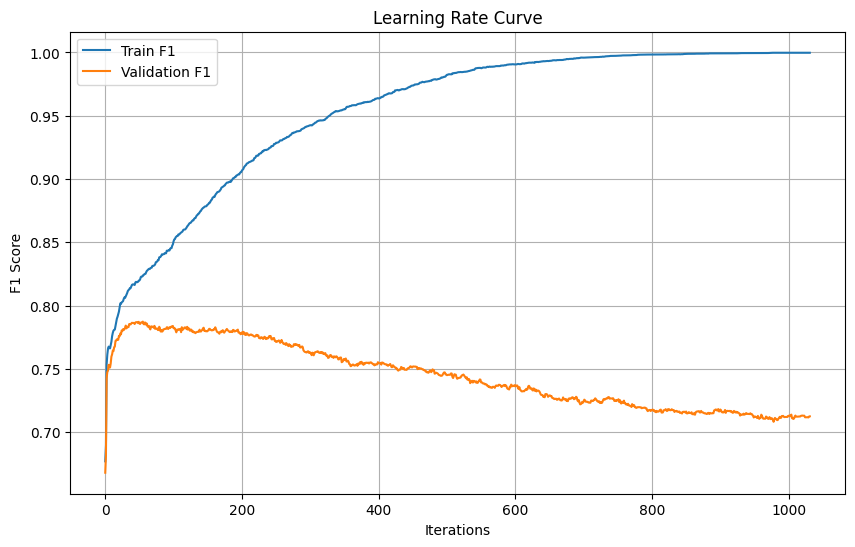

In [104]:
plt.figure(figsize=(10, 6))

# plot
plt.plot(cat_model.evals_result_['learn']['F1'], label='Train F1')
plt.plot(cat_model.evals_result_['validation']['F1'], label='Validation F1')

# labels, title, and legend
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.title('Learning Rate Curve')
plt.legend()
plt.grid()
plt.show()

## Model Evaluation

### Classification report:

In [108]:
report = classification_report(y_test, cat_preds, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.97      0.91      0.94      7635
         Yes       0.52      0.78      0.63      1004

    accuracy                           0.89      8639
   macro avg       0.75      0.84      0.78      8639
weighted avg       0.92      0.89      0.90      8639



The improvements in f1-score were modest, even after experimenting with various scale adjustments, and came at the expense of overall accuracy. However, the recall for true positives—our primary objective—improved significantly, showing better identification of potential subscribers.

### ROC curve:

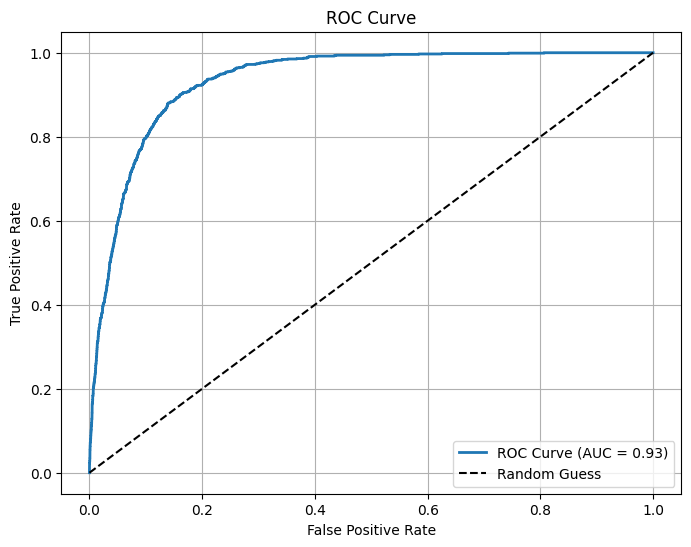

In [113]:
# prediction probabilities
cat_probs = cat_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, cat_probs)

# ROC AUC score
auc_score = roc_auc_score(y_test, cat_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The AUC score slightly decreased, but it’s nothing to be concerned about. The trade-off is worth it as the recall for true positives—our primary objective—improved significantly.

### Confusion Matrix

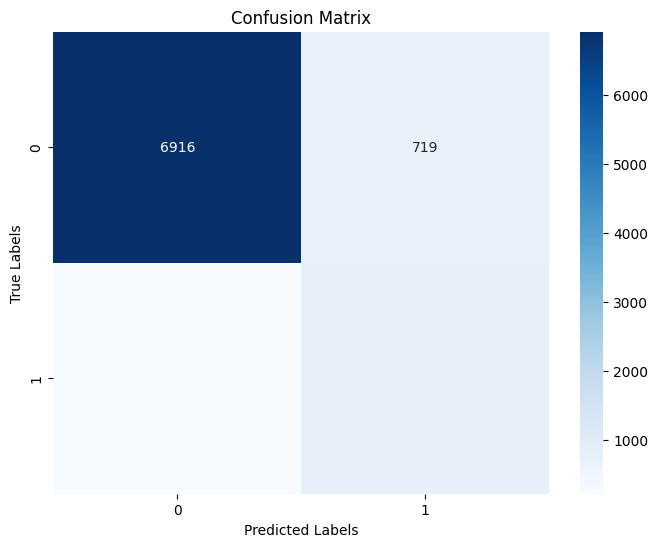

In [117]:
# make predictions
y_pred = cat_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

After hyperparameter tuning, the matrix shows an increase in correctly identified subscribers, though some misclassifications remain.

## Feature selection:

Understanding what drives our model is key, and we’re using two simple yet powerful methods. Permutation Importance quickly shows which features are most important by measuring how performance drops when we shuffle them. SHAP Violin Plots go deeper, revealing not just which features matter but also how they influence predictions, whether positively or negatively. Together, these methods give us a clear, well-rounded view of our model’s decision-making process.

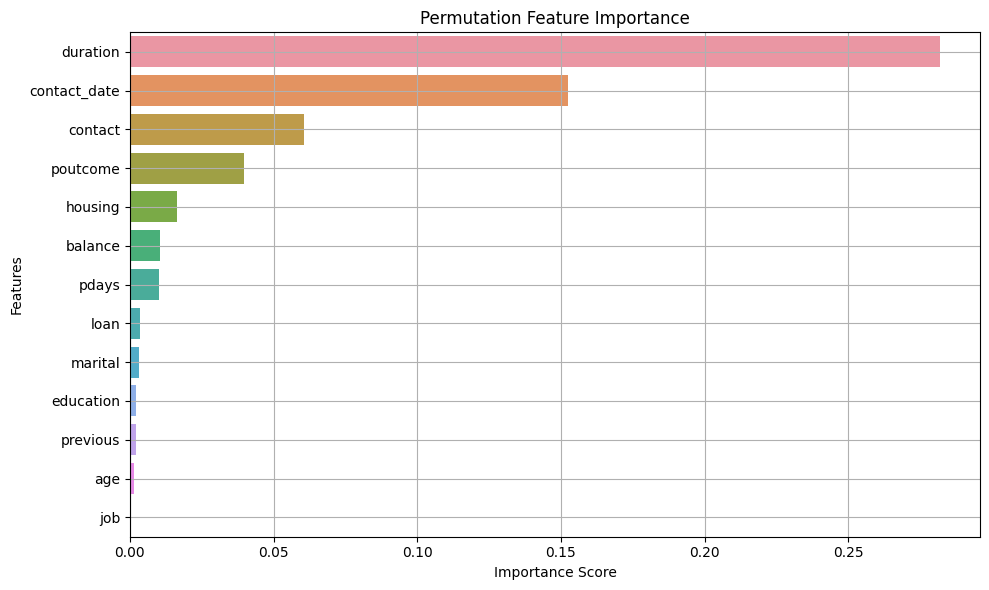

In [213]:
# permutation importance
perm_importance = permutation_importance(cat_model, X_test, y_test, scoring="f1", 
                                         n_repeats=10, random_state=42)

# to conver into df
perm_feature_scores = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
    }).sort_values(by="Importance", ascending=False)

# plot permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(x=perm_feature_scores["Importance"], y=perm_feature_scores["Feature"])
plt.title("Permutation Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

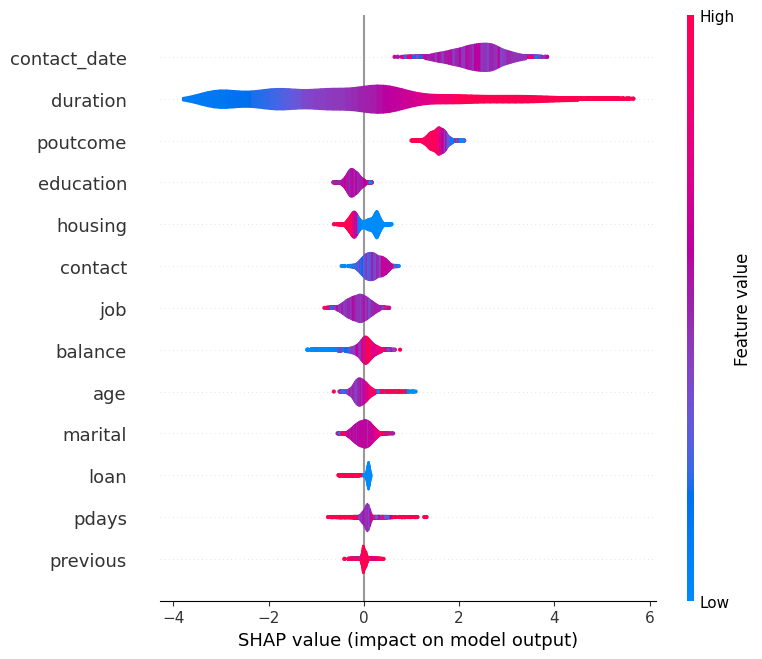

In [164]:
# Ensure that categorical features are encoded
X_test_encoded = X_test.copy()
for col in category_cols:
    X_test_encoded[col] = X_test_encoded[col].astype('category').cat.codes

# initialize SHAP explainer
explainer = shap.TreeExplainer(cat_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_encoded)

# plot (violin plot)
shap.summary_plot(shap_values, X_test_encoded, plot_type="violin")

The analysis shows that "Duration" and "Contact_date" have the biggest impact on predictions, followed by "Contact" and "Poutcome." SHAP explains how "Duration" strongly boosts predictions when it's high, while "Contact_date" has a mixed influence. Features like "Previous" and "Age" barely matter. We'll focus on the top features identified by SHAP and permutation importance, remove the rest, and retrain the model for better performance and efficiency.

### Let's filter using a 2.5% threshold:

In [215]:
# Assuming `perm_importance` is already calculated
perm_importance = pd.DataFrame({'feature': X_test.columns, 
                                'perm_importance': perm_importance.importances_mean})

perm_threshold = 0.01  # Set the importance threshold
perm_features = perm_importance[perm_importance['perm_importance'] > perm_threshold]['feature'].tolist()

# let's filter on important features
X_train_filtered = X_train[perm_features]
X_test_filtered = X_test[perm_features]

print("Selected Features:")
print(perm_features)

Selected Features:
['balance', 'housing', 'contact', 'duration', 'pdays', 'poutcome', 'contact_date']


In [217]:
category_cols = ['contact', 'contact_date', 'poutcome']

# initialize the tunned model
cat_model_filtered = CatBoostClassifier(**best_params, cat_features=category_cols)

# and retrain the model on the filtered dataset
cat_model_filtered.fit(X_train_filtered, y_train)

# lets make predictions
y_pred_filtered = cat_model_filtered.predict(X_test_filtered)

0:	learn: 0.6942310	total: 29.2ms	remaining: 30.1s
1:	learn: 0.7450622	total: 42.3ms	remaining: 21.8s
2:	learn: 0.7603945	total: 69.6ms	remaining: 23.9s
3:	learn: 0.7673508	total: 103ms	remaining: 26.5s
4:	learn: 0.7661754	total: 131ms	remaining: 27s
5:	learn: 0.7677087	total: 139ms	remaining: 23.8s
6:	learn: 0.7690440	total: 162ms	remaining: 23.8s
7:	learn: 0.7698070	total: 166ms	remaining: 21.2s
8:	learn: 0.7678858	total: 173ms	remaining: 19.6s
9:	learn: 0.7693715	total: 177ms	remaining: 18.1s
10:	learn: 0.7706859	total: 200ms	remaining: 18.6s
11:	learn: 0.7711944	total: 208ms	remaining: 17.7s
12:	learn: 0.7729536	total: 234ms	remaining: 18.4s
13:	learn: 0.7759303	total: 246ms	remaining: 17.9s
14:	learn: 0.7774040	total: 273ms	remaining: 18.5s
15:	learn: 0.7795781	total: 299ms	remaining: 19s
16:	learn: 0.7807798	total: 322ms	remaining: 19.2s
17:	learn: 0.7829840	total: 344ms	remaining: 19.4s
18:	learn: 0.7861336	total: 369ms	remaining: 19.7s
19:	learn: 0.7878991	total: 392ms	remainin

## Model Evaluation

### Classification report:

In [221]:
filtered_report = classification_report(y_test, y_pred_filtered, target_names=["No", "Yes"])
print(filtered_report)

              precision    recall  f1-score   support

          No       0.95      0.94      0.94      7635
         Yes       0.57      0.64      0.60      1004

    accuracy                           0.90      8639
   macro avg       0.76      0.79      0.77      8639
weighted avg       0.91      0.90      0.90      8639



Significant improvement in Recall, meaning we’re catching more of the true positives!

### ROC curve:

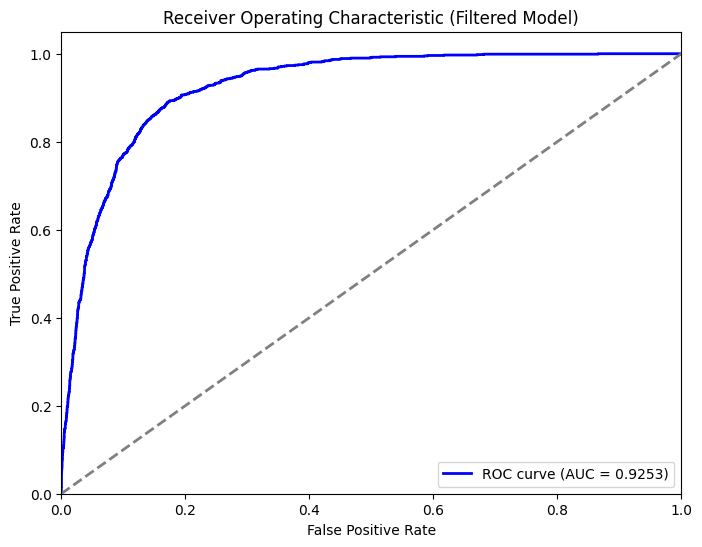

In [225]:
# get predicted probabilities for the filtered model
y_test_proba_filtered = cat_model_filtered.predict_proba(X_test_filtered)[:, 1]

# ROC AUC score
auc_score_filtered = roc_auc_score(y_test, y_test_proba_filtered)

# ROC curve
fpr_filtered, tpr_filtered, _ = roc_curve(y_test, y_test_proba_filtered)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_filtered, tpr_filtered, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score_filtered:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Filtered Model)')
plt.legend(loc="lower right")
plt.show()

Basically the same!

### Confusion matrix:

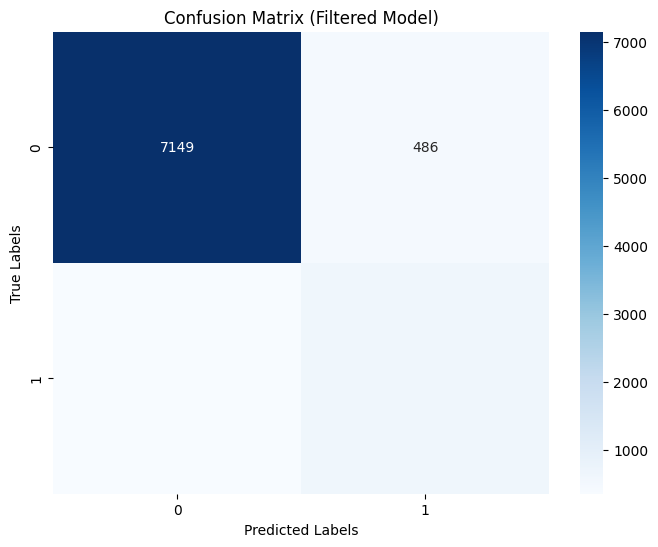

In [230]:
# make predictions
y_pred_filtered = cat_model_filtered.predict(X_test_filtered)

# confusion matrix (filtered)
cm_filtered = confusion_matrix(y_test, y_pred_filtered)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Filtered Model)')
plt.show()

The filtered model shows a clear improvement in identifying the "Yes" class, with more true positives successfully captured. However, there is a trade-off, as some true negatives are now misclassified.

# Summary

After filtering and parameter tuning, our model shows a balance between precision and recall, especially for subscribers ("Yes"). The **accuracy decreased to 85%**, reflecting the trade-off for better handling of imbalanced classes. Precision for "Yes" is **42%**, meaning the model's predictions for subscribers often include false positives. However, the recall improved significantly to **76%**, showing that the model captures more true subscribers, which is crucial for identifying valuable leads. For non-subscribers ("No"), the model maintains high precision (**96%**) and a decent recall (**86%**). The AUC score of **0.9022** confirms the model's overall ability to separate the classes effectively. While true negatives dominate, reducing false negatives remains a priority to increase campaign efficiency and maximize potential conversions.